# Imports and Set Up

In [1]:
# Test MPC

# Standard imports for SCP via JAX and CVXPY
import numpy as np # CVXPY uses numpy
import cvxpy as cvx # For Convex Optimization
from cvxpy.constraints import constraint
import jax # For computing gradients and JIT
import jax.numpy as jnp
from tqdm import tqdm # For progress bars
from functools import partial # For helping JAX

# Assessment
import time
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.optimize

In [2]:
# For Orbit Propagation stuff
!pip install pykep
import pykep

# Top-Level Parameters
# from pykep.core import par2ic, MU_EARTH

# Parameters
R_EARTH = 6378
MU_EARTH_KM = pykep.MU_EARTH * 1e-9
print(f"{pykep.MU_EARTH:e}")
print(f"{MU_EARTH_KM:e}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
3.986004e+14
3.986004e+05


In [3]:
# Custom module imports
# Requires that you mount Google Drive
import os
desired_path = "/content/drive/MyDrive/GitHub/AA203-FinalProject-Hub/AA203_FinalProject"
if os.getcwd() != desired_path:
  os.chdir(desired_path)

!pwd
import dynamics as dn

/content/drive/MyDrive/GitHub/AA203-FinalProject-Hub/AA203_FinalProject


Global Parameters because it's simpler for now

In [4]:
EARTH_TO_SUN_VEC = dn.compute_earth_to_sun()

C_D = 1.5 # Dimensionless
C_SRP = 1.5 # Dimensionless

A = 1.0   # m^2
MASS_SAT = 100   # kg

GAMMA_SRP = C_SRP * A / MASS_SAT
GAMMA_DRAG = C_D * A / MASS_SAT

# JAX-happy Dynamics

In [5]:
# @partial(jax.vmap, in_axes=(0, 0, 0))
def absolute_dynamics(s: jnp.ndarray, t: jnp.ndarray, u: jnp.ndarray):
    """
    Absolute Dynamics of the spacecraft

    @ Inputs
    s: [6,] in ECI
    t: time, unused
    u: [3,] in ECI
    """
    # print(f"s shape = {s.shape} and u shape = {u.shape}")

    # Two body dynamics
    r = s[:3]
    R = jnp.linalg.norm(r)
    a_body = -MU_EARTH_KM*r/R**3
    a_total = a_body + u
    
    sdot = jnp.hstack([s[3:6], a_total])
    return sdot

# @partial(jax.jit, static_argnums=(3,))
# @partial(jax.vmap, in_axes=(0, 0, 0, None))
def relative_dynamics(s: jnp.ndarray, t: jnp.ndarray, u: jnp.ndarray, 
                      state_eci_ref_func: callable):
    """
    Relative Dynamics with respect to the reference orbit

    @ Inputs
    s: [6,] spacecraft state (in LVLH)  [r(3), v(3)]
    t: [1,] time from start [sec]
    u: [3,] control input (in LVLH)
    mu: [1,] gravity pameter GM
    state_eci_ref_func: t -> [6,] position and velocity of the chief in ECI

    @ Outputs
    sdot [9,] time derivative of the states
    """
    x, y, z = s[0], s[1], s[2]
    xdot, ydot, zdot = s[3], s[4], s[5]
    state_eci_ref = state_eci_ref_func(t).flatten()   # Reference Orbit state

    # First calculate the accelaration the reference orbit
    # ref_dot = absolute_dynamics(state_eci_ref, t, jnp.zeros((3,)))

    # Calculate theta_dot, theta_ddot
    eci2rsw = dn.rotation_eci2rsw(state_eci_ref[:3], state_eci_ref[3:6])
    r0 = jnp.linalg.norm(state_eci_ref[:3])
    h = jnp.linalg.norm(jnp.cross(state_eci_ref[:3], state_eci_ref[3:6]))
    theta_dot = h / r0**2
    rdot_rsw = eci2rsw @ state_eci_ref[3:6]
    theta_ddot = - 2 * rdot_rsw[0] * theta_dot / r0

    # calculate ECI position of spacecraft
    eci_sc = dn.lvlh_to_eci(state_eci_ref[:6], s[:6])   # spacecraft r and v in ECI

    # calculate perturbation
    a_srp = dn.solar_radiation_pressure(GAMMA_SRP, eci_sc[:3], EARTH_TO_SUN_VEC)
    a_drag = dn.drag_acceleration(GAMMA_DRAG, eci_sc)

    d_ECI = a_srp + a_drag   # in ECI frame
    d_rsw = eci2rsw @ d_ECI  # convert to rsw frame

    r_sc = jnp.linalg.norm(eci_sc)
    xddot =   2 * theta_dot * ydot + theta_ddot * y + theta_dot**2 * x - MU_EARTH_KM * (r0 + x)/r_sc**3 + MU_EARTH_KM/r0**2 + d_rsw[0] + u[0]
    yddot = - 2 * theta_dot * xdot - theta_ddot * x + theta_dot**2 * y - MU_EARTH_KM * y/r_sc**3 + d_rsw[1] + u[1]
    zddot = - MU_EARTH_KM * z/r_sc**3 + d_rsw[2] + u[2]

    # The parameter is updated
    sdot = jnp.hstack([xdot, ydot, zdot, xddot, yddot, zddot])

    return sdot

In [6]:
# Simple control strategies to test
def zero_control(t):
  return jnp.zeros((3, t.shape[0]))

def const_control(t, const_val):
  return jnp.tile(const_val[:, jnp.newaxis], t.shape[0])

def randn_control(t, mu, std):
  return jnp.array(mu + std * np.random.randn(3, t.shape[0]))

def rand_box_control(t, lb, ub):
  bound_diff = ub - lb
  return jnp.array((ub - lb) * np.random.random((3, t.shape[0])) + lb)

# Interpolation functions
def interp_many(t_vals, s_vals, t_query):
  s_query = [jnp.interp(t_query, t_vals, s_vals[i, :]) for i in range(s_vals.shape[0])]
  return jnp.array(s_query)

def interp_fixed(t_vals, s_vals):

  def interp_wrapped(t_query):
    return interp_many(t_vals, s_vals, t_query)

  return interp_wrapped

In [7]:
ts = jnp.arange(0.0, 1.0, 0.1)
print(f"zero  (shape of {zero_control(ts).shape}) = \n{zero_control(ts)}")
print(f"const (shape of {const_control(ts, jnp.array([-1, 3, 5])).shape}) = \n{const_control(ts, jnp.array([-1, 3, 5]))}")
print(f"randn (shape of {randn_control(ts, jnp.array([[-1], [3], [5]]), 0.1).shape}) = \n{randn_control(ts, jnp.array([[-1], [3], [5]]), 0.1)}")
print(f"randn (shape of {rand_box_control(ts, -0.5, 0.5).shape}) = \n{randn_control(ts, -0.5, 0.5)}")

zero  (shape of (3, 10)) = 
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
const (shape of (3, 10)) = 
[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 3  3  3  3  3  3  3  3  3  3]
 [ 5  5  5  5  5  5  5  5  5  5]]
randn (shape of (3, 10)) = 
[[-1.1066974  -1.1570808  -0.948821   -0.9727888  -1.1190438  -1.0798296
  -0.9309832  -0.89174944 -0.9721053  -0.9618265 ]
 [ 3.0982046   3.0394607   2.9050694   3.0093248   3.1105113   3.115435
   3.0671668   2.9458437   3.1268644   2.8784313 ]
 [ 4.880473    4.96821     4.822849    4.9963856   5.0111537   5.035773
   5.038029    4.881699    5.0177946   4.9228864 ]]
randn (shape of (3, 10)) = 
[[-1.1127934   0.41429126 -0.2567683  -0.17443192 -0.49595088 -0.15483795
   0.28779915 -0.838343   -0.38416186 -0.3559888 ]
 [-0.44103616 -0.17772835 -1.2433451  -0.5701074  -0.36095306 -0.90695405
  -1.2489679  -1.7775049  -0.2752513  -0.28590724]
 [ 0.29066023 -0.5348949  -0.5090291  -0.48861974 -0.12872265 -0.36

# JAX Linearization

In [8]:
@partial(jax.jit, static_argnums=(0,))
@partial(jax.vmap, in_axes=(None, 0, 0, 0))
def linearize(fd: callable,
              s: jnp.ndarray,
              t: jnp.ndarray,
              u: jnp.ndarray):
    """
    Linearize the a discrete time dynamics function `fd(s,u)` around `(s,u)`.
    
    :param fd: The discrete time dynamics
    :param s: The state (can be any dimension as long as 1D)
    :param t: The time (1D)
    :param u: The control (can be any dimension as long as 1D)

    :return: The matrices A, B, and c
    """
    # Get the state and control dimensions
    n, m = s.size, u.size

    f_point = fd(s, t, u)

    # State Linearization
    A = jax.jacrev(fd, 0)(s, t, u)
    assert A.shape == (n, n), f"A shape is {A.shape}. Expected {(n,n)}."

    # Control Linearization
    B = jax.jacrev(fd, 2)(s, t, u)
    assert B.shape == (n, m), f"B shape is {B.shape}. Expected {(n,m)}."

    # The Taylor Series offset
    c = f_point - A @ s - B @ u
    assert c.shape == (n,), f"c shape is {c.shape}. Expected {(n,)}."

    return A, B, c


def discretize(f, dt, **kwargs):
    """
    Discretize continuous-time dynamics `f` via Runge-Kutta integration.
    
    :param f: A function of the form f(s, u) = s dot 
    (i.e., f calculates the state's time-derivative at state s and control u)
    :param dt: The time between states, ideally small.
    """

    def integrator(s, t, u, dt=dt):
        """
        Output dicretized function of the form
        s_k+1 = integrator(s_k, u_k)

        dt can be changed to make it more asynchronous
        """
        # This is h k1 on Wikipedia, similarly below.
        k1 = dt * f(s, t, u, **kwargs)
        k2 = dt * f(s + k1 / 2, t + dt / 2, u, **kwargs)
        k3 = dt * f(s + k2 / 2, t + dt / 2, u, **kwargs)
        k4 = dt * f(s + k3, t + dt, u, **kwargs)
        return s + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return integrator


In [9]:
dt = 0.1
fd_absolute = jax.jit(discretize(absolute_dynamics, dt))

def propagate_absolute_from_control(s0, u_func, t_span):
  s_propagated = np.zeros((s0.shape[0], t_span.shape[0] + 1))
  s_propagated[:, 0] = s0

  u_vec_mat = u_func(t_span)

  for (t_ind, t) in enumerate(t_span):
    s_propagated[:, t_ind + 1] = fd_absolute(s_propagated[:, t_ind], t, u_vec_mat[:, t_ind])
  
  return s_propagated

# Sequential Convex Programming

In [10]:
from cvxpy.error import SolverError
def solve_satellite_scp(fd: callable, t_span: np.ndarray,
                        P: np.ndarray, Q: np.ndarray, 
                        N: int, s0: np.ndarray, u_max: float, rho: float,
                        tol: float, max_iters: int, u_dim: int = 3,
                        s_bar_warm=None, u_bar_warm=None):
    """
    Solve the Satellite Trajectory Tracking problem via Sequential Convex
    Programming. Note that this code is largely based on the code from AA203
    HW 3 problem 2.

    The state is 15 dimensional with 
    (position in R^3, velocity in R^3, parameters in R^3, 
    reference orbit position in R^3, reference orbit velocity in R^3)

    The control is 3 dimensional
    
    :param fd: The discretized dynamics function (completely implemented in JAX)
    :param t_span: The time span as an array (e.g., linspace)
    :param P: The terminal state cost matrix (6 by 6)
    :param Q: The stage state cost matrix (6 by 6)
    :param N: The horizon (number of time steps)
    :param s0: The initial state (15,)
    :param u_max: The maximum allowable control 
    :param rho: The trust region
    :param max_iters: The maximum number of iterations
    :param u_dim: The control dimension (3,)

    :return: The optimized state and control sequence
    """

    n = s0.shape[0]  # state dimension
    m = u_dim       # control dimension

    # Initialize nominal trajectories
    if u_bar_warm is None:
      u_bar = np.zeros((N, m))
    else:
      print("Warm start on the control")
      u_bar = u_bar_warm
      assert u_bar.shape == (N, m)
    
    if s_bar_warm is None:
      s_bar = np.zeros((N + 1, n))
      s_bar[0] = s0

      for k in range(N):
          s_bar[k+1] = fd(s_bar[k], t_span[k], u_bar[k])
    else:
      s_bar = s_bar_warm

    # Do SCP until convergence or maximum number of iterations is reached
    converged = False
    obj_prev = np.inf

    u_constraint_active = False

    # prog_bar = tqdm(range(max_iters), desc='SCP Iterations', position=1, leave=True)
    prog_bar = tqdm(range(max_iters), desc='SCP Iterations')
    for i in prog_bar:
        # Get the optimized values after one sequential convex iteration
        s, u, obj = satellite_scp_iteration(fd, t_span, P, Q, N, u_bar, s_bar, s0, 
                                            u_max, rho, u_dim, u_constraint_active)
        # How much the objective (i.e., cost) changed
        diff_obj = np.abs(obj - obj_prev)
        prog_bar.set_postfix({'objective change': '{:.5f}'.format(diff_obj)})

        if not u_constraint_active:
            u_constraint_active = True
            np.copyto(s_bar, s)
            np.copyto(u_bar, u)
        elif diff_obj < tol:
            converged = True

            conv_message = f"SCP converged after {i} iterations."
            # print(conv_message)
            # tqdm.tqdm.write(conv_message)
            prog_bar.set_postfix({'SCP converged in:': f"{i} iterations"})
            break
        else:
            obj_prev = obj
            np.copyto(s_bar, s)
            np.copyto(u_bar, u)

    if not converged:
        raise RuntimeError('SCP did not converge!')

    
    # prog_bar.close()

    # Output the optimized state and control sequence
    return s, u


def satellite_scp_iteration(fd: callable, t_span: jnp.ndarray,
                            P: np.ndarray, Q: np.ndarray,
                            N: int, u_bar: np.ndarray,
                            s_bar: np.ndarray, s0: np.ndarray,
                            u_max: float, rho: float, u_dim: int,
                            u_constraint_active: bool = True,
                            max_osqp_iters: int = int(1e6),
                            eps_abs_osqp: float =1e-7,
                            eps_rel_osqp: float =1e-7):
    """Solve a single SCP sub-problem for the cart-pole swing-up problem."""
    """
    Solve a single Sequential Convex Programming subproblem of the Satellite 
    Trajectory Tracking problem. Note that this code is largely based on the 
    code from AA203 HW 3 problem 2.

    The state is 15 dimensional with 
    (position in R^3, velocity in R^3, parameters in R^3, 
    reference orbit position in R^3, reference orbit velocity in R^3)

    The control is 3 dimensional
    
    :param fd: The discretized dynamics function (completely implemented in JAX)
    :param P: The terminal state cost matrix (6 by 6)
    :param Q: The stage state cost matrix (6 by 6)
    :param N: The horizon (number of time steps)
    :param s0: The initial state
    :param u_max: The maximum allowable control
    :param rho: The trust region
    :param max_iters: The maximum number of iterations
    :param u_dim: The control dimension
    """
    # Get the linearization of the dynamics with respect to state and control.
    # Convert to numpy array for CVX
    A, B, c = linearize(fd, s_bar[:-1], t_span[:-1], u_bar)
    A, B, c = np.array(A), np.array(B), np.array(c)

    # print(f"A shape = {A.shape}, B = {B.shape}, c = {c.shape}")

    # Dimensionality
    n = s0.shape[0]
    m = u_dim

    # The optimization variables
    s_cvx = cvx.Variable((N + 1, n))
    u_cvx = cvx.Variable((N, m))

    # print(f"s_cvx shape {(N + 1, n)} and u_cvx shape {(N, m)}")

    # First, write all the constraints
    constraints = []

    # Initial point
    constraints += [s_cvx[0] == s0]

    # Dynamics
    constraints += [s_cvx[i + 1] == A[i] @ s_cvx[i] + B[i] @ u_cvx[i] + c[i] for i in range(N)]

    # State Trust Region constraints
    constraints += [cvx.norm(s_cvx - s_bar, "inf") <= rho]

    # Control Trust Region constraints
    constraints += [cvx.norm(u_cvx - u_bar, "inf") <= rho]

    # Control Constraints
    if u_constraint_active:
      print(f"u_max is {u_max}")
      constraints += [cvx.norm(u_cvx[i], "inf") <= u_max for i in range(N)]

    # Second, write the objective
    objective_control = cvx.norm(u_cvx, 1)
    objective_stage_cost = cvx.sum([cvx.quad_form(s_cvx[i, :6], Q) for i in range(N)])
    objective_terminal_state = cvx.quad_form(s_cvx[-1, :6], P)

    objective = objective_control + objective_stage_cost + objective_terminal_state

    # Form the Convex Optimization problem
    prob = cvx.Problem(cvx.Minimize(objective), constraints)

    try:
      prob.solve(verbose=False, max_iter=max_osqp_iters, eps_abs=eps_abs_osqp, eps_rel=eps_rel_osqp)

      if prob.status != 'optimal':
        if prob.status == 'optimal_inaccurate':
          print("Optimal Inaccurate iteration")
    
    except SolverError as e:
          print(f'ITERATION FAILED!! message is:\n\n {e}')
          # print(prob)
          # raise RuntimeError('SCP solve failed. Problem status: ' + prob.status)
          eps_abs_osqp=1e-3
          eps_rel_osqp=1e-3

          prob.solve(verbose=True, max_iter=max_osqp_iters, eps_abs=eps_abs_osqp, eps_rel=eps_rel_osqp)
        

    # Get the variable outputs
    s = s_cvx.value
    u = u_cvx.value
    obj = prob.objective.value

    print(f"Constraint u -> {np.linalg.norm(u, np.inf)}")

    return s, u, obj



# Testing the MPC Subparts
Now actually try to run parts of the MPC. Step zero is parameters of the problem.

In [11]:
from jax.interpreters.mlir import dense_int_elements

# Initial condition of reference orbit
h = 300  # km  height for perigee
e = 0.001
a = (R_EARTH + h) / (1 - e)
i = 0.6
W = 0
w = 0
E = 0

# satellite initial condition
dr = np.array([1.2e-5, 1.5e-5, 1.3e-5])   # relative position vector to ref
dv = np.array([1.1e-5, 1.4e-5, 1.7e-5])  # relative velocity to ref

# compute orbit elements
oe_chief = np.array([a, e, i, W, w, E])
r0_chief, v0_chief = pykep.core.par2ic(oe_chief, MU_EARTH_KM)
r0_sat, v0_sat = r0_chief + dr, v0_chief + dv

# convert to JAX array
x0_chief_eci = jnp.array(np.hstack([r0_chief, v0_chief]))
x0_sat_eci = jnp.array(np.hstack([r0_sat, v0_sat]))

T = 2 * jnp.pi * jnp.sqrt(a**3/MU_EARTH_KM)

print("h: [km]", h)

a_twobody_chief = -MU_EARTH_KM * x0_chief_eci[:3]/ jnp.linalg.norm(x0_chief_eci[:3]) ** 3
a_twobody_sat = -MU_EARTH_KM * x0_sat_eci[:3]/ jnp.linalg.norm(x0_sat_eci[:3]) ** 3

print("Acceleration [km/s^2]: ", jnp.linalg.norm(a_twobody_chief))
print("Acceleration [km/s^2]: ", jnp.linalg.norm(a_twobody_sat))

print("Two body [N]: ", MASS_SAT * 1000 * jnp.linalg.norm(a_twobody_chief))
print("Two body [N]: ", MASS_SAT * 1000 * jnp.linalg.norm(a_twobody_sat))

a_srp = dn.solar_radiation_pressure(GAMMA_SRP, x0_chief_eci[:3], EARTH_TO_SUN_VEC)
print("SRP magnitude [N]: ", MASS_SAT * 1000 * jnp.linalg.norm(a_srp))

a_drag = dn.drag_acceleration(GAMMA_DRAG, x0_chief_eci[:6])
print("drag magnitude [N]: ", MASS_SAT * 1000 * jnp.linalg.norm(a_drag))

h: [km] 300
Acceleration [km/s^2]:  0.008938095
Acceleration [km/s^2]:  0.008938095
Two body [N]:  893.80945
Two body [N]:  893.80945
SRP magnitude [N]:  6.904776e-06
drag magnitude [N]:  0.0033458236


## First up is just running the dynamics

In [12]:
# construct satellite state (Note that we need to include reference orbit as state)
s0_rel_sat = jnp.hstack([dn.eci_to_lvlh(x0_chief_eci, x0_sat_eci)])
print(f"Should be small but not zero = {s0_rel_sat}")
s0_rel_chief = jnp.hstack([dn.eci_to_lvlh(x0_chief_eci, x0_chief_eci)])
print(f"Should be uniformly zero = {s0_rel_chief}")

# tspan_four_periods = np.arange(0, 4 * T, dt)   # propagation step
# print(tspan_four_periods.shape)

# tspan_quarter_periods = np.arange(0, 0.25 * T, dt)   # propagation step
tspan_quarter_periods = np.arange(0, 0.025 * T, dt)   # propagation step
print(f"T vector is shape {tspan_quarter_periods.shape}, from {tspan_quarter_periods[0]} to {tspan_quarter_periods[-1]}")

# Test absolute dynamics
print(f"At \n{x0_chief_eci},\nx dot = \n" + 
      str(absolute_dynamics(x0_chief_eci, jnp.array([1,]), jnp.zeros((3,)))))

print(discretize(absolute_dynamics, dt))
print(x0_chief_eci.shape)
print(discretize(absolute_dynamics, dt)(x0_chief_eci, jnp.array([0.0]), jnp.zeros((3,))))
print(fd_absolute(x0_chief_eci, jnp.array([0.0]), jnp.zeros((3,))))

Should be small but not zero = [0.0000000e+00 1.9720386e-05 2.2597262e-06 1.1022827e-05 2.1499252e-05
 6.0905495e-06]
Should be uniformly zero = [0. 0. 0. 0. 0. 0.]
T vector is shape (1360,), from 0.0 to 135.9
At 
[6.6780000e+03 0.0000000e+00 0.0000000e+00 0.0000000e+00 6.3795977e+00
 4.3645177e+00],
x dot = 
[ 0.          6.3795977   4.3645177  -0.00893809  0.          0.        ]
<function discretize.<locals>.integrator at 0x7fb379d43d40>
(6,)
[ 6.6780000e+03  6.3795978e-01  4.3645176e-01 -8.9380943e-04
  6.3795977e+00  4.3645177e+00]
[ 6.6780000e+03  6.3795978e-01  4.3645176e-01 -8.9380948e-04
  6.3795977e+00  4.3645177e+00]


In [13]:
print(f"From \n{x0_chief_eci} to \n" + 
      str(fd_absolute(x0_chief_eci, jnp.array([1,]), jnp.zeros((3,)))))

# Need to generate the chief trajectory
t_start = time.time()
x_chief_eci_traj = propagate_absolute_from_control(x0_chief_eci, zero_control, tspan_quarter_periods)
x_sat_eci_traj = propagate_absolute_from_control(x0_sat_eci, zero_control, tspan_quarter_periods)
t_end = time.time()

print(f"chief trajectory length = {x_chief_eci_traj.shape}")
print(f"satellite trajectory length = {x_sat_eci_traj.shape}")
print(f"Took {t_end - t_start} seconds to propagate absolute chief and satellite orbits")

From 
[6.6780000e+03 0.0000000e+00 0.0000000e+00 0.0000000e+00 6.3795977e+00
 4.3645177e+00] to 
[ 6.6780000e+03  6.3795978e-01  4.3645176e-01 -8.9380948e-04
  6.3795977e+00  4.3645177e+00]
chief trajectory length = (6, 1361)
satellite trajectory length = (6, 1361)
Took 3.0451393127441406 seconds to propagate absolute chief and satellite orbits


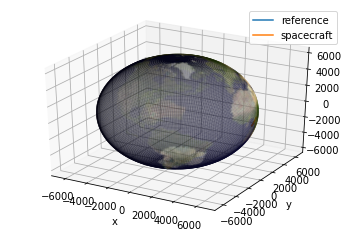

In [14]:
dn.plot_absolute_orbits(x_chief_eci_traj.T, x_sat_eci_traj.T)

In [15]:
# Jit the relative dynamics from the absolute dynamics

interp_abs_chief_jit = jax.jit(interp_fixed(tspan_quarter_periods, x_chief_eci_traj[:, :-1]))
fd_relative_4T = jax.jit(discretize(relative_dynamics, dt, state_eci_ref_func=interp_abs_chief_jit))

# Test the interpolation
print(tspan_quarter_periods.shape)
print(x_chief_eci_traj[:, :-1].shape)
i1 = interp_fixed(tspan_quarter_periods, x_chief_eci_traj[:, :-1])

t_test = jnp.array([5])
print(i1(t_test))
print(interp_abs_chief_jit(t_test))

t_test = jnp.array([0.0, 5.0, 10.0, 20.0])
print(i1(t_test))
print(i1(t_test).shape)
print(interp_abs_chief_jit(t_test))
print(interp_abs_chief_jit(t_test).shape)

(1360,)
(6, 1360)
[[ 6.6778887e+03]
 [ 3.1897812e+01]
 [ 2.1822468e+01]
 [-4.4690218e-02]
 [ 6.3794909e+00]
 [ 4.3644447e+00]]
[[ 6.6778887e+03]
 [ 3.1897812e+01]
 [ 2.1822468e+01]
 [-4.4690218e-02]
 [ 6.3794909e+00]
 [ 4.3644447e+00]]
[[ 6.67800000e+03  6.67788867e+03  6.67755371e+03  6.67621289e+03]
 [ 0.00000000e+00  3.18978119e+01  6.37945557e+01  1.27580574e+02]
 [ 0.00000000e+00  2.18224678e+01  4.36442146e+01  8.72825851e+01]
 [ 0.00000000e+00 -4.46902178e-02 -8.93789381e-02 -1.78745881e-01]
 [ 6.37959766e+00  6.37949085e+00  6.37917089e+00  6.37789011e+00]
 [ 4.36451769e+00  4.36444473e+00  4.36422586e+00  4.36335039e+00]]
(6, 4)
[[ 6.67800000e+03  6.67788867e+03  6.67755371e+03  6.67621289e+03]
 [ 0.00000000e+00  3.18978119e+01  6.37945557e+01  1.27580574e+02]
 [ 0.00000000e+00  2.18224678e+01  4.36442146e+01  8.72825851e+01]
 [ 0.00000000e+00 -4.46902178e-02 -8.93789381e-02 -1.78745881e-01]
 [ 6.37959766e+00  6.37949085e+00  6.37917089e+00  6.37789011e+00]
 [ 4.36451769e+00  

In [16]:
# Test the relative dynamics
t_test = jnp.array([0.0])
print("s0 + s dot * dt")
print(s0_rel_sat + dt * relative_dynamics(s0_rel_sat, t_test, zero_control(t_test), state_eci_ref_func=interp_abs_chief_jit))

print("Discretization no control")
print(discretize(relative_dynamics, dt, state_eci_ref_func=interp_abs_chief_jit)(s0_rel_sat, t_test, zero_control(t_test)))
print(fd_relative_4T(s0_rel_sat, t_test, zero_control(t_test)))

print("Different controls")
print(fd_relative_4T(s0_rel_sat, t_test, const_control(t_test, jnp.array([10.0, -10.0, 0.0]))))

s0 + s dot * dt
[1.10228268e-06 2.18703117e-05 2.86878117e-06 1.10295305e-05
 2.14933625e-05 6.09065864e-06]
Discretization no control
[1.10261783e-06 2.18700170e-05 2.86878662e-06 1.10295305e-05
 2.14933607e-05 6.09065819e-06]
[1.10261794e-06 2.18700170e-05 2.86878662e-06 1.10295305e-05
 2.14933607e-05 6.09065819e-06]
Different controls
[ 4.9997248e-02 -4.9981993e-02  2.8687864e-06  9.9989533e-01
 -1.0000943e+00  6.0906518e-06]


### Propagate relative from control

In [17]:
def propagate_relative_from_control(s0, u_vec, t_span):
  s_propagated = np.zeros((s0.shape[0], t_span.shape[0] + 1))
  s_propagated[:, 0] = s0

  # print(f"Original shape is {u_vec.shape}")
  u_vec_mat = u_vec.reshape(3, -1)
  # print(f"New shape is {u_vec_mat.shape}")

  for (t_ind, t) in enumerate(t_span):
    # print(f"u curr (shape = {u_vec_mat[:, t_ind].shape}) = {u_vec_mat[:, t_ind]}")
    s_propagated[:, t_ind + 1] = fd_relative_4T(s_propagated[:, t_ind], t, u_vec_mat[:, t_ind])
  
  return s_propagated

(3, 1)


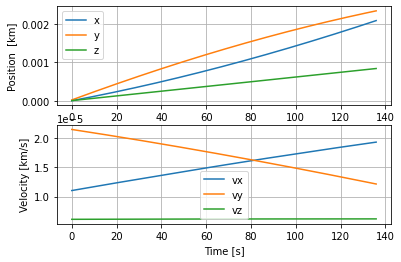

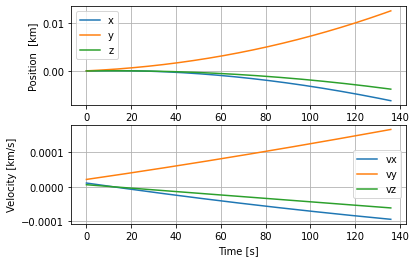

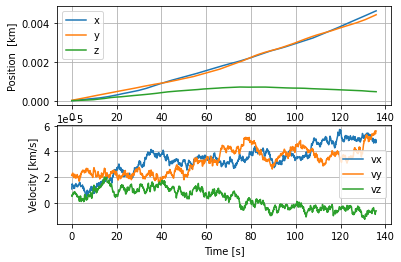

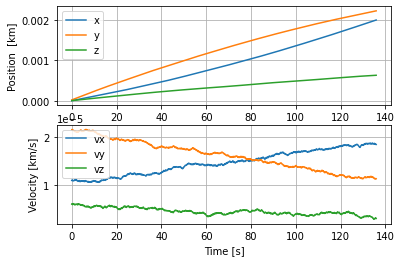

In [18]:
s_rel_test = propagate_relative_from_control(s0_rel_sat, const_control(t_test, jnp.array([10.0, -10.0, 0.0])), t_test)

s_rel_test_zero_u = propagate_relative_from_control(s0_rel_sat, 
                                                    zero_control(tspan_quarter_periods), 
                                                    tspan_quarter_periods)

u_test = jnp.array([-1e-6, 1.0e-6, -0.5e-6])
s_rel_test_const_u = propagate_relative_from_control(s0_rel_sat, 
                                                     const_control(tspan_quarter_periods, u_test), 
                                                     tspan_quarter_periods)

mu_u_test = jnp.array([[1e-8], [-1e-8], [5e-8]])
print(mu_u_test.shape)
std_u_test = 1e-5
s_rel_test_randn_u = propagate_relative_from_control(s0_rel_sat, 
                                                    randn_control(tspan_quarter_periods, mu_u_test, std_u_test), 
                                                    tspan_quarter_periods)


lb_test = -1e-6
ub_test = 1e-6
s_rel_test_randbox_u = propagate_relative_from_control(s0_rel_sat, 
                                                    rand_box_control(tspan_quarter_periods, lb_test, ub_test), 
                                                    tspan_quarter_periods)

dn.plot_relative_orbit(tspan_quarter_periods, s_rel_test_zero_u[:, :-1].T)
dn.plot_relative_orbit(tspan_quarter_periods, s_rel_test_const_u[:, :-1].T)
dn.plot_relative_orbit(tspan_quarter_periods, s_rel_test_randn_u[:, :-1].T)
dn.plot_relative_orbit(tspan_quarter_periods, s_rel_test_randbox_u[:, :-1].T)

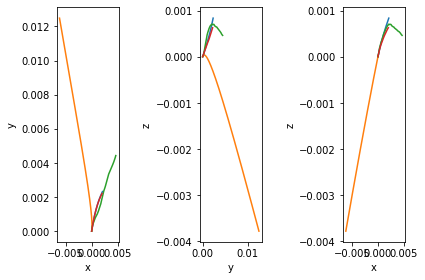

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].plot(s_rel_test_zero_u[0, :], s_rel_test_zero_u[1, :])
ax[0].plot(s_rel_test_const_u[0, :], s_rel_test_const_u[1, :])
ax[0].plot(s_rel_test_randn_u[0, :], s_rel_test_randn_u[1, :])
ax[0].plot(s_rel_test_randbox_u[0, :], s_rel_test_randbox_u[1, :])
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].plot(s_rel_test_zero_u[1, :], s_rel_test_zero_u[2, :])
ax[1].plot(s_rel_test_const_u[1, :], s_rel_test_const_u[2, :])
ax[1].plot(s_rel_test_randn_u[1, :], s_rel_test_randn_u[2, :])
ax[1].plot(s_rel_test_randbox_u[1, :], s_rel_test_randbox_u[2, :])
ax[1].set_xlabel("y")
ax[1].set_ylabel("z")

ax[2].plot(s_rel_test_zero_u[0, :], s_rel_test_zero_u[2, :])
ax[2].plot(s_rel_test_const_u[0, :], s_rel_test_const_u[2, :])
ax[2].plot(s_rel_test_randn_u[0, :], s_rel_test_randn_u[2, :])
ax[2].plot(s_rel_test_randbox_u[0, :], s_rel_test_randbox_u[2, :])
ax[2].set_xlabel("x")
ax[2].set_ylabel("z")

plt.tight_layout()
plt.show()

In [20]:
# print("Propagating Relative Orbit ...")


# a_rel_zero_ctrl = relative_dynamics(s0_rel_sat, 0, zero_control, )

# t_start = time.time()
# s_rel = dn.propagate_relative_orbit(s0_rel_sat, tspan, dn.zero_control,
#                                     MU_EARTH_KM, earth_to_sun, T,
#                                     pflag=[True, True, True], debug=True)

# t_end = time.time()
# print(f"Original propagator took {t_end - t_start} seconds")

# # plot the relative orbit
# dn.plot_relative_orbit(tspan, s_rel)

In [21]:
# print(dn.relative_dynamics(s0_rel_sat, 0, u0, MU_EARTH_KM, earth_to_sun, T, debug=True))
# print()

# curr_kwargs = {
#     "mu": MU_EARTH_KM, 
#     "earth_to_sun": earth_to_sun, 
#     "T": T, 
#     "debug": True
# }
# print(relative_dynamics_key_word_wrapper(s0_rel_sat, 0, u0, **curr_kwargs))

## Second, Jacobians of the dynamics

In [22]:
u_jac_test = jnp.array([0.001, 0.002, 0.003])
J_abs = jax.jacfwd(absolute_dynamics, argnums=(0,2))(x0_chief_eci, 0, u_jac_test)
print("Jacobian (x, absolute orbit) shape: ", J_abs[0].shape)
print("Jacobian (u, absolute orbit) shape: ", J_abs[1].shape)

J_rel_continuous = jax.jacfwd(relative_dynamics, argnums=(0,2))(s0_rel_sat, 0, u_jac_test, state_eci_ref_func=interp_abs_chief_jit)
print("Jacobian (x, relative orbit) shape: ", J_rel_continuous[0].shape)
print("Jacobian (u, relative orbit) shape: ", J_rel_continuous[1].shape)

J_rel_discrete = jax.jacfwd(fd_relative_4T, argnums=(0,2))(s0_rel_sat, 0, u_jac_test)
print("Jacobian (x, relative orbit) shape: ", J_rel_discrete[0].shape)
print("Jacobian (u, relative orbit) shape: ", J_rel_discrete[1].shape)

Jacobian (x, absolute orbit) shape:  (6, 6)
Jacobian (u, absolute orbit) shape:  (6, 3)
Jacobian (x, relative orbit) shape:  (6, 6)
Jacobian (u, relative orbit) shape:  (6, 3)
Jacobian (x, relative orbit) shape:  (6, 6)
Jacobian (u, relative orbit) shape:  (6, 3)


## Third, linearizing the dynamics

In [23]:
a_mat_test, b_mat_test, c_vec_test = linearize(fd_relative_4T, 
                                               s_rel_test_zero_u[:, :-1].T, 
                                               tspan_quarter_periods, 
                                               zero_control(tspan_quarter_periods).T)

print(f"A shape = {a_mat_test.shape}")
print(f"B shape = {b_mat_test.shape}")
print(f"C shape = {c_vec_test.shape}")

A shape = (1360, 6, 6)
B shape = (1360, 6, 3)
C shape = (1360, 6)


Compare the discrete dynamics propagation to the continuous dynamics.

In [24]:
# # tspan = np.linspace(0, 0.5 * T, 20)
# tspan_for_fd = np.arange(0, 0.5 * T + dt, dt)
# print(tspan_for_fd.shape)
# s_next_arr = np.zeros((tspan_for_fd.shape[0] + 1, 15))
# s_next_arr[0, :] = s0_rel_sat

# t_start = time.time()
# for (t_ind, t) in enumerate(tspan_for_fd):
#   s_next_arr[t_ind + 1, :] = fd_with_jit(s_next_arr[t_ind, :], t, u0)
# t_end = time.time()
# print(f"JIT implementation took {t_end - t_start} seconds")

# # Plot JIT results
# dn.plot_relative_orbit(tspan_for_fd, s_next_arr[:-1])

# # Plot Original Propagator results
# dn.plot_relative_orbit(tspan, s_rel)

In [25]:
# # tspan = np.linspace(0, 0.5 * T, 20)
# tspan_for_fd = np.arange(0, 4 * T + dt, dt)
# print(tspan_for_fd.shape)
# s_next_arr = np.zeros((tspan_for_fd.shape[0] + 1, 15))
# s_next_arr[0, :] = s0_rel_sat

# t_start = time.time()
# for (t_ind, t) in enumerate(tspan_for_fd):
#   s_next_arr[t_ind + 1, :] = fd_with_jit(s_next_arr[t_ind, :], t, u0)
# t_end = time.time()
# print(f"JIT implementation took {t_end - t_start} seconds")

# # Original propagator
# tspan = np.linspace(0, 4 * T, 20)   # propagation step

# print("Propagating Relative Orbit ...")

# t_start = time.time()
# a_rel_total = dn.relative_dynamics(s0_rel_sat, 0, u0, MU_EARTH_KM, earth_to_sun, T, debug=True)
# s_rel = dn.propagate_relative_orbit(s0_rel_sat, tspan, dn.zero_control,
#                                     MU_EARTH_KM, earth_to_sun, T,
#                                     pflag=[True, True, True], debug=True)

# t_end = time.time()
# print(f"Original propagator took {t_end - t_start} seconds")

# # Plot JIT results
# dn.plot_relative_orbit(tspan_for_fd, s_next_arr[:-1])

# # plot the relative orbit from the propagator
# dn.plot_relative_orbit(tspan, s_rel)

In [26]:
# print(f"tspan shape {tspan.shape} and tspan is \n{tspan}")
# print(f"srel shape {s_rel.shape} and srel is \n{s_rel[:, 0]}")

# # print(np.interp(tspan, tspan_for_fd, s_next_arr[:, 0]))
# print(tspan_for_fd.shape)
# print(s_next_arr[:-1].shape)
# # print(np.interp(tspan, tspan_for_fd, s_next_arr[:-1, 0]))

# def interp_many(t_vals, s_vals, t_query):
#   s_query = [np.interp(t_query, t_vals, s_vals[:, i]) for i in range(s_vals.shape[1])]
#   return np.array(s_query).T

# vals_interpolated = interp_many(tspan_for_fd, s_next_arr[:-1], tspan)
# print(vals_interpolated.shape)

# norm_diff = np.linalg.norm(s_rel - vals_interpolated, axis=1)
# # print(f"Shapes = {s_rel.shape}, {s_rel[:, :3].shape}, {s_rel[:, 3:6].shape}")
# norm_diff_rel_state = np.linalg.norm(s_rel[:, :3] - vals_interpolated[:, :3], axis=1)
# norm_diff_rel_velocity = np.linalg.norm(s_rel[:, 3:6] - vals_interpolated[:, 3:6], axis=1)
# norm_diff_params = np.linalg.norm(s_rel[:, 6:9] - vals_interpolated[:, 6:9], axis=1)
# norm_diff_ref_state = np.linalg.norm(s_rel[:, 9:12] - vals_interpolated[:, 9:12], axis=1)
# norm_diff_ref_velocity = np.linalg.norm(s_rel[:, 12:] - vals_interpolated[:, 12:], axis=1)

# plt.semilogy(tspan, norm_diff, label="Total Array")
# plt.semilogy(tspan, norm_diff_rel_state, '--', label="Relative Position")
# plt.semilogy(tspan, norm_diff_rel_velocity, '--', label="Relative Velocity")
# plt.semilogy(tspan, norm_diff_params, '--', label="Parameters")
# plt.semilogy(tspan, norm_diff_ref_state, '--', label="Reference Position")
# plt.semilogy(tspan, norm_diff_ref_velocity, '--', label="Reference Velocity")
# plt.xlabel("Time [s]")
# plt.ylabel("Log of 2-Norm Difference")
# plt.legend()
# plt.show()

Try propagating with the control

In [27]:
# def propagate_from_control(s0, u_vec, t_span):
#   # print(f"s0 shape = {s0.shape}, u_vec shape = {u_vec.shape}, t_span shape = {t_span.shape}")
#   s_propagated = np.zeros((t_span.shape[0] + 1, s0.shape[0]))
#   s_propagated[0, :] = s0

#   u_vec_mat = u_vec.reshape(-1, 3)

#   for (t_ind, t) in enumerate(t_span):
#     s_propagated[t_ind + 1, :] = fd_with_jit(s_propagated[t_ind, :], t, u_vec_mat[t_ind, :])
  
#   return s_propagated

# u_example = 1e-6 * np.random.rand(tspan_for_fd.shape[0], 3) + 1e-7
# s_prop = propagate_from_control(s0_rel_sat, u_example, tspan_for_fd)

# dn.plot_relative_orbit(tspan_for_fd, s_prop[:-1])

In [28]:
# u_example_orig = 1e-6 * np.random.rand(tspan.shape[0], 3) + 1e-7

# def controller_example(t, s):
#   u_out = interp_many(tspan, u_example_orig, t)
#   return u_out


# t_start = time.time()
# a_rel_total = dn.relative_dynamics(s0_rel_sat, 0, u0, MU_EARTH_KM, earth_to_sun, T, debug=True)
# s_rel = dn.propagate_relative_orbit(s0_rel_sat, tspan, controller_example,
#                                     MU_EARTH_KM, earth_to_sun, T,
#                                     pflag=[True, True, True], debug=True)

# t_end = time.time()
# print(f"Original propagator took {t_end - t_start} seconds")

# # plot the relative orbit
# dn.plot_relative_orbit(tspan, s_rel)

In [29]:
# print(f"tspan shape {tspan.shape} and tspan is \n{tspan}")
# print(f"srel shape {s_rel.shape} and srel is \n{s_rel[:, 0]}")

# # print(np.interp(tspan, tspan_for_fd, s_next_arr[:, 0]))
# print(tspan_for_fd.shape)
# print(s_prop[:-1].shape)
# # print(np.interp(tspan, tspan_for_fd, s_next_arr[:-1, 0]))

# def interp_many(t_vals, s_vals, t_query):
#   s_query = [np.interp(t_query, t_vals, s_vals[:, i]) for i in range(s_vals.shape[1])]
#   return np.array(s_query).T

# vals_interpolated = interp_many(tspan_for_fd, s_prop[:-1], tspan)
# print(vals_interpolated.shape)

# norm_diff = np.linalg.norm(s_rel - vals_interpolated, axis=1)
# # print(f"Shapes = {s_rel.shape}, {s_rel[:, :3].shape}, {s_rel[:, 3:6].shape}")
# norm_diff_rel_state = np.linalg.norm(s_rel[:, :3] - vals_interpolated[:, :3], axis=1)
# norm_diff_rel_velocity = np.linalg.norm(s_rel[:, 3:6] - vals_interpolated[:, 3:6], axis=1)
# norm_diff_params = np.linalg.norm(s_rel[:, 6:9] - vals_interpolated[:, 6:9], axis=1)
# norm_diff_ref_state = np.linalg.norm(s_rel[:, 9:12] - vals_interpolated[:, 9:12], axis=1)
# norm_diff_ref_velocity = np.linalg.norm(s_rel[:, 12:] - vals_interpolated[:, 12:], axis=1)

# plt.semilogy(tspan, norm_diff, label="Total Array")
# plt.semilogy(tspan, norm_diff_rel_state, '--', label="Relative Position")
# plt.semilogy(tspan, norm_diff_rel_velocity, '--', label="Relative Velocity")
# plt.semilogy(tspan, norm_diff_params, '--', label="Parameters")
# plt.semilogy(tspan, norm_diff_ref_state, '--', label="Reference Position")
# plt.semilogy(tspan, norm_diff_ref_velocity, '--', label="Reference Velocity")
# plt.xlabel("Time [s]")
# plt.ylabel("Log of 2-Norm Difference")
# plt.legend()
# plt.show()

In [30]:
# Sample a random control and check the cost

mu_u_test = jnp.array([[1e-8], [-1e-8], [5e-8]])
print(mu_u_test.shape)
std_u_test = 1e-5
u_example = randn_control(tspan_quarter_periods, mu_u_test, std_u_test)
u_cost = np.linalg.norm(u_example, 1)

print(u_example.shape)

s_stage = 100 * np.sum(s_rel_test_randn_u[:-1, :6].T @ s_rel_test_randn_u[:-1, :6])
s_terminal = 1e4 * s_rel_test_randn_u[-1, :6].T @ s_rel_test_randn_u[-1, :6]

total_cost = u_cost + s_stage + s_terminal

print(f"u cost = {u_cost}, s cost stage = {s_stage}, s cost terminal = {s_terminal}")

# diff_rel = s_next_arr[:, :6] - s_next_arr[:, 9:]
# s_stage = np.sum(diff_rel[:-1].T @ diff_rel[:-1])
# s_terminal = 100 * diff_rel[-1].T @ diff_rel[-1]

# print(f"u cost = {u_cost}, s cost stage = {s_stage}, s cost terminal = {s_terminal}")
print(f"Total is {total_cost}")

(3, 1)
(3, 1360)
u cost = 6.207225669641048e-05, s cost stage = 4.857008060617474e-06, s cost terminal = 2.375797516602715e-06
Total is 6.930506227363067e-05


Try with Scipy Minimize and shooting method

In [31]:
def to_be_minimized_from_control(u_ctrl, s0, t_span):
  u_cost = np.linalg.norm(u_ctrl, 1)

  s_propagated = propagate_relative_from_control(s0, u_ctrl, t_span)

  s_stage = 1e4 * np.sum(s_propagated[:-1, :6].T @ s_propagated[:-1, :6])
  s_terminal = 1e7 * s_propagated[-1, :6].T @ s_propagated[-1, :6]

  return u_cost + s_stage + s_terminal


min_T = -250e-3  # N
max_T = 250e-3  # N
# min_T = -250  # N
# max_T = 250  # N

u_min = min_T/MASS_SAT/1000
u_max = max_T/MASS_SAT/1000

N_horizon = 100
tspan_optimize = np.arange(0, N_horizon * dt, dt)
u_example = rand_box_control(tspan_optimize, u_min, u_max)
u_example = u_example.flatten()


print(f"Lower bound = {u_min}, Upper bound = {u_max}")
print(f"T start = {tspan_optimize[0]}, T end = {tspan_optimize[-1]}")
print(f"U example shape = {u_example.shape}")
# print(f"u_example = {u_example}")
print(f"initial cost is {to_be_minimized_from_control(u_example, s0_rel_sat, tspan_optimize)}")
print(f"Zero u cost is  {to_be_minimized_from_control(np.zeros_like(u_example), s0_rel_sat, tspan_optimize)}")
print(f"Min u cost is   {to_be_minimized_from_control(u_min * np.ones_like(u_example), s0_rel_sat, tspan_optimize)}")
print(f"Max u cost is   {to_be_minimized_from_control(u_max * np.ones_like(u_example), s0_rel_sat, tspan_optimize)}")

t_start = time.time()
result = scipy.optimize.minimize(to_be_minimized_from_control, u_example, 
                                 args=(s0_rel_sat, tspan_optimize),
                                 options={'disp': True, 'maxiter': 50,
                                          'gtol': 2e-10, 'eps': 2e-10,
                                          'maxfun': np.inf},
                                 bounds=scipy.optimize.Bounds(u_min, u_max, keep_feasible=False))

t_end = time.time()

print()
print()
# print(result)

print("\nResult\n")
print(f"Wall time = {t_end - t_start} seconds")
print(f"final cost: {result.fun}")
print(f"message: {result.message}")
print(f"result iters: nit = {result.nit} with nfev = {result.nfev}")
print(f"status: {result.status}")

Lower bound = -2.5e-06, Upper bound = 2.5e-06
T start = 0.0, T end = 9.9
U example shape = (300,)
initial cost is 0.003003842366027812
Zero u cost is  0.002670488649974801
Min u cost is   0.002981095653775011
Max u cost is   0.003929224211031972



Result

Wall time = 29.034000158309937 seconds
final cost: 0.002259869510106456
message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
result iters: nit = 35 with nfev = 17759
status: 0


(100, 3)
(100,)


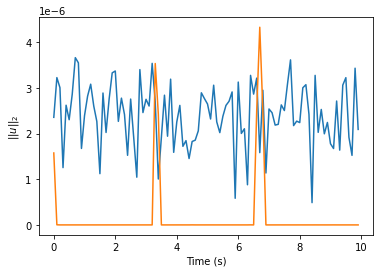

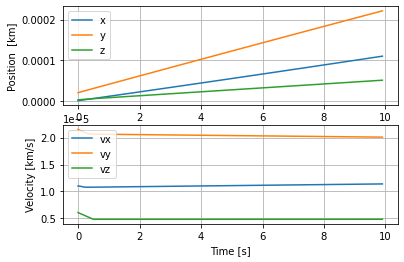

In [32]:
u_optimal = result.x
print(u_optimal.reshape(-1, 3).shape)
print(tspan_optimize.shape)

u_optimal_mat = u_optimal.reshape(-1, 3)
s_optimal = propagate_relative_from_control(s0_rel_sat, u_optimal_mat, tspan_optimize)

plt.plot(tspan_optimize, np.linalg.norm(u_example.reshape(-1, 3), axis=1), label="u initial")
plt.plot(tspan_optimize, np.linalg.norm(u_optimal_mat, axis=1), label="u optimal")
plt.xlabel("Time (s)")
plt.ylabel("$||u||_2$")
plt.show()

dn.plot_relative_orbit(tspan_optimize, s_optimal[:, :-1].T)

## Fourth, try SCP

In [33]:
# SCP parameters
P_outer = 1e8 * np.eye(6)                    # terminal state cost matrix
Q_outer = 1e5 * np.eye(6)                    # state cost matrix
rho_outer = 1.                               # trust region parameter
u_max_outer = u_max                          # control effort bound
tol = 5e-1                           # convergence tolerance
max_iters = 10                       # maximum number of SCP iterations
u_dim_outer = 3

# Solve the satellite tracking problem with SCP
N_horizon = 40
t_scp = np.arange(0, (N_horizon + 1) * dt, dt)
N_horizon = t_scp.size - 1
print(f"Horizon is {N_horizon} steps")
s_scp, u_scp = solve_satellite_scp(fd_relative_4T, t_scp, P_outer, Q_outer, N_horizon, s0_rel_sat, 
                           u_max_outer, rho_outer, tol, max_iters, u_dim_outer)

print(f"\n\n Shapes: s={s_scp.shape} and {u_scp.shape}")

# # Simulate open-loop control
# s_open_loop = np.zeros_like(s)
# s_open_loop[0] = s[0]
# for k in range(N):
#     s_open_loop[k+1] = fd_relative_4T(s_open_loop[k], t[k], u[k])

Horizon is 40 steps


SCP Iterations:  10%|█         | 1/10 [00:33<05:04, 33.85s/it, objective change=inf]

Constraint u -> 0.0005088961027610836
u_max is 2.5e-06


SCP Iterations:  20%|██        | 2/10 [00:37<02:08, 16.03s/it, objective change=inf]

Constraint u -> 7.898980412247356e-06
u_max is 2.5e-06


SCP Iterations:  20%|██        | 2/10 [00:39<02:36, 19.62s/it, SCP converged in:=2 iterations]

Constraint u -> 7.898712961655364e-06


 Shapes: s=(41, 6) and (40, 3)


shape u = (40, 3), shape t = (40,)


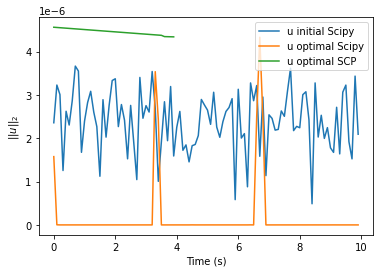

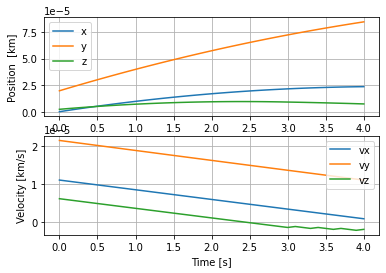

In [34]:
u_optimal_scp = u_scp.reshape(-1, 3)
print(f"shape u = {u_optimal_scp.shape}, shape t = {t_scp[:-1].shape}")
s_optimal_scp = propagate_relative_from_control(s0_rel_sat, u_optimal_scp, t_scp[:-1])

plt.plot(tspan_optimize, np.linalg.norm(u_example.reshape(-1, 3), axis=1), label="u initial Scipy")
plt.plot(tspan_optimize, np.linalg.norm(u_optimal_mat, axis=1), label="u optimal Scipy")
plt.plot(t_scp[:-1], np.linalg.norm(u_optimal_scp, axis=1), label="u optimal SCP")
plt.xlabel("Time (s)")
plt.ylabel("$||u||_2$")
plt.legend()
plt.show()

dn.plot_relative_orbit(t_scp, s_optimal_scp.T)

# Run MPC

In [35]:
def run_MPC(s0, t_terminate, N_horizon, P, Q, u_max, rho, tol, max_iters, u_dim):
  # Use this to store the MPC results
  # t_span_full is the time at each state over the whole trajectory
  t_span_full = np.arange(0.0, t_terminate + N_horizon * dt, dt)

  # Time index to t_terminate
  t_ind_last = len(t_span_full) - N_horizon
  print(f"t_terminate ({t_terminate}) is at index {t_ind_last} of {len(t_span_full)} with value {t_span_full[t_ind_last]}")

  # state_history stores the states that we _actually_ visit
  # might want to store the MPC predictions in the future as well
  state_history = np.zeros((s0.shape[0], t_ind_last + 1))
  state_history[:, 0] = s0

  # control_history stores the control that we _actually_ took
  control_history = np.zeros((u_dim, t_ind_last))

  # store the instanteneous state
  state_curr = s0

  # For warm-starting
  s_bar_warm = None 
  u_bar_warm = None
  
  # prog_bar_mpc = tqdm(range(t_ind_last), desc='MPC', position=0, leave=True)
  prog_bar_mpc = tqdm(range(t_ind_last), desc='MPC')
  for t_ind in prog_bar_mpc:
    t_curr = t_span_full[t_ind]
    # print(f"At time {t_curr} of {t_terminate} (index {t_ind} of {t_ind_last})")
    # For each MPC solve, extract the time array
    t_scp_extract = t_span_full[t_ind:t_ind + N_horizon + 1]
    # print(f"SCP time scale shape {t_scp_extract.shape}")

    # Use Sequential Convex Programming to calculate the MPC step
    # N_horizon_curr = t_scp_extract.size - 1
    # s_scp is (time + 1, state dim)
    # u_scp is (time, control dim)
    s_scp, u_scp = solve_satellite_scp(fd_relative_4T, t_scp_extract, 
                                       P, Q, N_horizon, state_curr, 
                                       u_max, rho, tol, max_iters, u_dim,
                                       s_bar_warm=s_bar_warm, u_bar_warm=u_bar_warm)
    
    # Extract the action we need to take now
    assert u_scp.shape[1] == u_dim
    u_step = u_scp[0]
    assert u_step.shape == (u_dim,)
    control_history[:, t_ind] = u_step

    print(f"\n\nu_step 2-norm is {np.linalg.norm(u_step, 2)}, 1-norm {np.linalg.norm(u_step, 1)}, inf-norm {np.linalg.norm(u_step, np.inf)}")
    print(f"u_max is {u_max}, constraint passed? {np.linalg.norm(u_step, np.inf) <= u_max} and overall {np.linalg.norm(u_scp, np.inf) <= u_max}")

    # Propagate to the next state (i.e., propagate without relying on CVXPY)
    state_curr = fd_relative_4T(state_curr, t_curr, u_step)
    state_history[:, t_ind + 1] = state_curr

    # Form the next warm start
    u_bar_warm = np.vstack([u_scp[1:], u_scp[-1]])
    s_bar_warm = None

    # prog_bar_mpc.update()
    # prog_bar_mpc.refresh()
  
  return t_span_full, state_history, control_history


In [36]:
N_total_mpc = 500
t_last_mpc = N_total_mpc * dt
N_horizon_mpc = 10
t_mpc, s_mpc, u_mpc = run_MPC(s0_rel_sat, t_last_mpc, N_horizon_mpc, 
                              P_outer, Q_outer, u_max, rho_outer, 
                              tol, max_iters, u_dim_outer)

t_terminate (50.0) is at index 500 of 510 with value 50.0


SCP Iterations:  10%|█         | 1/10 [00:32<04:51, 32.42s/it, objective change=inf]

Constraint u -> 0.0006557073249184361
u_max is 2.5e-06



MPC:   0%|          | 1/500 [00:32<4:33:36, 32.90s/it]

Constraint u -> 7.89963818455493e-06
u_max is 2.5e-06
Constraint u -> 7.895851116066071e-06


u_step 2-norm is 4.558671767489841e-06, 1-norm 7.895851116066071e-06, inf-norm 2.631980271986527e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.56it/s, objective change=inf]

Constraint u -> 0.000693408372705104
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.10it/s, objective change=0.00004]

Constraint u -> 7.897816291879694e-06
u_max is 2.5e-06
Constraint u -> 7.88521824640521e-06



MPC:   0%|          | 2/500 [00:33<1:55:19, 13.89s/it]



u_step 2-norm is 4.552532877359733e-06, 1-norm 7.88521824640521e-06, inf-norm 2.6284321652643287e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.57it/s, objective change=inf]

Constraint u -> 0.0007302057378547362
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.92it/s, SCP converged in:=2 iterations]

Constraint u -> 7.897599217944728e-06
u_max is 2.5e-06
Constraint u -> 7.88237063399903e-06


u_step 2-norm is 4.5508888076756685e-06, 1-norm 7.88237063399903e-06, inf-norm 2.6274969454823845e-06
u_max is 2.5e-06, constraint passed? False and overall False



MPC:   1%|          | 3/500 [00:34<1:04:34,  7.80s/it]

Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0007652323046969533
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.57it/s, SCP converged in:=2 iterations]

Constraint u -> 7.897137212163607e-06
u_max is 2.5e-06
Constraint u -> 7.897457860348975e-06


MPC:   1%|          | 4/500 [00:34<40:41,  4.92s/it]  



u_step 2-norm is 4.559599421753152e-06, 1-norm 7.897457860348975e-06, inf-norm 2.6325132142377914e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0008000482543869428
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.34it/s, SCP converged in:=2 iterations]

Constraint u -> 7.898934725953673e-06
u_max is 2.5e-06
Constraint u -> 7.880908307562979e-06


MPC:   1%|          | 5/500 [00:35<27:33,  3.34s/it]



u_step 2-norm is 4.550044532986567e-06, 1-norm 7.880908307562979e-06, inf-norm 2.6269969019793976e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0008337305131870127
u_max is 2.5e-06



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 7.893909509236391e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.82it/s, objective change=inf]

u_max is 2.5e-06



MPC:   1%|          | 6/500 [00:35<20:34,  2.50s/it]

Constraint u -> 7.885749669436949e-06


u_step 2-norm is 4.552839694549335e-06, 1-norm 7.885749669436949e-06, inf-norm 2.628611148739457e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.78it/s, objective change=inf]

Constraint u -> 0.0008665089858612883
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.53it/s, objective change=0.00000]

Constraint u -> 7.895215941494261e-06
u_max is 2.5e-06
Constraint u -> 7.894230488225256e-06



MPC:   1%|▏         | 7/500 [00:36<15:19,  1.86s/it]



u_step 2-norm is 4.557736097559336e-06, 1-norm 7.894230488225256e-06, inf-norm 2.6314364716505117e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.75it/s, objective change=inf]

Constraint u -> 0.0008983148714640846
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.45it/s, objective change=inf]

Constraint u -> 7.899096586755573e-06
u_max is 2.5e-06



MPC:   2%|▏         | 8/500 [00:37<11:56,  1.46s/it]

Constraint u -> 7.897216743843557e-06


u_step 2-norm is 4.559460213031791e-06, 1-norm 7.897216743843557e-06, inf-norm 2.632432714379532e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.78it/s, objective change=inf]

Constraint u -> 0.0009291199895112864
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.34it/s, objective change=inf]

Constraint u -> 7.892037231633936e-06
u_max is 2.5e-06



MPC:   2%|▏         | 9/500 [00:37<09:42,  1.19s/it]

Constraint u -> 7.89668837277208e-06


u_step 2-norm is 4.559155157909249e-06, 1-norm 7.89668837277208e-06, inf-norm 2.6322625017618253e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0009588423316696388
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.15it/s, objective change=inf]

Constraint u -> 7.894851724738172e-06
u_max is 2.5e-06



MPC:   2%|▏         | 10/500 [00:38<08:07,  1.01it/s]

Constraint u -> 7.89388302822591e-06


u_step 2-norm is 4.557535491397003e-06, 1-norm 7.89388302822591e-06, inf-norm 2.6313180615171258e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.43it/s, objective change=inf]

Constraint u -> 0.000987655828387065
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.82it/s, SCP converged in:=2 iterations]

Constraint u -> 7.900206093483234e-06
u_max is 2.5e-06
Constraint u -> 7.895372709284035e-06


MPC:   2%|▏         | 11/500 [00:38<07:07,  1.14it/s]



u_step 2-norm is 4.558395559258494e-06, 1-norm 7.895372709284035e-06, inf-norm 2.6318257689477378e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.93it/s, objective change=inf]

Constraint u -> 0.0010154927204160237
u_max is 2.5e-06



MPC:   2%|▏         | 12/500 [00:39<06:17,  1.29it/s]

Constraint u -> 7.898851452965022e-06
u_max is 2.5e-06
Constraint u -> 7.893539981876245e-06


u_step 2-norm is 4.557337433688909e-06, 1-norm 7.893539981876245e-06, inf-norm 2.6312212466188923e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.74it/s, objective change=inf]

Constraint u -> 0.001042188711198326
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.16it/s, objective change=0.00001]


Constraint u -> 7.892420703931436e-06
u_max is 2.5e-06
Constraint u -> 7.89059411797631e-06


MPC:   3%|▎         | 13/500 [00:39<05:42,  1.42it/s]



u_step 2-norm is 4.555636638645853e-06, 1-norm 7.89059411797631e-06, inf-norm 2.6302493899050837e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0010679703738754806
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.88it/s, objective change=0.00005]

Constraint u -> 7.898673065307672e-06
u_max is 2.5e-06
Constraint u -> 7.887028637142573e-06



MPC:   3%|▎         | 14/500 [00:40<05:23,  1.50it/s]



u_step 2-norm is 4.5535781101500395e-06, 1-norm 7.887028637142573e-06, inf-norm 2.6291063033495028e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0010927845872494653
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.64it/s, objective change=inf]

Constraint u -> 7.899657869059838e-06
u_max is 2.5e-06



MPC:   3%|▎         | 15/500 [00:41<05:15,  1.54it/s]

Constraint u -> 7.895177604604976e-06


u_step 2-norm is 4.558282975702438e-06, 1-norm 7.895177604604976e-06, inf-norm 2.6320572064260734e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.18it/s, objective change=inf]

Constraint u -> 0.0011167199850298237
u_max is 2.5e-06



MPC:   3%|▎         | 16/500 [00:41<05:07,  1.57it/s]

Constraint u -> 7.900623330092368e-06
u_max is 2.5e-06
Constraint u -> 7.881897603015218e-06


u_step 2-norm is 4.5506411887855096e-06, 1-norm 7.881897603015218e-06, inf-norm 2.633549006891861e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0011395470479818061
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.34it/s, objective change=0.00008]

Constraint u -> 7.899440311878712e-06
u_max is 2.5e-06
Constraint u -> 7.881017390308206e-06



MPC:   3%|▎         | 17/500 [00:42<05:03,  1.59it/s]



u_step 2-norm is 4.5501909504047255e-06, 1-norm 7.881017390308206e-06, inf-norm 2.638288124989366e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0011613849255800491
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.19it/s, SCP converged in:=2 iterations]

Constraint u -> 7.897798515274633e-06
u_max is 2.5e-06
Constraint u -> 7.899610028187737e-06


MPC:   4%|▎         | 18/500 [00:42<04:56,  1.63it/s]



u_step 2-norm is 4.560842178150035e-06, 1-norm 7.899610028187737e-06, inf-norm 2.633783698496022e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.47it/s, objective change=inf]

Constraint u -> 0.0011822165532253935
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.71it/s, objective change=inf]

Constraint u -> 7.89309644442355e-06
u_max is 2.5e-06



MPC:   4%|▍         | 19/500 [00:43<04:59,  1.60it/s]

Constraint u -> 7.889074532760586e-06


u_step 2-norm is 4.554759543066957e-06, 1-norm 7.889074532760586e-06, inf-norm 2.630319867934254e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.89it/s, objective change=inf]

Constraint u -> 0.0012020872889869862
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.29it/s, objective change=inf]

Constraint u -> 7.891348674726003e-06
u_max is 2.5e-06



MPC:   4%|▍         | 20/500 [00:44<04:59,  1.61it/s]

Constraint u -> 7.885712250430125e-06


u_step 2-norm is 4.5528185419085175e-06, 1-norm 7.885712250430125e-06, inf-norm 2.629426762828555e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0012210062785988026
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.17it/s, objective change=inf]

Constraint u -> 7.89913570984473e-06
u_max is 2.5e-06



MPC:   4%|▍         | 21/500 [00:45<05:52,  1.36it/s]

Constraint u -> 7.884384765848585e-06


u_step 2-norm is 4.5520600873368495e-06, 1-norm 7.884384765848585e-06, inf-norm 2.631735535313582e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.12it/s, objective change=inf]

Constraint u -> 0.001238735549277131
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.48it/s, objective change=inf]

Constraint u -> 7.896225087160194e-06
u_max is 2.5e-06



MPC:   4%|▍         | 22/500 [00:45<05:41,  1.40it/s]

Constraint u -> 7.898510310296222e-06


u_step 2-norm is 4.560320312580101e-06, 1-norm 7.898510310296222e-06, inf-norm 2.6460015604937273e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.24it/s, objective change=inf]

Constraint u -> 0.0012556315097068825
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.61it/s, objective change=inf]

Constraint u -> 7.899210154925361e-06
u_max is 2.5e-06



MPC:   5%|▍         | 23/500 [00:46<05:34,  1.43it/s]

Constraint u -> 7.89675021564841e-06


u_step 2-norm is 4.559192163353178e-06, 1-norm 7.89675021564841e-06, inf-norm 2.633685439447617e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.08it/s, objective change=inf]

Constraint u -> 0.00127153910945661
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.03it/s, objective change=inf]

Constraint u -> 7.897679222538967e-06
u_max is 2.5e-06



MPC:   5%|▍         | 24/500 [00:47<05:21,  1.48it/s]

Constraint u -> 7.898193654703787e-06


u_step 2-norm is 4.560025994195376e-06, 1-norm 7.898193654703787e-06, inf-norm 2.6343998720334943e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.17it/s, objective change=inf]

Constraint u -> 0.0012862358733383601
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.61it/s, objective change=inf]

Constraint u -> 7.899190558097402e-06
u_max is 2.5e-06



MPC:   5%|▌         | 25/500 [00:47<05:18,  1.49it/s]

Constraint u -> 7.889549898541899e-06


u_step 2-norm is 4.555038242117352e-06, 1-norm 7.889549898541899e-06, inf-norm 2.632477015055984e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.68it/s, objective change=inf]

Constraint u -> 0.0013002198803919551
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.71it/s, objective change=inf]

Constraint u -> 7.900773280456842e-06
u_max is 2.5e-06



MPC:   5%|▌         | 26/500 [00:48<05:16,  1.50it/s]

Constraint u -> 7.899149057964397e-06


u_step 2-norm is 4.560708396988439e-06, 1-norm 7.899149057964397e-06, inf-norm 2.647308988914456e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.41it/s, objective change=inf]

Constraint u -> 0.0013129329793956253
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.71it/s, objective change=inf]

Constraint u -> 7.896687391637609e-06
u_max is 2.5e-06



MPC:   5%|▌         | 27/500 [00:49<05:14,  1.50it/s]

Constraint u -> 7.891177084150684e-06


u_step 2-norm is 4.5560826961824765e-06, 1-norm 7.891177084150684e-06, inf-norm 2.6433509133667052e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.38it/s, objective change=inf]

Constraint u -> 0.0013249132187931197
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.04it/s, objective change=inf]

Constraint u -> 7.895984568418295e-06
u_max is 2.5e-06



MPC:   6%|▌         | 28/500 [00:49<05:10,  1.52it/s]

Constraint u -> 7.878156134044112e-06


u_step 2-norm is 4.54846183645829e-06, 1-norm 7.878156134044112e-06, inf-norm 2.6291672316703855e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0013355895383123585
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.72it/s, objective change=0.00004]

Constraint u -> 7.896076951024664e-06
u_max is 2.5e-06
Constraint u -> 7.887295348999766e-06



MPC:   6%|▌         | 29/500 [00:50<05:08,  1.53it/s]



u_step 2-norm is 4.553778878023068e-06, 1-norm 7.887295348999766e-06, inf-norm 2.637575594913908e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.67it/s, objective change=inf]

Constraint u -> 0.0013455779200980196
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.28it/s, objective change=0.00005]

Constraint u -> 7.897171083153067e-06
u_max is 2.5e-06
Constraint u -> 7.885669377670739e-06



MPC:   6%|▌         | 30/500 [00:50<04:54,  1.59it/s]



u_step 2-norm is 4.552930788911349e-06, 1-norm 7.885669377670739e-06, inf-norm 2.643090816459931e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0013543178181346057
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.87it/s, objective change=0.00006]


Constraint u -> 7.898753346475806e-06
u_max is 2.5e-06
Constraint u -> 7.88358105390092e-06


MPC:   6%|▌         | 31/500 [00:51<04:45,  1.64it/s]



u_step 2-norm is 4.55160679456557e-06, 1-norm 7.88358105390092e-06, inf-norm 2.6333175621224486e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.06it/s, objective change=inf]

Constraint u -> 0.0013626213418214913
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.36it/s, SCP converged in:=2 iterations]

Constraint u -> 7.900449874122701e-06
u_max is 2.5e-06
Constraint u -> 7.889946790205049e-06


MPC:   6%|▋         | 32/500 [00:52<04:47,  1.63it/s]



u_step 2-norm is 4.555414184313205e-06, 1-norm 7.889946790205049e-06, inf-norm 2.6452786475397286e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.62it/s, objective change=inf]

Constraint u -> 0.0013698673071726383
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.81it/s, objective change=0.00003]


Constraint u -> 7.896766324641293e-06
u_max is 2.5e-06
Constraint u -> 7.890210931158018e-06


MPC:   7%|▋         | 33/500 [00:52<04:45,  1.64it/s]



u_step 2-norm is 4.555567300891371e-06, 1-norm 7.890210931158018e-06, inf-norm 2.645434471416901e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.51it/s, objective change=inf]

Constraint u -> 0.0013766670476745813
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.58it/s, objective change=0.00003]

Constraint u -> 7.897284695501954e-06
u_max is 2.5e-06
Constraint u -> 7.890410404403116e-06



MPC:   7%|▋         | 34/500 [00:53<04:49,  1.61it/s]



u_step 2-norm is 4.555603089722096e-06, 1-norm 7.890410404403116e-06, inf-norm 2.6408305726661395e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0013770685002791314
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.52it/s, objective change=0.00001]

Constraint u -> 7.898142646119056e-06
u_max is 2.5e-06
Constraint u -> 7.89974186157793e-06



MPC:   7%|▋         | 35/500 [00:54<04:44,  1.64it/s]



u_step 2-norm is 4.561082985525574e-06, 1-norm 7.89974186157793e-06, inf-norm 2.6495255668354222e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0013805348094922077
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.67it/s, objective change=inf]

Constraint u -> 7.896489094986163e-06
u_max is 2.5e-06
Constraint u -> 7.886899059100031e-06



MPC:   7%|▋         | 36/500 [00:54<04:43,  1.64it/s]



u_step 2-norm is 4.553643284480426e-06, 1-norm 7.886899059100031e-06, inf-norm 2.644294056515654e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0013850500487880171
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.92it/s, SCP converged in:=2 iterations]

Constraint u -> 7.898562148902312e-06
u_max is 2.5e-06
Constraint u -> 7.896204142593187e-06


MPC:   7%|▋         | 37/500 [00:55<04:33,  1.69it/s]



u_step 2-norm is 4.5590434193363745e-06, 1-norm 7.896204142593187e-06, inf-norm 2.6501184204115913e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.39it/s, objective change=inf]

Constraint u -> 0.0013869334515916336
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.45it/s, SCP converged in:=2 iterations]

Constraint u -> 7.898583530557212e-06
u_max is 2.5e-06
Constraint u -> 7.899383696911097e-06



MPC:   8%|▊         | 38/500 [00:55<04:32,  1.69it/s]



u_step 2-norm is 4.560914368584987e-06, 1-norm 7.899383696911097e-06, inf-norm 2.660999749541191e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.73it/s, objective change=inf]

Constraint u -> 0.0013887583206881862
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.47it/s, objective change=inf]

Constraint u -> 7.899859273662447e-06
u_max is 2.5e-06



MPC:   8%|▊         | 39/500 [00:56<04:42,  1.63it/s]

Constraint u -> 7.896828926574927e-06


u_step 2-norm is 4.484595284416018e-06, 1-norm 7.766649230072382e-06, inf-norm 2.6409177450159707e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.56it/s, objective change=inf]

Constraint u -> 0.0013892274575888915
u_max is 2.5e-06



MPC:   8%|▊         | 40/500 [00:56<04:38,  1.65it/s]

Constraint u -> 7.894444017991206e-06
u_max is 2.5e-06
Constraint u -> 7.896916996948102e-06


u_step 2-norm is 4.5595215069169115e-06, 1-norm 7.896916996948102e-06, inf-norm 2.665155596752505e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.50it/s, objective change=inf]

Constraint u -> 0.0013879463819719512
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.33it/s, objective change=0.00001]

Constraint u -> 7.882094237665848e-06
u_max is 2.5e-06
Constraint u -> 7.879504272080629e-06



MPC:   8%|▊         | 41/500 [00:57<04:33,  1.68it/s]



u_step 2-norm is 3.797188864205887e-06, 1-norm 5.929457144664134e-06, inf-norm 2.647737912379587e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.01it/s, objective change=inf]

Constraint u -> 0.0013941164923135215
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.78it/s, objective change=inf]


Constraint u -> 7.883008184266635e-06
u_max is 2.5e-06
Constraint u -> 7.87711320258834e-06


MPC:   8%|▊         | 42/500 [00:58<04:37,  1.65it/s]



u_step 2-norm is 4.347971389221061e-06, 1-norm 7.506033000083355e-06, inf-norm 2.6466144050434615e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0013972294279052245
u_max is 2.5e-06



MPC:   9%|▊         | 43/500 [00:59<05:15,  1.45it/s]

Constraint u -> 7.887277262941026e-06
u_max is 2.5e-06
Constraint u -> 7.8746918236806e-06


u_step 2-norm is 4.292353791623572e-06, 1-norm 7.395109746315283e-06, inf-norm 2.6458542866564835e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.79it/s, objective change=inf]

Constraint u -> 0.0013999053206470678
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.18it/s, objective change=0.00002]

Constraint u -> 7.882995543993914e-06
u_max is 2.5e-06
Constraint u -> 7.886371524991307e-06



MPC:   9%|▉         | 44/500 [00:59<05:01,  1.51it/s]



u_step 2-norm is 4.238044466245188e-06, 1-norm 7.278880031732095e-06, inf-norm 2.6507134307529654e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.49it/s, objective change=inf]

Constraint u -> 0.0014020393684896167
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.47it/s, objective change=0.00004]

Constraint u -> 7.885185046273458e-06
u_max is 2.5e-06
Constraint u -> 7.87697011817696e-06



MPC:   9%|▉         | 45/500 [01:00<04:51,  1.56it/s]



u_step 2-norm is 4.201425661423379e-06, 1-norm 7.20219136570408e-06, inf-norm 2.6471424755440955e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0014039214334469173
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.49it/s, objective change=inf]

Constraint u -> 7.883781707093142e-06
u_max is 2.5e-06



MPC:   9%|▉         | 46/500 [01:00<04:50,  1.56it/s]

Constraint u -> 7.885211386799884e-06


u_step 2-norm is 4.15191881138424e-06, 1-norm 7.087648889625561e-06, inf-norm 2.651207157494024e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.16it/s, objective change=inf]

Constraint u -> 0.0014051024544392897
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.45it/s, objective change=inf]

Constraint u -> 7.887659116086706e-06
u_max is 2.5e-06



MPC:   9%|▉         | 47/500 [01:01<04:55,  1.53it/s]

Constraint u -> 7.87631970890355e-06


u_step 2-norm is 4.11888722253954e-06, 1-norm 7.013545085307803e-06, inf-norm 2.6502882531016447e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0014057971674814142
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.57it/s, objective change=inf]

Constraint u -> 7.884169213127628e-06
u_max is 2.5e-06



MPC:  10%|▉         | 48/500 [01:02<04:50,  1.56it/s]

Constraint u -> 7.87866730139553e-06


u_step 2-norm is 4.071520598892204e-06, 1-norm 6.8934062520492865e-06, inf-norm 2.6865341682402476e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.77it/s, objective change=inf]

Constraint u -> 0.0014061183029410165
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.53it/s, objective change=inf]

Constraint u -> 7.881110178808342e-06
u_max is 2.5e-06



MPC:  10%|▉         | 49/500 [01:02<04:49,  1.56it/s]

Constraint u -> 7.878856966977508e-06


u_step 2-norm is 4.059047675321303e-06, 1-norm 6.860121834227346e-06, inf-norm 2.6829806631348322e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.83it/s, objective change=inf]

Constraint u -> 0.00140783915948535
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.20it/s, objective change=inf]


Constraint u -> 7.882498209714769e-06
u_max is 2.5e-06
Constraint u -> 7.88147000314232e-06


MPC:  10%|█         | 50/500 [01:03<04:41,  1.60it/s]



u_step 2-norm is 4.043972392019392e-06, 1-norm 6.8220910880832305e-06, inf-norm 2.6483583474654756e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.56it/s, objective change=inf]

Constraint u -> 0.0014115912364350096
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.75it/s, objective change=inf]

Constraint u -> 7.886084931895523e-06
u_max is 2.5e-06



MPC:  10%|█         | 51/500 [01:04<04:43,  1.58it/s]

Constraint u -> 7.883575540279042e-06


u_step 2-norm is 3.995857358288673e-06, 1-norm 6.688025887674267e-06, inf-norm 2.6492100839774013e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.13it/s, objective change=inf]

Constraint u -> 0.0014146669498684757
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.62it/s, objective change=0.00007]

Constraint u -> 7.884946259394091e-06
u_max is 2.5e-06
Constraint u -> 7.869126922484863e-06



MPC:  10%|█         | 52/500 [01:04<04:40,  1.60it/s]



u_step 2-norm is 3.9718654171918905e-06, 1-norm 6.628503755698066e-06, inf-norm 2.6435281218100972e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.18it/s, objective change=inf]

Constraint u -> 0.0014169680370895612
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.16it/s, objective change=inf]

Constraint u -> 7.884258900362748e-06
u_max is 2.5e-06



MPC:  11%|█         | 53/500 [01:05<04:37,  1.61it/s]

Constraint u -> 7.883809612274246e-06


u_step 2-norm is 3.944897143076648e-06, 1-norm 6.533801503637882e-06, inf-norm 2.6500382236715594e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.21it/s, objective change=inf]

Constraint u -> 0.001418509043586406
u_max is 2.5e-06



MPC:  11%|█         | 54/500 [01:05<04:37,  1.61it/s]

Constraint u -> 7.900699582269392e-06
u_max is 2.5e-06
Constraint u -> 7.887590566590572e-06


u_step 2-norm is 4.554076154425163e-06, 1-norm 7.887590566590572e-06, inf-norm 2.6497701209850236e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.41it/s, objective change=inf]

Constraint u -> 0.0014176744246213373
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.89it/s, objective change=0.00001]

Constraint u -> 7.897459518031168e-06
u_max is 2.5e-06
Constraint u -> 7.899242491613361e-06



MPC:  11%|█         | 55/500 [01:06<04:32,  1.63it/s]



u_step 2-norm is 4.561206447514019e-06, 1-norm 7.899242491613361e-06, inf-norm 2.692155555203548e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0014158688059740744
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.85it/s, objective change=inf]

Constraint u -> 7.891167511078221e-06
u_max is 2.5e-06



MPC:  11%|█         | 56/500 [01:07<04:39,  1.59it/s]

Constraint u -> 7.881044255515232e-06


u_step 2-norm is 4.550370213236025e-06, 1-norm 7.881044255515232e-06, inf-norm 2.6629171917372928e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.60it/s, objective change=inf]

Constraint u -> 0.0014129495315541034
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.86it/s, objective change=inf]

Constraint u -> 7.89803789375624e-06
u_max is 2.5e-06



MPC:  11%|█▏        | 57/500 [01:07<04:43,  1.56it/s]

Constraint u -> 7.898994585504752e-06


u_step 2-norm is 4.5606688380405365e-06, 1-norm 7.898994585504752e-06, inf-norm 2.6523722152064286e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.28it/s, objective change=inf]

Constraint u -> 0.0014092176293824432
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.96it/s, objective change=0.00000]

Constraint u -> 7.896239594813086e-06
u_max is 2.5e-06
Constraint u -> 7.895285430309296e-06



MPC:  12%|█▏        | 58/500 [01:08<04:37,  1.59it/s]



u_step 2-norm is 4.558524412374572e-06, 1-norm 7.895285430309296e-06, inf-norm 2.6505511780943385e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.45it/s, objective change=inf]

Constraint u -> 0.0014042804510926417
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.70it/s, objective change=0.00002]

Constraint u -> 7.899089822516377e-06
u_max is 2.5e-06
Constraint u -> 7.89440805120342e-06



MPC:  12%|█▏        | 59/500 [01:09<04:35,  1.60it/s]



u_step 2-norm is 4.558016800834771e-06, 1-norm 7.89440805120342e-06, inf-norm 2.6496483433364806e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.70it/s, objective change=inf]

Constraint u -> 0.0013984072515315826
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.44it/s, objective change=inf]

Constraint u -> 7.896833238685938e-06
u_max is 2.5e-06



MPC:  12%|█▏        | 60/500 [01:10<05:29,  1.34it/s]

Constraint u -> 7.898772232366697e-06


u_step 2-norm is 4.560978961956922e-06, 1-norm 7.898772232366697e-06, inf-norm 2.694289917719093e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.50it/s, objective change=inf]

Constraint u -> 0.0013916198391697107
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.54it/s, SCP converged in:=2 iterations]

Constraint u -> 7.896159631303278e-06
u_max is 2.5e-06
Constraint u -> 7.895071158303963e-06



MPC:  12%|█▏        | 61/500 [01:10<05:05,  1.44it/s]



u_step 2-norm is 4.558407269824432e-06, 1-norm 7.895071158303963e-06, inf-norm 2.6539975285262597e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.35it/s, objective change=inf]

Constraint u -> 0.0013835667211543525
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.77it/s, SCP converged in:=2 iterations]

Constraint u -> 7.016535886766801e-06
u_max is 2.5e-06
Constraint u -> 7.009758849911809e-06


MPC:  12%|█▏        | 62/500 [01:11<04:52,  1.50it/s]



u_step 2-norm is 4.117614494442749e-06, 1-norm 7.009758849911809e-06, inf-norm 2.6516322784411895e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.03it/s, objective change=inf]

Constraint u -> 0.001375866472852113
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.36it/s, SCP converged in:=2 iterations]

Constraint u -> 5.939837525601049e-06
u_max is 2.5e-06
Constraint u -> 5.940234421622496e-06


u_step 2-norm is 3.7490431316300658e-06, 1-norm 5.490910932380785e-06, inf-norm 2.65312021423727e-06
u_max is 2.5e-06, constraint passed? False and overall False



MPC:  13%|█▎        | 63/500 [01:11<04:47,  1.52it/s]

Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0013682794803278426
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.11it/s, objective change=inf]


Constraint u -> 5.923255323006622e-06
u_max is 2.5e-06
Constraint u -> 5.923642078501953e-06


MPC:  13%|█▎        | 64/500 [01:12<04:36,  1.57it/s]



u_step 2-norm is 3.745458375823758e-06, 1-norm 5.460792914971167e-06, inf-norm 2.6791286004967275e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.40it/s, objective change=inf]

Constraint u -> 0.001360806087247669
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.10it/s, objective change=0.00002]

Constraint u -> 5.6499627191453535e-06
u_max is 2.5e-06
Constraint u -> 5.650673448705617e-06



MPC:  13%|█▎        | 65/500 [01:13<04:31,  1.60it/s]



u_step 2-norm is 3.747181575283716e-06, 1-norm 5.4421152080714405e-06, inf-norm 2.655711751855547e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.60it/s, objective change=inf]

Constraint u -> 0.001352647283215981
u_max is 2.5e-06



MPC:  13%|█▎        | 66/500 [01:13<04:23,  1.65it/s]

Constraint u -> 5.673015572677329e-06
u_max is 2.5e-06
Constraint u -> 5.680925891648905e-06


u_step 2-norm is 3.744362187014453e-06, 1-norm 5.418593567619236e-06, inf-norm 2.6907600777929224e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.21it/s, objective change=inf]

Constraint u -> 0.0013436694428761327
u_max is 2.5e-06



MPC:  13%|█▎        | 67/500 [01:14<04:12,  1.72it/s]

Constraint u -> 5.482753171926647e-06
u_max is 2.5e-06
Constraint u -> 5.48182156226752e-06


u_step 2-norm is 3.7475117145437202e-06, 1-norm 5.4073907671594025e-06, inf-norm 2.6561739167860295e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.70it/s, objective change=inf]

Constraint u -> 0.0013278221238107125
u_max is 2.5e-06



MPC:  14%|█▎        | 68/500 [01:14<04:05,  1.76it/s]

Constraint u -> 5.46186184261666e-06
u_max is 2.5e-06
Constraint u -> 5.462601498662296e-06


u_step 2-norm is 3.744053415240279e-06, 1-norm 5.388198452015729e-06, inf-norm 2.6553939727484563e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.78it/s, objective change=inf]

Constraint u -> 0.0013254274759078553
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.81it/s, objective change=inf]


Constraint u -> 5.3804606224403556e-06
u_max is 2.5e-06
Constraint u -> 5.371956343298351e-06


MPC:  14%|█▍        | 69/500 [01:15<04:08,  1.73it/s]



u_step 2-norm is 3.741457058138698e-06, 1-norm 5.371956343298351e-06, inf-norm 2.6655781493879036e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.40it/s, objective change=inf]

Constraint u -> 0.0013139952793681227
u_max is 2.5e-06



MPC:  14%|█▍        | 70/500 [01:15<04:05,  1.75it/s]

Constraint u -> 5.329539629293697e-06
u_max is 2.5e-06
Constraint u -> 5.3338537111982135e-06


u_step 2-norm is 3.722908770289558e-06, 1-norm 5.3338537111982135e-06, inf-norm 2.6874924488428696e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.05it/s, objective change=inf]

Constraint u -> 0.0013022787405373285
u_max is 2.5e-06



MPC:  14%|█▍        | 71/500 [01:16<04:03,  1.76it/s]

Constraint u -> 5.3054542557191225e-06
u_max is 2.5e-06
Constraint u -> 5.306934984898608e-06


u_step 2-norm is 3.6714822696460526e-06, 1-norm 5.2511667394329545e-06, inf-norm 2.661185034060238e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.001289379779899147
u_max is 2.5e-06



MPC:  14%|█▍        | 72/500 [01:17<04:07,  1.73it/s]

Constraint u -> 5.323051293071186e-06
u_max is 2.5e-06
Constraint u -> 5.3121097593484514e-06


u_step 2-norm is 3.7197803625126663e-06, 1-norm 5.3121097593484514e-06, inf-norm 2.679681786006249e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.71it/s, objective change=inf]

Constraint u -> 0.0012765506047075967
u_max is 2.5e-06



MPC:  15%|█▍        | 73/500 [01:17<04:02,  1.76it/s]

Constraint u -> 5.260854414508792e-06
u_max is 2.5e-06
Constraint u -> 5.237952610027281e-06


u_step 2-norm is 2.694104359649565e-06, 1-norm 3.0101322382869943e-06, inf-norm 2.6785026708780704e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.74it/s, objective change=inf]

Constraint u -> 0.0012659206118222817
u_max is 2.5e-06



MPC:  15%|█▍        | 74/500 [01:18<04:03,  1.75it/s]

Constraint u -> 5.3383133389364806e-06
u_max is 2.5e-06
Constraint u -> 5.322447002628075e-06


u_step 2-norm is 3.7361169968270764e-06, 1-norm 5.322447002628075e-06, inf-norm 2.6459165453375737e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.71it/s, objective change=inf]

Constraint u -> 0.0012574882961150166
u_max is 2.5e-06



MPC:  15%|█▌        | 75/500 [01:18<04:05,  1.73it/s]

Constraint u -> 5.331271252890824e-06
u_max is 2.5e-06
Constraint u -> 5.327442805443687e-06


u_step 2-norm is 3.7428402281369303e-06, 1-norm 5.327442805443687e-06, inf-norm 2.6492339722475064e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.50it/s, objective change=inf]

Constraint u -> 0.001255128562113996
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.06it/s, objective change=inf]

Constraint u -> 5.316362412678488e-06
u_max is 2.5e-06
Constraint u -> 5.29604321141685e-06


MPC:  15%|█▌        | 76/500 [01:19<04:08,  1.71it/s]




u_step 2-norm is 3.7243740833962572e-06, 1-norm 5.29604321141685e-06, inf-norm 2.6381913643301586e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:04,  2.09it/s, objective change=inf]

Constraint u -> 0.0012416138069143506
u_max is 2.5e-06



MPC:  15%|█▌        | 77/500 [01:20<04:53,  1.44it/s]

Constraint u -> 5.320588310843482e-06
u_max is 2.5e-06
Constraint u -> 5.303880455974347e-06


u_step 2-norm is 3.7325603399370995e-06, 1-norm 5.303880455974347e-06, inf-norm 2.644551935215123e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.86it/s, objective change=inf]

Constraint u -> 0.0012339603119774377
u_max is 2.5e-06



MPC:  16%|█▌        | 78/500 [01:20<04:32,  1.55it/s]

Constraint u -> 5.314523036470764e-06
u_max is 2.5e-06
Constraint u -> 5.320097315824049e-06


u_step 2-norm is 3.746573971140657e-06, 1-norm 5.320097315824049e-06, inf-norm 2.655878528494781e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.33it/s, objective change=inf]

Constraint u -> 0.001226189445544831
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.37it/s, SCP converged in:=2 iterations]

Constraint u -> 5.303424513748113e-06
u_max is 2.5e-06
Constraint u -> 5.267354957946084e-06


MPC:  16%|█▌        | 79/500 [01:21<04:21,  1.61it/s]



u_step 2-norm is 3.6268206195797035e-06, 1-norm 5.147737533616128e-06, inf-norm 2.5752631192189757e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.57it/s, objective change=inf]

Constraint u -> 0.0012182671106310244
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.07it/s, objective change=inf]

Constraint u -> 5.303979221820404e-06
u_max is 2.5e-06
Constraint u -> 5.239052875173832e-06



MPC:  16%|█▌        | 80/500 [01:22<04:18,  1.62it/s]



u_step 2-norm is 3.693642453141185e-06, 1-norm 5.239052875173832e-06, inf-norm 2.625355072102424e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.33it/s, objective change=inf]

Constraint u -> 0.0012112767583796174
u_max is 2.5e-06



MPC:  16%|█▌        | 81/500 [01:22<04:14,  1.65it/s]

Constraint u -> 5.2955721217892345e-06
u_max is 2.5e-06
Constraint u -> 5.296444382385528e-06


u_step 2-norm is 3.735258986230464e-06, 1-norm 5.296444382385528e-06, inf-norm 2.657156035376732e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.90it/s, objective change=inf]

Constraint u -> 0.0012033955751932887
u_max is 2.5e-06



MPC:  16%|█▋        | 82/500 [01:23<04:05,  1.70it/s]

Constraint u -> 5.3060654177588e-06
u_max is 2.5e-06
Constraint u -> 5.130260618093703e-06


u_step 2-norm is 3.6193562898660833e-06, 1-norm 5.130260618093703e-06, inf-norm 2.5760453148852276e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.46it/s, objective change=inf]

Constraint u -> 0.0011958468260786852
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.05it/s, SCP converged in:=2 iterations]

Constraint u -> 5.274671204425163e-06
u_max is 2.5e-06
Constraint u -> 5.222908322898356e-06


MPC:  17%|█▋        | 83/500 [01:23<04:03,  1.71it/s]



u_step 2-norm is 3.6862243174327516e-06, 1-norm 5.222908322898356e-06, inf-norm 2.6235621522703353e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.76it/s, objective change=inf]

Constraint u -> 0.0011886727258084333
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.54it/s, SCP converged in:=2 iterations]

Constraint u -> 5.212522077409988e-06
u_max is 2.5e-06
Constraint u -> 5.123142740471121e-06


MPC:  17%|█▋        | 84/500 [01:24<03:58,  1.74it/s]



u_step 2-norm is 3.582663249613628e-06, 1-norm 5.074457331793606e-06, inf-norm 2.5570953486839894e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.41it/s, objective change=inf]

Constraint u -> 0.001180750876663413
u_max is 2.5e-06



MPC:  17%|█▋        | 85/500 [01:24<03:52,  1.79it/s]

Constraint u -> 5.180881054577051e-06
u_max is 2.5e-06
Constraint u -> 5.212881339944159e-06


u_step 2-norm is 3.6167049703967537e-06, 1-norm 5.122451750607277e-06, inf-norm 2.5769664536225263e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.87it/s, objective change=inf]

Constraint u -> 0.0011738599839616424
u_max is 2.5e-06



MPC:  17%|█▋        | 86/500 [01:25<03:49,  1.80it/s]

Constraint u -> 5.1431640219871915e-06
u_max is 2.5e-06
Constraint u -> 5.054102123463866e-06


u_step 2-norm is 3.5684984527881774e-06, 1-norm 5.052407457622386e-06, inf-norm 2.5387310115688604e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.64it/s, objective change=inf]

Constraint u -> 0.0011666525390294524
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.15it/s, SCP converged in:=2 iterations]

Constraint u -> 5.090310995070133e-06
u_max is 2.5e-06
Constraint u -> 5.115611469553715e-06


MPC:  17%|█▋        | 87/500 [01:25<03:49,  1.80it/s]



u_step 2-norm is 3.613610146639329e-06, 1-norm 5.115611469553715e-06, inf-norm 2.5765018846039526e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.00it/s, objective change=inf]

Constraint u -> 0.0011592855741825471
u_max is 2.5e-06



MPC:  18%|█▊        | 88/500 [01:26<03:52,  1.77it/s]

Constraint u -> 5.060274285761447e-06
u_max is 2.5e-06
Constraint u -> 4.953030450573451e-06


u_step 2-norm is 3.4993146545689077e-06, 1-norm 4.953030450573451e-06, inf-norm 2.4943602684398173e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.91it/s, objective change=inf]

Constraint u -> 0.001151941283276271
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.50it/s, SCP converged in:=2 iterations]

Constraint u -> 4.972926506243531e-06
u_max is 2.5e-06
Constraint u -> 4.990854645752574e-06


u_step 2-norm is 3.4606002953038424e-06, 1-norm 4.8973767817357695e-06, inf-norm 2.465315424297451e-06
u_max is 2.5e-06, constraint passed? True and overall False



MPC:  18%|█▊        | 89/500 [01:27<03:55,  1.75it/s]

Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.44it/s, objective change=inf]

Constraint u -> 0.0011448144224741692
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.36it/s, objective change=0.00016]

Constraint u -> 4.98614001042387e-06
u_max is 2.5e-06
Constraint u -> 5.02484082251612e-06



MPC:  18%|█▊        | 90/500 [01:27<03:57,  1.73it/s]



u_step 2-norm is 3.4411620991407502e-06, 1-norm 4.869462668721153e-06, inf-norm 2.4480693778255138e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.0011393853119936756
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.22it/s, objective change=inf]

Constraint u -> 4.944615626398826e-06
u_max is 2.5e-06



MPC:  18%|█▊        | 91/500 [01:28<03:52,  1.76it/s]

Constraint u -> 4.90127665610006e-06


u_step 2-norm is 3.429439570972612e-06, 1-norm 4.852283045910884e-06, inf-norm 2.4428891070238985e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.43it/s, objective change=inf]

Constraint u -> 0.0011351569211033893
u_max is 2.5e-06



MPC:  18%|█▊        | 92/500 [01:28<03:51,  1.76it/s]

Constraint u -> 5.112122948925243e-06
u_max is 2.5e-06
Constraint u -> 5.059545433063544e-06


u_step 2-norm is 3.577261599271056e-06, 1-norm 5.059545433063544e-06, inf-norm 2.584410614867611e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.73it/s, objective change=inf]

Constraint u -> 0.0011307240512316214
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.10it/s, objective change=inf]

Constraint u -> 5.23198128477803e-06
u_max is 2.5e-06



MPC:  19%|█▊        | 93/500 [01:29<04:43,  1.44it/s]

Constraint u -> 5.24303464664257e-06


u_step 2-norm is 3.145013521801568e-06, 1-norm 4.3374803759116015e-06, inf-norm 2.6637277848302e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]

Constraint u -> 0.001126021933470826
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.70it/s, objective change=inf]


Constraint u -> 5.267435150576466e-06
u_max is 2.5e-06
Constraint u -> 5.26284254577404e-06


MPC:  19%|█▉        | 94/500 [01:30<04:29,  1.50it/s]



u_step 2-norm is 2.979025134350046e-06, 1-norm 3.97957525118084e-06, inf-norm 2.682313738931668e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.72it/s, objective change=inf]

Constraint u -> 0.0011211517651196939
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.17it/s, objective change=0.00004]


Constraint u -> 5.2986545614922596e-06
u_max is 2.5e-06
Constraint u -> 5.298337248023145e-06


MPC:  19%|█▉        | 95/500 [01:30<04:19,  1.56it/s]



u_step 2-norm is 3.735733859342719e-06, 1-norm 5.283134683776839e-06, inf-norm 2.688650547216326e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.02it/s, objective change=inf]

Constraint u -> 0.0011143014277587525
u_max is 2.5e-06



MPC:  19%|█▉        | 96/500 [01:31<04:11,  1.61it/s]

Constraint u -> 5.290700639050075e-06
u_max is 2.5e-06
Constraint u -> 5.282971855478469e-06


u_step 2-norm is 3.734526047036602e-06, 1-norm 5.281298887452915e-06, inf-norm 2.6846313133934435e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.82it/s, objective change=inf]

Constraint u -> 0.001106778232709067
u_max is 2.5e-06



MPC:  19%|█▉        | 97/500 [01:32<04:03,  1.65it/s]

Constraint u -> 5.295635538417244e-06
u_max is 2.5e-06
Constraint u -> 5.2978612580068444e-06


u_step 2-norm is 3.7465565050819516e-06, 1-norm 5.2978612580068444e-06, inf-norm 2.6989681998678986e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.16it/s, objective change=inf]

Constraint u -> 0.001098553872325689
u_max is 2.5e-06



MPC:  20%|█▉        | 98/500 [01:32<03:54,  1.72it/s]

Constraint u -> 5.295129030957358e-06
u_max is 2.5e-06
Constraint u -> 5.293154197491058e-06


u_step 2-norm is 3.7433447534520956e-06, 1-norm 5.293154197491058e-06, inf-norm 2.6956405916013384e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.98it/s, objective change=inf]

Constraint u -> 0.001089705644615091
u_max is 2.5e-06



MPC:  20%|█▉        | 99/500 [01:33<03:48,  1.76it/s]

Constraint u -> 5.293137935495856e-06
u_max is 2.5e-06
Constraint u -> 5.2768179993319766e-06


u_step 2-norm is 3.7237127704188552e-06, 1-norm 5.265200706754561e-06, inf-norm 2.682507041081166e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.80it/s, objective change=inf]

Constraint u -> 0.0010802469756575246
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.69it/s, SCP converged in:=2 iterations]

Constraint u -> 5.297905353297291e-06
u_max is 2.5e-06
Constraint u -> 5.295252642323607e-06


u_step 2-norm is 3.741448939392907e-06, 1-norm 5.290445998332203e-06, inf-norm 2.693844050126479e-06
u_max is 2.5e-06, constraint passed? False and overall False



MPC:  20%|██        | 100/500 [01:33<03:47,  1.76it/s]

Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.00it/s, objective change=inf]

Constraint u -> 0.0010700540191782798
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.87it/s, SCP converged in:=2 iterations]

Constraint u -> 5.293696772772946e-06
u_max is 2.5e-06
Constraint u -> 5.296381915242195e-06


MPC:  20%|██        | 101/500 [01:34<03:50,  1.73it/s]



u_step 2-norm is 3.7439899613275595e-06, 1-norm 5.294098922860016e-06, inf-norm 2.697460652422351e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.99it/s, objective change=inf]

Constraint u -> 0.0010636690457352875
u_max is 2.5e-06



MPC:  20%|██        | 102/500 [01:34<03:49,  1.74it/s]

Constraint u -> 5.29881520866728e-06
u_max is 2.5e-06
Constraint u -> 5.293402258011264e-06


u_step 2-norm is 3.7433379815241248e-06, 1-norm 5.293402258011264e-06, inf-norm 2.693966542750295e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.71it/s, objective change=inf]

Constraint u -> 0.0010579400338203825
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.15it/s, objective change=0.00003]

Constraint u -> 5.300230552612443e-06
u_max is 2.5e-06
Constraint u -> 5.2991343026216975e-06



MPC:  21%|██        | 103/500 [01:35<03:50,  1.72it/s]



u_step 2-norm is 3.7473813365009967e-06, 1-norm 5.2991343026216975e-06, inf-norm 2.699054715687561e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.11it/s, objective change=inf]

Constraint u -> 0.0010520914391397944
u_max is 2.5e-06



MPC:  21%|██        | 104/500 [01:36<03:48,  1.73it/s]

Constraint u -> 5.296590873258002e-06
u_max is 2.5e-06
Constraint u -> 5.2751305354783085e-06


u_step 2-norm is 3.730268824250079e-06, 1-norm 5.2751305354783085e-06, inf-norm 2.6837787988943736e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.85it/s, objective change=inf]

Constraint u -> 0.0010462800146364417
u_max is 2.5e-06



MPC:  21%|██        | 105/500 [01:36<03:48,  1.73it/s]

Constraint u -> 5.299463976812815e-06
u_max is 2.5e-06
Constraint u -> 5.290253460763272e-06


u_step 2-norm is 3.740976286746127e-06, 1-norm 5.290253460763272e-06, inf-norm 2.693911439744437e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.63it/s, objective change=inf]

Constraint u -> 0.001040442500951514
u_max is 2.5e-06



MPC:  21%|██        | 106/500 [01:37<03:47,  1.73it/s]

Constraint u -> 5.291359381908802e-06
u_max is 2.5e-06
Constraint u -> 5.287127678776444e-06


u_step 2-norm is 3.070981251951672e-06, 1-norm 4.166558251530988e-06, inf-norm 2.6968120685603147e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.99it/s, objective change=inf]

Constraint u -> 0.0010349855419144569
u_max is 2.5e-06



MPC:  21%|██▏       | 107/500 [01:37<03:47,  1.73it/s]

Constraint u -> 5.2917159102968164e-06
u_max is 2.5e-06
Constraint u -> 5.269264619739452e-06


u_step 2-norm is 2.868406668880342e-06, 1-norm 3.6846642943518447e-06, inf-norm 2.6911117134877978e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.55it/s, objective change=inf]

Constraint u -> 0.001028079921841115
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.21it/s, objective change=inf]


Constraint u -> 5.2919145108655995e-06
u_max is 2.5e-06
Constraint u -> 5.285723830073625e-06


MPC:  22%|██▏       | 108/500 [01:38<03:48,  1.72it/s]



u_step 2-norm is 2.8243188618077373e-06, 1-norm 3.537403632165416e-06, inf-norm 2.6964654646852903e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.39it/s, objective change=inf]

Constraint u -> 0.0010211879564130213
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.71it/s, SCP converged in:=2 iterations]

Constraint u -> 5.291039794346222e-06
u_max is 2.5e-06
Constraint u -> 5.28940083078453e-06



MPC:  22%|██▏       | 109/500 [01:38<03:45,  1.73it/s]



u_step 2-norm is 2.786124093104365e-06, 1-norm 3.3925276709498017e-06, inf-norm 2.6985151942271564e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.34it/s, objective change=inf]

Constraint u -> 0.0010127182076932512
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.04it/s, SCP converged in:=2 iterations]

Constraint u -> 5.292157726170412e-06
u_max is 2.5e-06
Constraint u -> 5.291467752909182e-06


MPC:  22%|██▏       | 110/500 [01:39<03:48,  1.71it/s]



u_step 2-norm is 2.759753837434006e-06, 1-norm 3.2804865534606267e-06, inf-norm 2.6977052751030507e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.91it/s, objective change=inf]

Constraint u -> 0.0010043529313958906
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.21it/s, SCP converged in:=2 iterations]

Constraint u -> 5.286996848017137e-06
u_max is 2.5e-06
Constraint u -> 5.2896692113657985e-06


MPC:  22%|██▏       | 111/500 [01:40<03:47,  1.71it/s]



u_step 2-norm is 2.718925929966797e-06, 1-norm 3.032032016788969e-06, inf-norm 2.698501685496432e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.35it/s, objective change=inf]

Constraint u -> 0.0009985395378205285
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.11it/s, objective change=inf]

Constraint u -> 5.29876591105009e-06
u_max is 2.5e-06



MPC:  22%|██▏       | 112/500 [01:40<03:49,  1.69it/s]

Constraint u -> 5.279153489338573e-06


u_step 2-norm is 2.734189450129141e-06, 1-norm 3.1954430165149466e-06, inf-norm 2.686597120835463e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  6.75it/s, objective change=inf]

Constraint u -> 0.0009901438736288387
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.10it/s, objective change=inf]

Constraint u -> 5.295749679645872e-06
u_max is 2.5e-06



MPC:  23%|██▎       | 113/500 [01:41<04:52,  1.32it/s]

Constraint u -> 5.298501500501201e-06


u_step 2-norm is 2.7182752932200616e-06, 1-norm 3.092632170739039e-06, inf-norm 2.688155822276189e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:02,  4.38it/s, objective change=inf]

Constraint u -> 0.0009841393250467742
u_max is 2.5e-06



MPC:  23%|██▎       | 114/500 [01:42<05:28,  1.18it/s]

Constraint u -> 5.289849301990254e-06
u_max is 2.5e-06
Constraint u -> 5.290504592654062e-06


u_step 2-norm is 2.701397605775813e-06, 1-norm 3.008527530155236e-06, inf-norm 2.681667394347771e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.75it/s, objective change=inf]

Constraint u -> 0.0009754828973460155
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.30it/s, SCP converged in:=2 iterations]

Constraint u -> 5.2927185744032495e-06
u_max is 2.5e-06
Constraint u -> 5.293918282247068e-06


MPC:  23%|██▎       | 115/500 [01:43<04:55,  1.31it/s]



u_step 2-norm is 2.6896698155423892e-06, 1-norm 2.9904972209985435e-06, inf-norm 2.6707086768585105e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.28it/s, objective change=inf]

Constraint u -> 0.0009666861177056833
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.59it/s, objective change=0.00000]

Constraint u -> 5.27462109946017e-06
u_max is 2.5e-06
Constraint u -> 5.275819173781881e-06



MPC:  23%|██▎       | 116/500 [01:44<04:33,  1.41it/s]



u_step 2-norm is 2.7097390659567383e-06, 1-norm 2.937336651849845e-06, inf-norm 2.699356077018813e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.48it/s, objective change=inf]

Constraint u -> 0.0009573249938681405
u_max is 2.5e-06



MPC:  23%|██▎       | 117/500 [01:44<04:13,  1.51it/s]

Constraint u -> 5.255374771338662e-06
u_max is 2.5e-06
Constraint u -> 5.25587029658534e-06


u_step 2-norm is 2.7027626026227745e-06, 1-norm 2.8946743295570702e-06, inf-norm 2.6954869775125824e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.20it/s, objective change=inf]

Constraint u -> 0.000948303520933123
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.54it/s, SCP converged in:=2 iterations]

Constraint u -> 5.263540055235945e-06
u_max is 2.5e-06
Constraint u -> 5.263012551070133e-06



MPC:  24%|██▎       | 118/500 [01:45<04:02,  1.57it/s]



u_step 2-norm is 2.700100372497572e-06, 1-norm 2.8152573630663925e-06, inf-norm 2.697578886833467e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.83it/s, objective change=inf]

Constraint u -> 0.0009389402564923593
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.15it/s, objective change=0.00003]

Constraint u -> 5.29011984118982e-06
u_max is 2.5e-06
Constraint u -> 5.281693403860549e-06



MPC:  24%|██▍       | 119/500 [01:45<03:57,  1.60it/s]



u_step 2-norm is 2.697799514107914e-06, 1-norm 2.834480267815396e-06, inf-norm 2.6942032985324435e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.13it/s, objective change=inf]

Constraint u -> 0.0009287577399439559
u_max is 2.5e-06



MPC:  24%|██▍       | 120/500 [01:46<03:48,  1.66it/s]

Constraint u -> 5.285998227536084e-06
u_max is 2.5e-06
Constraint u -> 5.289046168379721e-06


u_step 2-norm is 2.7004237050570633e-06, 1-norm 2.779315992198427e-06, inf-norm 2.699267396266128e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:04,  2.10it/s, objective change=inf]

Constraint u -> 0.0009189313894375347
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  2.89it/s, objective change=0.00002]


Constraint u -> 5.2883376800063275e-06
u_max is 2.5e-06
Constraint u -> 5.282293603178829e-06


MPC:  24%|██▍       | 121/500 [01:47<04:25,  1.43it/s]



u_step 2-norm is 2.695465779048155e-06, 1-norm 2.7645799137672073e-06, inf-norm 2.6945835391673408e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.71it/s, objective change=inf]

Constraint u -> 0.0009085530857533697
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.60it/s, SCP converged in:=2 iterations]

Constraint u -> 5.2827566743740885e-06
u_max is 2.5e-06
Constraint u -> 5.285864585313579e-06



MPC:  24%|██▍       | 122/500 [01:47<04:09,  1.52it/s]



u_step 2-norm is 2.6975580618373162e-06, 1-norm 2.7507321578426778e-06, inf-norm 2.697044276541227e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.61it/s, objective change=inf]

Constraint u -> 0.0008978409959070392
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.01it/s, SCP converged in:=2 iterations]

Constraint u -> 5.286208487773241e-06
u_max is 2.5e-06
Constraint u -> 5.273428931883963e-06


MPC:  25%|██▍       | 123/500 [01:48<03:59,  1.57it/s]



u_step 2-norm is 2.6888784536159203e-06, 1-norm 2.7383280769563166e-06, inf-norm 2.6884347207093263e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.98it/s, objective change=inf]

Constraint u -> 0.0008866670924634795
u_max is 2.5e-06



MPC:  25%|██▍       | 124/500 [01:49<03:50,  1.63it/s]

Constraint u -> 5.286614777383696e-06
u_max is 2.5e-06
Constraint u -> 5.2806985717228445e-06


u_step 2-norm is 2.693606238708764e-06, 1-norm 2.7216751404376693e-06, inf-norm 2.693469259188325e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.91it/s, objective change=inf]

Constraint u -> 0.000875134655397604
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.30it/s, SCP converged in:=2 iterations]

Constraint u -> 5.284975519390985e-06
u_max is 2.5e-06
Constraint u -> 5.281434461886853e-06


MPC:  25%|██▌       | 125/500 [01:49<03:45,  1.66it/s]



u_step 2-norm is 2.6940918619895816e-06, 1-norm 2.718140039052055e-06, inf-norm 2.693992775149524e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.66it/s, objective change=inf]

Constraint u -> 0.0008636827524665443
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.50it/s, SCP converged in:=2 iterations]

Constraint u -> 5.287813260640783e-06
u_max is 2.5e-06
Constraint u -> 5.279419441161514e-06


MPC:  25%|██▌       | 126/500 [01:50<03:42,  1.68it/s]



u_step 2-norm is 2.692688240806935e-06, 1-norm 2.7136958571319936e-06, inf-norm 2.692613657578257e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.53it/s, objective change=inf]

Constraint u -> 0.0008519807366140518
u_max is 2.5e-06



MPC:  25%|██▌       | 127/500 [01:50<03:41,  1.68it/s]

Constraint u -> 5.289748226337551e-06
u_max is 2.5e-06
Constraint u -> 5.28752450668646e-06


u_step 2-norm is 2.698212289102978e-06, 1-norm 2.709760472739909e-06, inf-norm 2.698191660095118e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.48it/s, objective change=inf]

Constraint u -> 0.0008400257752620757
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.26it/s, SCP converged in:=2 iterations]

Constraint u -> 5.290365777368323e-06
u_max is 2.5e-06
Constraint u -> 5.2857125145923635e-06


MPC:  26%|██▌       | 128/500 [01:51<03:38,  1.70it/s]



u_step 2-norm is 2.6969503894365334e-06, 1-norm 2.709058767649721e-06, inf-norm 2.6969275128826094e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.90it/s, objective change=inf]

Constraint u -> 0.0008278062644544746
u_max is 2.5e-06



MPC:  26%|██▌       | 129/500 [01:51<03:35,  1.72it/s]

Constraint u -> 5.2851565929154985e-06
u_max is 2.5e-06
Constraint u -> 5.274514898472726e-06


u_step 2-norm is 2.6892057868248077e-06, 1-norm 2.7000625599702542e-06, inf-norm 2.6891877238533654e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.64it/s, objective change=inf]

Constraint u -> 0.0008156409659959612
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.54it/s, SCP converged in:=2 iterations]

Constraint u -> 5.28818981292413e-06
u_max is 2.5e-06
Constraint u -> 5.28901525720435e-06



MPC:  26%|██▌       | 130/500 [01:52<03:35,  1.72it/s]



u_step 2-norm is 2.6992600771981147e-06, 1-norm 2.705625497494902e-06, inf-norm 2.699254674969456e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.57it/s, objective change=inf]

Constraint u -> 0.0008013639176123824
u_max is 2.5e-06



MPC:  26%|██▌       | 131/500 [01:53<03:31,  1.74it/s]

Constraint u -> 5.25539561274269e-06
u_max is 2.5e-06
Constraint u -> 5.252508835599707e-06


u_step 2-norm is 2.689176197983097e-06, 1-norm 2.773023801393082e-06, inf-norm 2.6878611872436986e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.10it/s, objective change=inf]

Constraint u -> 0.0007864062674073256
u_max is 2.5e-06



MPC:  26%|██▋       | 132/500 [01:53<03:29,  1.76it/s]

Constraint u -> 5.286851277032138e-06
u_max is 2.5e-06
Constraint u -> 5.275795135647359e-06


u_step 2-norm is 2.693198395530002e-06, 1-norm 2.8207149803530756e-06, inf-norm 2.6900804307578415e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.22it/s, objective change=inf]

Constraint u -> 0.0007712110132399126
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.24it/s, SCP converged in:=2 iterations]

Constraint u -> 5.2894778068954384e-06
u_max is 2.5e-06
Constraint u -> 5.286542756897482e-06


MPC:  27%|██▋       | 133/500 [01:54<03:30,  1.74it/s]



u_step 2-norm is 2.6976127323242656e-06, 1-norm 2.7131784553104084e-06, inf-norm 2.697573430985089e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.80it/s, objective change=inf]

Constraint u -> 0.0007557238288738678
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.18it/s, SCP converged in:=2 iterations]

Constraint u -> 5.290414121008349e-06
u_max is 2.5e-06
Constraint u -> 5.27622709336796e-06


MPC:  27%|██▋       | 134/500 [01:54<03:32,  1.72it/s]



u_step 2-norm is 2.6904107160011672e-06, 1-norm 2.702041123607669e-06, inf-norm 2.690389747959579e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.93it/s, objective change=inf]

Constraint u -> 0.0007397699500775555
u_max is 2.5e-06



MPC:  27%|██▋       | 135/500 [01:55<03:29,  1.75it/s]

Constraint u -> 5.286558550902129e-06
u_max is 2.5e-06
Constraint u -> 5.2784200541094005e-06


u_step 2-norm is 2.691902079934148e-06, 1-norm 2.706616876712761e-06, inf-norm 2.691867182315536e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.64it/s, objective change=inf]

Constraint u -> 0.0007230918611639728
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.22it/s, objective change=inf]


Constraint u -> 5.2865080852320384e-06
u_max is 2.5e-06
Constraint u -> 5.287137393662676e-06


MPC:  27%|██▋       | 136/500 [01:55<03:29,  1.74it/s]



u_step 2-norm is 2.6979535113756297e-06, 1-norm 2.7148527740726196e-06, inf-norm 2.6979066808138285e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.09it/s, objective change=inf]

Constraint u -> 0.000706133415362296
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.05it/s, objective change=inf]

Constraint u -> 5.290173190846426e-06
u_max is 2.5e-06



MPC:  27%|██▋       | 137/500 [01:56<04:10,  1.45it/s]

Constraint u -> 5.279077174577489e-06


u_step 2-norm is 2.6923857484922225e-06, 1-norm 2.7036677996345965e-06, inf-norm 2.6923661540640057e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.54it/s, objective change=inf]

Constraint u -> 0.0006893987991751629
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.90it/s, SCP converged in:=2 iterations]

Constraint u -> 5.293089430950138e-06
u_max is 2.5e-06
Constraint u -> 5.214500771169901e-06



MPC:  28%|██▊       | 138/500 [01:57<03:52,  1.56it/s]



u_step 2-norm is 2.6247849584024958e-06, 1-norm 2.7637259802771226e-06, inf-norm 2.6209581791962736e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.01it/s, objective change=inf]

Constraint u -> 0.0006722953020310111
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.69it/s, objective change=inf]

Constraint u -> 5.283086497378501e-06
u_max is 2.5e-06



MPC:  28%|██▊       | 139/500 [01:57<03:44,  1.61it/s]

Constraint u -> 5.282931920267469e-06


u_step 2-norm is 2.6986523642473e-06, 1-norm 2.83618296211755e-06, inf-norm 2.695014090116991e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.23it/s, objective change=inf]

Constraint u -> 0.0006550782364308854
u_max is 2.5e-06



MPC:  28%|██▊       | 140/500 [01:58<03:32,  1.69it/s]

Constraint u -> 5.286693504051511e-06
u_max is 2.5e-06
Constraint u -> 5.233634839473961e-06


u_step 2-norm is 2.6609078271197767e-06, 1-norm 2.6720667538242204e-06, inf-norm 2.660888477199204e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.29it/s, objective change=inf]

Constraint u -> 0.0006374351126996933
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.78it/s, objective change=0.00000]


Constraint u -> 5.2869423771943475e-06
u_max is 2.5e-06
Constraint u -> 5.28648395880534e-06


MPC:  28%|██▊       | 141/500 [01:59<03:25,  1.74it/s]



u_step 2-norm is 2.6976285589216505e-06, 1-norm 2.727375027428526e-06, inf-norm 2.697474482438627e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.23it/s, objective change=inf]

Constraint u -> 0.0006195056329835495
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.58it/s, SCP converged in:=2 iterations]

Constraint u -> 5.2900369329712985e-06
u_max is 2.5e-06
Constraint u -> 5.288919395285872e-06


MPC:  28%|██▊       | 142/500 [01:59<03:22,  1.77it/s]



u_step 2-norm is 2.6992371729186992e-06, 1-norm 2.7192351593139632e-06, inf-norm 2.699170257381659e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.75it/s, objective change=inf]

Constraint u -> 0.0006008452171285519
u_max is 2.5e-06



MPC:  29%|██▊       | 143/500 [02:00<03:19,  1.79it/s]

Constraint u -> 5.224805936352946e-06
u_max is 2.5e-06
Constraint u -> 5.148160100686059e-06


u_step 2-norm is 2.6145205132055447e-06, 1-norm 2.6311613125553696e-06, inf-norm 2.614473761478806e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.43it/s, objective change=inf]

Constraint u -> 0.000582458626554588
u_max is 2.5e-06



MPC:  29%|██▉       | 144/500 [02:00<03:16,  1.81it/s]

Constraint u -> 5.278990277785214e-06
u_max is 2.5e-06
Constraint u -> 5.283671890430788e-06


u_step 2-norm is 2.696095327377872e-06, 1-norm 2.751750627301952e-06, inf-norm 2.6955314227232257e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.33it/s, objective change=inf]

Constraint u -> 0.0005635727473894933
u_max is 2.5e-06
Constraint u -> 5.2826263895910765e-06



MPC:  29%|██▉       | 145/500 [02:01<03:10,  1.86it/s]

u_max is 2.5e-06
Constraint u -> 5.290015729933447e-06


u_step 2-norm is 2.6999448598105957e-06, 1-norm 2.712619346778381e-06, inf-norm 2.6999196819196676e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.15it/s, objective change=inf]

Constraint u -> 0.0005443734001419868
u_max is 2.5e-06
Constraint u -> 5.300471638113187e-06



MPC:  29%|██▉       | 146/500 [02:01<03:07,  1.89it/s]

u_max is 2.5e-06
Constraint u -> 5.219131626060634e-06


u_step 2-norm is 2.652868482000602e-06, 1-norm 2.8102383863226415e-06, inf-norm 2.6479673249187897e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.30it/s, objective change=inf]


Constraint u -> 0.000524881997282582
u_max is 2.5e-06
Constraint u -> 5.299264023997731e-06


MPC:  29%|██▉       | 147/500 [02:02<03:01,  1.94it/s]

u_max is 2.5e-06
Constraint u -> 5.281697239399729e-06


u_step 2-norm is 2.413399039803277e-06, 1-norm 2.4806511550927812e-06, inf-norm 2.4124659836513956e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.40it/s, objective change=inf]

Constraint u -> 0.000505070318265279
u_max is 2.5e-06



MPC:  30%|██▉       | 148/500 [02:02<03:01,  1.94it/s]

Constraint u -> 5.253255598342633e-06
u_max is 2.5e-06
Constraint u -> 5.256992625696732e-06


u_step 2-norm is 2.302186005206162e-06, 1-norm 2.399438993199143e-06, inf-norm 2.3000878693264263e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.91it/s, objective change=inf]


Constraint u -> 0.00048495567613331727
u_max is 2.5e-06
Constraint u -> 5.14343052706759e-06


MPC:  30%|██▉       | 149/500 [02:03<03:00,  1.95it/s]

u_max is 2.5e-06
Constraint u -> 5.184496479311732e-06


u_step 2-norm is 2.5822649721810417e-06, 1-norm 2.7020974524088526e-06, inf-norm 2.579399755499067e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.93it/s, objective change=inf]

Constraint u -> 0.0004646447955060191
u_max is 2.5e-06



MPC:  30%|███       | 150/500 [02:03<02:59,  1.95it/s]

Constraint u -> 5.266747032670868e-06
u_max is 2.5e-06
Constraint u -> 5.26495275867844e-06


u_step 2-norm is 2.302458556663402e-06, 1-norm 2.321477503797229e-06, inf-norm 2.302387952317596e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.36it/s, objective change=inf]

Constraint u -> 0.00044409097888506026
u_max is 2.5e-06
Constraint u -> 5.292823577801849e-06



MPC:  30%|███       | 151/500 [02:04<02:57,  1.97it/s]

u_max is 2.5e-06
Constraint u -> 5.293164423562244e-06


u_step 2-norm is 2.438074821907196e-06, 1-norm 2.6261023974391326e-06, inf-norm 2.430285966025723e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.68it/s, objective change=inf]

Constraint u -> 0.0004232900369234525
u_max is 2.5e-06



MPC:  30%|███       | 152/500 [02:04<02:58,  1.95it/s]

Constraint u -> 5.271361840499958e-06
u_max is 2.5e-06
Constraint u -> 5.2777244411869736e-06


u_step 2-norm is 2.3018075291784294e-06, 1-norm 2.3633768403551583e-06, inf-norm 2.300991033531975e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.56it/s, objective change=inf]

Constraint u -> 0.0004022166784508091
u_max is 2.5e-06



MPC:  31%|███       | 153/500 [02:05<02:59,  1.93it/s]

Constraint u -> 5.2883205821615e-06
u_max is 2.5e-06
Constraint u -> 5.276693249997987e-06


u_step 2-norm is 2.315540819441245e-06, 1-norm 2.4800839906115505e-06, inf-norm 2.3093154572219003e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.11it/s, objective change=inf]

Constraint u -> 0.000380895899301469
u_max is 2.5e-06



MPC:  31%|███       | 154/500 [02:06<03:35,  1.60it/s]

Constraint u -> 5.286653438408872e-06
u_max is 2.5e-06
Constraint u -> 5.285233007644832e-06


u_step 2-norm is 2.6966519177873437e-06, 1-norm 2.7116468400896488e-06, inf-norm 2.6966156692713154e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.87it/s, objective change=inf]

Constraint u -> 0.0003598689758130513
u_max is 2.5e-06
Constraint u -> 5.283933416568907e-06



MPC:  31%|███       | 155/500 [02:06<03:23,  1.69it/s]

u_max is 2.5e-06
Constraint u -> 5.2821960384021105e-06


u_step 2-norm is 2.6945126251335192e-06, 1-norm 2.699305855166154e-06, inf-norm 2.6945098577797445e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.30it/s, objective change=inf]

Constraint u -> 0.0003391329618863099
u_max is 2.5e-06



MPC:  31%|███       | 156/500 [02:07<03:16,  1.75it/s]

Constraint u -> 5.28859772187542e-06
u_max is 2.5e-06
Constraint u -> 5.105077946488379e-06


u_step 2-norm is 2.5801534850561685e-06, 1-norm 2.7699900601624754e-06, inf-norm 2.5726814528681275e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.48it/s, objective change=inf]

Constraint u -> 0.0003186524068879606
u_max is 2.5e-06



MPC:  31%|███▏      | 157/500 [02:07<03:09,  1.81it/s]

Constraint u -> 5.232798597134527e-06
u_max is 2.5e-06
Constraint u -> 5.2176242563186594e-06


u_step 2-norm is 2.6913531368490366e-06, 1-norm 2.868574223092908e-06, inf-norm 2.6851709618621637e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.93it/s, objective change=inf]

Constraint u -> 0.0002984470076680017
u_max is 2.5e-06



MPC:  32%|███▏      | 158/500 [02:08<03:08,  1.81it/s]

Constraint u -> 5.234525748086622e-06
u_max is 2.5e-06
Constraint u -> 5.041333046315438e-06


u_step 2-norm is 2.606634665554561e-06, 1-norm 3.144807300798776e-06, inf-norm 2.5344236585598726e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.85it/s, objective change=inf]


Constraint u -> 0.00027845641204094054
u_max is 2.5e-06
Constraint u -> 5.232257933819548e-06


MPC:  32%|███▏      | 159/500 [02:08<03:04,  1.84it/s]

u_max is 2.5e-06
Constraint u -> 5.008152592924453e-06


u_step 2-norm is 2.5615818439160768e-06, 1-norm 3.047797106372604e-06, inf-norm 2.503275461313421e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.27it/s, objective change=inf]

Constraint u -> 0.0002586832478392012
u_max is 2.5e-06
Constraint u -> 5.21860369649518e-06



MPC:  32%|███▏      | 160/500 [02:09<03:01,  1.87it/s]

u_max is 2.5e-06
Constraint u -> 5.049635867280395e-06


u_step 2-norm is 2.5800193969308993e-06, 1-norm 2.976703393147267e-06, inf-norm 2.5435915028089228e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.65it/s, objective change=inf]

Constraint u -> 0.00023914264056016502
u_max is 2.5e-06
Constraint u -> 5.218604933642109e-06



MPC:  32%|███▏      | 161/500 [02:09<03:01,  1.86it/s]

u_max is 2.5e-06
Constraint u -> 5.1692543558025225e-06


u_step 2-norm is 2.7028297107772156e-06, 1-norm 3.1788951427998127e-06, inf-norm 2.6509917124966346e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.28it/s, objective change=inf]

Constraint u -> 0.0002198367923698631
u_max is 2.5e-06
Constraint u -> 5.2169454603105775e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.21it/s, objective change=inf]

u_max is 2.5e-06



MPC:  32%|███▏      | 162/500 [02:10<03:07,  1.80it/s]

Constraint u -> 5.209626374120799e-06


u_step 2-norm is 2.710195015411686e-06, 1-norm 2.964922645680348e-06, inf-norm 2.6970304746157286e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  4.60it/s, objective change=inf]

Constraint u -> 0.00020079691433360023
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.59it/s, objective change=inf]

Constraint u -> 5.21078926745384e-06
u_max is 2.5e-06



MPC:  33%|███▎      | 163/500 [02:11<03:46,  1.49it/s]

Constraint u -> 5.00496221013119e-06


u_step 2-norm is 2.5237934299879945e-06, 1-norm 2.8228930847602633e-06, inf-norm 2.5036611170129517e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.48it/s, objective change=inf]

Constraint u -> 0.000181998179740394
u_max is 2.5e-06
Constraint u -> 5.212005983587828e-06



MPC:  33%|███▎      | 164/500 [02:11<03:31,  1.59it/s]

u_max is 2.5e-06
Constraint u -> 5.1157397401087935e-06


u_step 2-norm is 2.643743975992531e-06, 1-norm 3.040686574614079e-06, inf-norm 2.6083314038480873e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.60it/s, objective change=inf]

Constraint u -> 0.00015573512481406246
u_max is 2.5e-06
Constraint u -> 5.154022076303367e-06
u_max is 2.5e-06



MPC:  33%|███▎      | 165/500 [02:12<03:17,  1.70it/s]

Constraint u -> 5.004276686779574e-06


u_step 2-norm is 2.5583153585471673e-06, 1-norm 3.032570147149038e-06, inf-norm 2.5031712133914263e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.14it/s, objective change=inf]

Constraint u -> 0.0001298431338052685
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.25it/s, objective change=inf]

Constraint u -> 4.797998042500711e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.25it/s, SCP converged in:=2 iterations]

u_max is 2.5e-06
Constraint u -> 4.85947677056302e-06


MPC:  33%|███▎      | 166/500 [02:12<03:10,  1.75it/s]



u_step 2-norm is 2.6989357744955715e-06, 1-norm 3.0818318282461864e-06, inf-norm 2.667041925387013e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.40it/s, objective change=inf]

Constraint u -> 0.00011220502752992268
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.39it/s, objective change=inf]

Constraint u -> 3.465073157432421e-06



MPC:  33%|███▎      | 167/500 [02:13<03:03,  1.81it/s]

u_max is 2.5e-06
Constraint u -> 3.34984637978106e-06


u_step 2-norm is 2.570910374000286e-06, 1-norm 3.089028450181407e-06, inf-norm 2.5036286602453315e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.50it/s, objective change=inf]

Constraint u -> 9.650097782737708e-05
u_max is 2.5e-06
Constraint u -> 3.721344444332929e-06
u_max is 2.5e-06



MPC:  34%|███▎      | 168/500 [02:13<02:57,  1.87it/s]

Constraint u -> 3.661409060685001e-06


u_step 2-norm is 2.5952388297775274e-06, 1-norm 2.941316143669741e-06, inf-norm 2.5684759602574295e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.84it/s, objective change=inf]

Constraint u -> 8.100344835212298e-05
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.84it/s, objective change=inf]

Constraint u -> 5.183647784919079e-06



MPC:  34%|███▍      | 169/500 [02:14<02:54,  1.89it/s]

u_max is 2.5e-06
Constraint u -> 5.004134868681962e-06


u_step 2-norm is 2.5316535468735185e-06, 1-norm 2.8837107600629126e-06, inf-norm 2.5030350918295743e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.38it/s, objective change=inf]

Constraint u -> 6.688219244545663e-05
u_max is 2.5e-06
Constraint u -> 5.003395063629932e-06
u_max is 2.5e-06



MPC:  34%|███▍      | 170/500 [02:15<03:29,  1.57it/s]

Constraint u -> 5.005158077026106e-06


u_step 2-norm is 2.5054006251867625e-06, 1-norm 2.5863527463046327e-06, inf-norm 2.5040849766815862e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.66it/s, objective change=inf]

Constraint u -> 8.548180821955772e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.39it/s, objective change=inf]

Constraint u -> 5.003633079463563e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.39it/s, objective change=0.00000]


u_max is 2.5e-06
Constraint u -> 5.004912273061572e-06


MPC:  34%|███▍      | 171/500 [02:15<03:17,  1.67it/s]



u_step 2-norm is 2.5047966176502135e-06, 1-norm 2.5733646068420523e-06, inf-norm 2.503861996729302e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.48it/s, objective change=inf]

Constraint u -> 0.00010374690182208384
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.49it/s, objective change=inf]

Constraint u -> 5.005318231324318e-06
u_max is 2.5e-06


SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.49it/s, SCP converged in:=2 iterations]


Constraint u -> 5.00527379076818e-06


MPC:  34%|███▍      | 172/500 [02:16<03:08,  1.74it/s]



u_step 2-norm is 2.5084251918557747e-06, 1-norm 2.6550244153761696e-06, inf-norm 2.50393628865929e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.80it/s, objective change=inf]

Constraint u -> 0.00012144743572415552
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.44it/s, objective change=inf]

Constraint u -> 5.0236028883069046e-06



MPC:  35%|███▍      | 173/500 [02:16<03:00,  1.81it/s]

u_max is 2.5e-06
Constraint u -> 5.004283251067587e-06


u_step 2-norm is 2.521402924025012e-06, 1-norm 2.806731311013824e-06, inf-norm 2.503198134064583e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.14it/s, objective change=inf]


Constraint u -> 0.00013862528973073481
u_max is 2.5e-06
Constraint u -> 5.019902135922251e-06


SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.72it/s, SCP converged in:=2 iterations]

u_max is 2.5e-06
Constraint u -> 5.013686669207926e-06



MPC:  35%|███▍      | 174/500 [02:17<02:59,  1.81it/s]



u_step 2-norm is 2.523880603652396e-06, 1-norm 2.763439347973548e-06, inf-norm 2.511370720079538e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.33it/s, objective change=inf]

Constraint u -> 0.00015320353611233362
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.52it/s, objective change=inf]

Constraint u -> 5.033711937337858e-06



MPC:  35%|███▌      | 175/500 [02:17<02:54,  1.87it/s]

u_max is 2.5e-06
Constraint u -> 5.00936400379157e-06


u_step 2-norm is 2.5509566891953924e-06, 1-norm 3.0023425613119908e-06, inf-norm 2.5015314910106926e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.71it/s, objective change=inf]

Constraint u -> 0.00016613516063185947
u_max is 2.5e-06
Constraint u -> 5.059535441800387e-06



MPC:  35%|███▌      | 176/500 [02:18<02:50,  1.90it/s]

u_max is 2.5e-06
Constraint u -> 5.011543662424575e-06


u_step 2-norm is 2.6502432133370107e-06, 1-norm 3.3667275384621683e-06, inf-norm 2.507450063696627e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.55it/s, objective change=inf]

Constraint u -> 0.00017831737717219736
u_max is 2.5e-06
Constraint u -> 5.079170047054986e-06



MPC:  35%|███▌      | 177/500 [02:18<02:46,  1.94it/s]

u_max is 2.5e-06
Constraint u -> 5.057638463385362e-06


u_step 2-norm is 2.6257893134517146e-06, 1-norm 3.211247185273058e-06, inf-norm 2.538410416214969e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.65it/s, objective change=inf]

Constraint u -> 0.00019028174011720536
u_max is 2.5e-06
Constraint u -> 5.175429209499078e-06
u_max is 2.5e-06



MPC:  36%|███▌      | 178/500 [02:19<02:49,  1.90it/s]

Constraint u -> 5.011644446857249e-06


u_step 2-norm is 2.5911630584845955e-06, 1-norm 3.165325420737138e-06, inf-norm 2.506221224406705e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.99it/s, objective change=inf]

Constraint u -> 0.00020193990429444192
u_max is 2.5e-06
Constraint u -> 5.286860959461116e-06
u_max is 2.5e-06


MPC:  36%|███▌      | 179/500 [02:20<03:00,  1.78it/s]


Constraint u -> 5.1101377381451915e-06


u_step 2-norm is 2.6082490570848586e-06, 1-norm 2.9867839315529077e-06, inf-norm 2.575847334983965e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.40it/s, objective change=inf]

Constraint u -> 0.00021344126853910697
u_max is 2.5e-06



MPC:  36%|███▌      | 180/500 [02:20<03:12,  1.66it/s]

Constraint u -> 5.283145767604627e-06
u_max is 2.5e-06
Constraint u -> 5.036290765287214e-06


u_step 2-norm is 2.577917035300464e-06, 1-norm 3.0488472229054544e-06, inf-norm 2.524189857609027e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.58it/s, objective change=inf]

Constraint u -> 0.00022453978998041084
u_max is 2.5e-06
Constraint u -> 5.2756636114113975e-06



MPC:  36%|███▌      | 181/500 [02:21<03:04,  1.72it/s]

u_max is 2.5e-06
Constraint u -> 5.11901257064318e-06


u_step 2-norm is 2.603203827395425e-06, 1-norm 2.914747421317468e-06, inf-norm 2.581988890621988e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.56it/s, objective change=inf]


Constraint u -> 0.00023545231866442835
u_max is 2.5e-06
Constraint u -> 5.28856925611138e-06


MPC:  36%|███▋      | 182/500 [02:21<02:58,  1.78it/s]

u_max is 2.5e-06
Constraint u -> 5.180189684199974e-06


u_step 2-norm is 2.6403890025750954e-06, 1-norm 2.9199840472412297e-06, inf-norm 2.6238530762248737e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.43it/s, objective change=inf]

Constraint u -> 0.0002460309614803388
u_max is 2.5e-06
Constraint u -> 5.271631231815376e-06



MPC:  37%|███▋      | 183/500 [02:22<02:53,  1.83it/s]

u_max is 2.5e-06
Constraint u -> 5.137048944200349e-06


u_step 2-norm is 2.6176878317076964e-06, 1-norm 2.9460737588742743e-06, inf-norm 2.594058781173754e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.93it/s, objective change=inf]

Constraint u -> 0.0002562457113166079
u_max is 2.5e-06
Constraint u -> 5.272347802336196e-06



MPC:  37%|███▋      | 184/500 [02:22<02:49,  1.87it/s]

u_max is 2.5e-06
Constraint u -> 5.097244463697124e-06


u_step 2-norm is 2.581996597852383e-06, 1-norm 2.8497313121077863e-06, inf-norm 2.5665395458948747e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.51it/s, objective change=inf]

Constraint u -> 0.0002662477162895543
u_max is 2.5e-06
Constraint u -> 5.28128800613501e-06



MPC:  37%|███▋      | 185/500 [02:23<02:43,  1.92it/s]

u_max is 2.5e-06
Constraint u -> 5.079667089195171e-06


u_step 2-norm is 2.5624578163190344e-06, 1-norm 2.7589346583211916e-06, inf-norm 2.5543661146011547e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.48it/s, objective change=inf]

Constraint u -> 0.0002760381694150851
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.48it/s, objective change=inf]

Constraint u -> 5.2827319180750575e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.85it/s, SCP converged in:=2 iterations]

u_max is 2.5e-06
Constraint u -> 5.112758786490311e-06


MPC:  37%|███▋      | 186/500 [02:23<02:44,  1.91it/s]



u_step 2-norm is 2.579686042739174e-06, 1-norm 2.689845117847515e-06, inf-norm 2.5772760498348608e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.86it/s, objective change=inf]

Constraint u -> 0.00028560305391153176
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.86it/s, objective change=inf]

Constraint u -> 5.2851122809916326e-06



MPC:  37%|███▋      | 187/500 [02:24<02:43,  1.91it/s]

u_max is 2.5e-06
Constraint u -> 5.117303603261864e-06


u_step 2-norm is 2.5833795444555415e-06, 1-norm 2.70515271418327e-06, inf-norm 2.580418809553617e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.15it/s, objective change=inf]

Constraint u -> 0.0002948577217295898
u_max is 2.5e-06
Constraint u -> 5.281743497381984e-06



MPC:  38%|███▊      | 188/500 [02:25<03:18,  1.58it/s]

u_max is 2.5e-06
Constraint u -> 5.12674366779171e-06


u_step 2-norm is 2.58873232978602e-06, 1-norm 2.683820399954851e-06, inf-norm 2.586960067156275e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.07it/s, objective change=inf]

Constraint u -> 0.00030386374771428895
u_max is 2.5e-06



MPC:  38%|███▊      | 189/500 [02:25<03:08,  1.65it/s]

Constraint u -> 5.276686502946636e-06
u_max is 2.5e-06
Constraint u -> 5.1158580757243284e-06


u_step 2-norm is 2.581341188692434e-06, 1-norm 2.679647749806079e-06, inf-norm 2.5794372852904864e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.67it/s, objective change=inf]

Constraint u -> 0.000312530701645605
u_max is 2.5e-06
Constraint u -> 5.280646399929164e-06



MPC:  38%|███▊      | 190/500 [02:26<03:03,  1.69it/s]

u_max is 2.5e-06
Constraint u -> 5.287067946727435e-06


u_step 2-norm is 2.7001968727468824e-06, 1-norm 2.8110026733804573e-06, inf-norm 2.6978712097855795e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.92it/s, objective change=inf]

Constraint u -> 0.0003210729398604919
u_max is 2.5e-06
Constraint u -> 5.273969615516238e-06



MPC:  38%|███▊      | 191/500 [02:26<02:58,  1.73it/s]

u_max is 2.5e-06
Constraint u -> 5.1131772140635674e-06


u_step 2-norm is 2.592679494412152e-06, 1-norm 2.858098544722358e-06, inf-norm 2.577577407939205e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.65it/s, objective change=inf]

Constraint u -> 0.0003290058722199309
u_max is 2.5e-06
Constraint u -> 5.280766963322896e-06



MPC:  38%|███▊      | 192/500 [02:27<02:52,  1.78it/s]

u_max is 2.5e-06
Constraint u -> 5.148077010311039e-06


u_step 2-norm is 2.6017359107502574e-06, 1-norm 2.605638600833346e-06, inf-norm 2.6017341615064805e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.74it/s, objective change=inf]

Constraint u -> 0.0003368434893676245
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.00it/s, objective change=0.00001]


Constraint u -> 5.289196193037997e-06
u_max is 2.5e-06
Constraint u -> 5.284399206817824e-06


MPC:  39%|███▊      | 193/500 [02:28<02:56,  1.74it/s]



u_step 2-norm is 2.6980025622140533e-06, 1-norm 2.8004962344986765e-06, inf-norm 2.6960208635656334e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.23it/s, objective change=inf]

Constraint u -> 0.00034446777725848364
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.93it/s, SCP converged in:=2 iterations]

Constraint u -> 5.288710660136175e-06
u_max is 2.5e-06
Constraint u -> 5.133115240118407e-06


MPC:  39%|███▉      | 194/500 [02:28<02:58,  1.72it/s]



u_step 2-norm is 2.6010383375301797e-06, 1-norm 2.816458285617774e-06, inf-norm 2.5913755867465207e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.69it/s, objective change=inf]

Constraint u -> 0.0003515600996988087
u_max is 2.5e-06



MPC:  39%|███▉      | 195/500 [02:29<02:52,  1.76it/s]

Constraint u -> 5.286598229562903e-06
u_max is 2.5e-06
Constraint u -> 5.288742308856561e-06


u_step 2-norm is 2.7028949041516474e-06, 1-norm 2.8445789856987485e-06, inf-norm 2.6990317515562097e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.76it/s, objective change=inf]

Constraint u -> 0.00035863357765041895
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.71it/s, objective change=inf]

Constraint u -> 5.276896114695339e-06
u_max is 2.5e-06



MPC:  39%|███▉      | 196/500 [02:29<02:52,  1.76it/s]

Constraint u -> 5.284237744133847e-06


u_step 2-norm is 2.6964782642560655e-06, 1-norm 2.7515135612058656e-06, inf-norm 2.6959273409438462e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.99it/s, objective change=inf]

Constraint u -> 0.00036521050206154217
u_max is 2.5e-06



MPC:  39%|███▉      | 197/500 [02:30<02:47,  1.81it/s]

Constraint u -> 5.287801122411436e-06
u_max is 2.5e-06
Constraint u -> 5.1742733285862175e-06


u_step 2-norm is 2.62455624788576e-06, 1-norm 2.7777743390972827e-06, inf-norm 2.61986705996241e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.05it/s, objective change=inf]

Constraint u -> 0.00037145542477372593
u_max is 2.5e-06



MPC:  40%|███▉      | 198/500 [02:30<02:46,  1.82it/s]

Constraint u -> 5.282323623737427e-06
u_max is 2.5e-06
Constraint u -> 5.265856674935189e-06


u_step 2-norm is 2.684651764151119e-06, 1-norm 2.772474469592114e-06, inf-norm 2.6832029776411867e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.21it/s, objective change=inf]

Constraint u -> 0.0003776021716703417
u_max is 2.5e-06



MPC:  40%|███▉      | 199/500 [02:31<02:44,  1.83it/s]

Constraint u -> 5.288070682328701e-06
u_max is 2.5e-06
Constraint u -> 5.214756673695248e-06


u_step 2-norm is 2.649159049730117e-06, 1-norm 2.732183288485976e-06, inf-norm 2.647850720241036e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.28it/s, objective change=inf]

Constraint u -> 0.0003833151048393391
u_max is 2.5e-06



MPC:  40%|████      | 200/500 [02:31<02:41,  1.86it/s]

Constraint u -> 5.289203715940357e-06
u_max is 2.5e-06
Constraint u -> 5.230135834859086e-06


u_step 2-norm is 2.6584933567913288e-06, 1-norm 2.664662411469523e-06, inf-norm 2.6584882760312567e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.27it/s, objective change=inf]

Constraint u -> 0.0003888103482984226
u_max is 2.5e-06



MPC:  40%|████      | 201/500 [02:32<02:41,  1.86it/s]

Constraint u -> 5.281402799812681e-06
u_max is 2.5e-06
Constraint u -> 5.284458112426246e-06


u_step 2-norm is 2.6964822194546736e-06, 1-norm 2.742674128561832e-06, inf-norm 2.696098352248949e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.32it/s, objective change=inf]

Constraint u -> 0.0003940194799741682
u_max is 2.5e-06



MPC:  40%|████      | 202/500 [02:32<02:41,  1.84it/s]

Constraint u -> 5.287234767385221e-06
u_max is 2.5e-06
Constraint u -> 5.23624736525889e-06


u_step 2-norm is 2.663689918621175e-06, 1-norm 2.735694419789139e-06, inf-norm 2.6627196217758985e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.85it/s, objective change=inf]

Constraint u -> 0.00039885053056896644
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.46it/s, SCP converged in:=2 iterations]

Constraint u -> 5.285804385989241e-06
u_max is 2.5e-06
Constraint u -> 5.205455708490949e-06


MPC:  41%|████      | 203/500 [02:33<02:43,  1.82it/s]



u_step 2-norm is 2.6417262162365414e-06, 1-norm 2.682874379790993e-06, inf-norm 2.6414175898931217e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.32it/s, objective change=inf]

Constraint u -> 0.0004034389769645004
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:01<00:06,  1.28it/s, objective change=inf]

Constraint u -> 5.285294183320982e-06
u_max is 2.5e-06



MPC:  41%|████      | 204/500 [02:35<04:37,  1.06it/s]

Constraint u -> 5.262385340561315e-06


u_step 2-norm is 2.681580139852747e-06, 1-norm 2.7446746066379693e-06, inf-norm 2.6808459452485977e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:02,  3.16it/s, objective change=inf]

Constraint u -> 0.0004078090195122365
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  2.84it/s, objective change=0.00012]

Constraint u -> 5.2878594504161565e-06
u_max is 2.5e-06
Constraint u -> 5.247584937851184e-06



MPC:  41%|████      | 205/500 [02:36<04:32,  1.08it/s]



u_step 2-norm is 2.6707020050929374e-06, 1-norm 2.700828808363612e-06, inf-norm 2.6705422001708354e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.43it/s, objective change=inf]

Constraint u -> 0.0004118033225855714
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.70it/s, objective change=inf]

Constraint u -> 5.28617678786187e-06
u_max is 2.5e-06



MPC:  41%|████      | 206/500 [02:36<04:00,  1.22it/s]

Constraint u -> 5.288857319554019e-06


u_step 2-norm is 2.699339421466874e-06, 1-norm 2.7350747681431086e-06, inf-norm 2.699113991277044e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.95it/s, objective change=inf]

Constraint u -> 0.0004155440189306287
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.45it/s, objective change=inf]

Constraint u -> 5.275899996589708e-06
u_max is 2.5e-06



MPC:  41%|████▏     | 207/500 [02:37<03:38,  1.34it/s]

Constraint u -> 5.2881044851469334e-06


u_step 2-norm is 2.698622270773613e-06, 1-norm 2.713905643776498e-06, inf-norm 2.6985845366524116e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.58it/s, objective change=inf]

Constraint u -> 0.0004189344937409936
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.33it/s, objective change=inf]

Constraint u -> 5.287109001007145e-06
u_max is 2.5e-06



MPC:  42%|████▏     | 208/500 [02:37<03:24,  1.43it/s]

Constraint u -> 5.28395504267302e-06


u_step 2-norm is 2.695774741839007e-06, 1-norm 2.7118997348612562e-06, inf-norm 2.6957323681751435e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.22it/s, objective change=inf]

Constraint u -> 0.0004220983869721068
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.32it/s, objective change=inf]

Constraint u -> 5.288858712646557e-06
u_max is 2.5e-06



MPC:  42%|████▏     | 209/500 [02:38<03:13,  1.51it/s]

Constraint u -> 5.2890983250212585e-06


u_step 2-norm is 2.6992826486527887e-06, 1-norm 2.7015111993414906e-06, inf-norm 2.6992821882981292e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.44it/s, objective change=inf]

Constraint u -> 0.0004248525726159131
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.33it/s, objective change=inf]

Constraint u -> 5.28978855014542e-06
u_max is 2.5e-06



MPC:  42%|████▏     | 210/500 [02:39<03:06,  1.55it/s]

Constraint u -> 5.284716481827315e-06


u_step 2-norm is 2.6962888902812336e-06, 1-norm 2.7066156659710106e-06, inf-norm 2.6962727995070263e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.60it/s, objective change=inf]

Constraint u -> 0.0004273762143995928
u_max is 2.5e-06



MPC:  42%|████▏     | 211/500 [02:39<02:58,  1.62it/s]

Constraint u -> 5.282844149276703e-06
u_max is 2.5e-06
Constraint u -> 5.268775052915035e-06


u_step 2-norm is 2.685286991238573e-06, 1-norm 2.7041621446657423e-06, inf-norm 2.6852274904755994e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.70it/s, objective change=inf]

Constraint u -> 0.0004295844099749572
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.19it/s, objective change=0.00006]

Constraint u -> 5.289078380246225e-06
u_max is 2.5e-06
Constraint u -> 5.2684919000070705e-06



MPC:  42%|████▏     | 212/500 [02:40<02:54,  1.65it/s]



u_step 2-norm is 2.685025523760505e-06, 1-norm 2.689517479587064e-06, inf-norm 2.6850231460171347e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.07it/s, objective change=inf]

Constraint u -> 0.0004315307324201412
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.45it/s, objective change=inf]

Constraint u -> 5.288718823869368e-06
u_max is 2.5e-06
Constraint u -> 5.284532231007112e-06



MPC:  43%|████▎     | 213/500 [02:40<02:51,  1.68it/s]



u_step 2-norm is 2.696192846478664e-06, 1-norm 2.7162148651450446e-06, inf-norm 2.6961256983857627e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.44it/s, objective change=inf]

Constraint u -> 0.00043319065670495524
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.32it/s, objective change=inf]

Constraint u -> 5.2812009916768245e-06
u_max is 2.5e-06



MPC:  43%|████▎     | 214/500 [02:41<02:50,  1.68it/s]

Constraint u -> 5.285547759933208e-06


u_step 2-norm is 2.6968274106070345e-06, 1-norm 2.701156173904124e-06, inf-norm 2.6968252445347495e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.60it/s, objective change=inf]

Constraint u -> 0.00043455409862380224
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.37it/s, objective change=inf]

Constraint u -> 5.288944024588596e-06
u_max is 2.5e-06



MPC:  43%|████▎     | 215/500 [02:42<02:50,  1.67it/s]

Constraint u -> 5.287316092096287e-06


u_step 2-norm is 2.6980429469364504e-06, 1-norm 2.7014244344298552e-06, inf-norm 2.6980417535464273e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.11it/s, objective change=inf]

Constraint u -> 0.0004356110572389057
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.30it/s, objective change=inf]

Constraint u -> 5.283586340063983e-06
u_max is 2.5e-06



MPC:  43%|████▎     | 216/500 [02:42<02:49,  1.67it/s]

Constraint u -> 5.287036194536565e-06


u_step 2-norm is 2.6978513044761206e-06, 1-norm 2.7006741148718897e-06, inf-norm 2.697850527775688e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.51it/s, objective change=inf]

Constraint u -> 0.00043637762534539954
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.06it/s, objective change=0.00004]

Constraint u -> 5.283666391935995e-06
u_max is 2.5e-06
Constraint u -> 5.270301435061597e-06



MPC:  43%|████▎     | 217/500 [02:43<02:48,  1.68it/s]



u_step 2-norm is 2.6863106029879184e-06, 1-norm 2.7002447843216347e-06, inf-norm 2.686279535614022e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.61it/s, objective change=inf]

Constraint u -> 0.00043730421424823944
u_max is 2.5e-06



MPC:  44%|████▎     | 218/500 [02:43<02:45,  1.70it/s]

Constraint u -> 5.286193167582415e-06
u_max is 2.5e-06
Constraint u -> 5.2864024268829e-06


u_step 2-norm is 2.6975624470268552e-06, 1-norm 2.7243250602200394e-06, inf-norm 2.697438901017565e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.59it/s, objective change=inf]

Constraint u -> 0.00043701788519868686
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:03,  2.41it/s, SCP converged in:=2 iterations]

Constraint u -> 5.28975623983768e-06
u_max is 2.5e-06
Constraint u -> 5.276849574452971e-06


MPC:  44%|████▍     | 219/500 [02:44<03:15,  1.44it/s]



u_step 2-norm is 2.6908467912540177e-06, 1-norm 2.698306295985539e-06, inf-norm 2.690839017369175e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.10it/s, objective change=inf]

Constraint u -> 0.0004368837130726079
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.06it/s, objective change=inf]

Constraint u -> 5.283000658356982e-06
u_max is 2.5e-06



MPC:  44%|████▍     | 220/500 [02:45<03:06,  1.50it/s]

Constraint u -> 5.28763004998405e-06


u_step 2-norm is 2.698329433089115e-06, 1-norm 2.717638631747471e-06, inf-norm 2.698267296386718e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.84it/s, objective change=inf]

Constraint u -> 0.00043649771137667246
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.11it/s, objective change=inf]

Constraint u -> 5.287911630672114e-06
u_max is 2.5e-06



MPC:  44%|████▍     | 221/500 [02:45<03:00,  1.55it/s]

Constraint u -> 5.288072438020279e-06


u_step 2-norm is 2.698578036077172e-06, 1-norm 2.706623412710114e-06, inf-norm 2.6985688330561073e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.13it/s, objective change=inf]

Constraint u -> 0.0004357815610665356
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.27it/s, SCP converged in:=2 iterations]

Constraint u -> 5.287561041485951e-06
u_max is 2.5e-06
Constraint u -> 5.283523877110614e-06


MPC:  44%|████▍     | 222/500 [02:46<02:55,  1.59it/s]



u_step 2-norm is 2.6953768552259008e-06, 1-norm 2.7005340451949014e-06, inf-norm 2.6953735634480177e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.97it/s, objective change=inf]

Constraint u -> 0.0004347899997965969
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.21it/s, objective change=0.00001]


Constraint u -> 5.2856612492107185e-06
u_max is 2.5e-06
Constraint u -> 5.289409446865516e-06


MPC:  45%|████▍     | 223/500 [02:47<02:50,  1.62it/s]



u_step 2-norm is 2.699543872386864e-06, 1-norm 2.7147443769478723e-06, inf-norm 2.6995065888983393e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.50it/s, objective change=inf]

Constraint u -> 0.0004334896682399744
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.63it/s, SCP converged in:=2 iterations]

Constraint u -> 5.287508210899773e-06
u_max is 2.5e-06
Constraint u -> 5.286658854227754e-06



MPC:  45%|████▍     | 224/500 [02:47<02:46,  1.65it/s]



u_step 2-norm is 2.697585323304143e-06, 1-norm 2.702842806386558e-06, inf-norm 2.697581880877109e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.08it/s, objective change=inf]

Constraint u -> 0.00043188791379459733
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.93it/s, objective change=0.00003]

Constraint u -> 5.288692022242916e-06
u_max is 2.5e-06
Constraint u -> 5.276745051096371e-06



MPC:  45%|████▌     | 225/500 [02:48<02:46,  1.65it/s]



u_step 2-norm is 2.691321732924729e-06, 1-norm 2.692920126006006e-06, inf-norm 2.6913214636994497e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.30it/s, objective change=inf]

Constraint u -> 0.000430001648084556
u_max is 2.5e-06



MPC:  45%|████▌     | 226/500 [02:48<02:43,  1.68it/s]

Constraint u -> 5.2654845347165855e-06
u_max is 2.5e-06
Constraint u -> 5.267475944633563e-06


u_step 2-norm is 2.701835432201481e-06, 1-norm 2.814830338770352e-06, inf-norm 2.699415451858759e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.31it/s, objective change=inf]

Constraint u -> 0.0004276820488836633
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.49it/s, SCP converged in:=2 iterations]

Constraint u -> 5.2681071563332335e-06
u_max is 2.5e-06
Constraint u -> 5.270593374737965e-06


u_step 2-norm is 2.693588143498008e-06, 1-norm 2.7861469982888915e-06, inf-norm 2.691979347165183e-06
u_max is 2.5e-06, constraint passed? False and overall False



MPC:  45%|████▌     | 227/500 [02:49<02:41,  1.69it/s]

Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.54it/s, objective change=inf]

Constraint u -> 0.00042530230274615623
u_max is 2.5e-06



MPC:  46%|████▌     | 228/500 [02:50<02:38,  1.72it/s]

Constraint u -> 5.2845999545506475e-06
u_max is 2.5e-06
Constraint u -> 5.284616725538429e-06


u_step 2-norm is 2.6964818390978003e-06, 1-norm 2.72131727006881e-06, inf-norm 2.6963761491357903e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.79it/s, objective change=inf]

Constraint u -> 0.00042254124470727665
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.18it/s, SCP converged in:=2 iterations]

Constraint u -> 5.280333441893614e-06
u_max is 2.5e-06
Constraint u -> 5.275011073450728e-06


MPC:  46%|████▌     | 229/500 [02:50<02:37,  1.72it/s]



u_step 2-norm is 2.6896579171230772e-06, 1-norm 2.7035403941946658e-06, inf-norm 2.6896271364231567e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  6.84it/s, objective change=inf]

Constraint u -> 0.0004200739190983787
u_max is 2.5e-06



MPC:  46%|████▌     | 230/500 [02:51<02:35,  1.74it/s]

Constraint u -> 5.28610898097586e-06
u_max is 2.5e-06
Constraint u -> 5.278447002335313e-06


u_step 2-norm is 2.691953045772795e-06, 1-norm 2.7170257585470626e-06, inf-norm 2.6918450441199692e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.34it/s, objective change=inf]

Constraint u -> 0.00041938137285226764
u_max is 2.5e-06



MPC:  46%|████▌     | 231/500 [02:51<02:33,  1.75it/s]

Constraint u -> 5.288378074989952e-06
u_max is 2.5e-06
Constraint u -> 5.286343993062101e-06


u_step 2-norm is 2.697435923147658e-06, 1-norm 2.723145223141164e-06, inf-norm 2.6973223287999126e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.65it/s, objective change=inf]

Constraint u -> 0.00041842038723518155
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.71it/s, SCP converged in:=2 iterations]

Constraint u -> 5.2823998063291044e-06
u_max is 2.5e-06
Constraint u -> 5.286303562514598e-06



MPC:  46%|████▋     | 232/500 [02:52<02:32,  1.75it/s]



u_step 2-norm is 2.697365087968678e-06, 1-norm 2.7153205028202905e-06, inf-norm 2.697311819474869e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.89it/s, objective change=inf]

Constraint u -> 0.00041714729774948054
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.71it/s, SCP converged in:=2 iterations]

Constraint u -> 5.280470197345143e-06
u_max is 2.5e-06
Constraint u -> 5.270280492451893e-06



MPC:  47%|████▋     | 233/500 [02:52<02:31,  1.76it/s]



u_step 2-norm is 2.6862461347799637e-06, 1-norm 2.69338715037022e-06, inf-norm 2.686239085545839e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.47it/s, objective change=inf]

Constraint u -> 0.00041559113744120126
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.36it/s, objective change=0.00000]

Constraint u -> 5.287936530789274e-06
u_max is 2.5e-06
Constraint u -> 5.2880800828831544e-06



MPC:  47%|████▋     | 234/500 [02:53<02:31,  1.75it/s]



u_step 2-norm is 2.69873193951519e-06, 1-norm 2.7317971779620326e-06, inf-norm 2.698540033618108e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.49it/s, objective change=inf]

Constraint u -> 0.00041374222938253796
u_max is 2.5e-06



MPC:  47%|████▋     | 235/500 [02:54<02:30,  1.76it/s]

Constraint u -> 5.279662762509252e-06
u_max is 2.5e-06
Constraint u -> 5.274841770123739e-06


u_step 2-norm is 2.689408973381556e-06, 1-norm 2.6969637239304157e-06, inf-norm 2.689400966900489e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.58it/s, objective change=inf]

Constraint u -> 0.0004116055970775078
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.74it/s, SCP converged in:=2 iterations]

Constraint u -> 5.289811200304309e-06
u_max is 2.5e-06
Constraint u -> 5.2854968025693845e-06


MPC:  47%|████▋     | 236/500 [02:54<02:32,  1.73it/s]



u_step 2-norm is 2.69688792117711e-06, 1-norm 2.725602396850793e-06, inf-norm 2.696744766065966e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  6.79it/s, objective change=inf]

Constraint u -> 0.00040916214389476326
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.09it/s, objective change=0.00001]

Constraint u -> 5.283541818822268e-06
u_max is 2.5e-06
Constraint u -> 5.278570064057872e-06



MPC:  47%|████▋     | 237/500 [02:55<02:32,  1.72it/s]



u_step 2-norm is 2.6920247168821337e-06, 1-norm 2.7062897940937266e-06, inf-norm 2.691992104734015e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.32it/s, objective change=inf]

Constraint u -> 0.0004064336683622479
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.99it/s, objective change=0.00001]

Constraint u -> 5.2860971363608994e-06
u_max is 2.5e-06
Constraint u -> 5.289881041210464e-06



MPC:  48%|████▊     | 238/500 [02:55<02:33,  1.71it/s]



u_step 2-norm is 2.699957448009264e-06, 1-norm 2.728472597749972e-06, inf-norm 2.699816520964822e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:04,  2.02it/s, objective change=inf]

Constraint u -> 0.00040341199034962225
u_max is 2.5e-06



MPC:  48%|████▊     | 239/500 [02:56<02:57,  1.47it/s]

Constraint u -> 5.261269986843828e-06
u_max is 2.5e-06
Constraint u -> 5.2108714491164345e-06


u_step 2-norm is 2.6465601056018277e-06, 1-norm 2.6872613285825084e-06, inf-norm 2.64625893580259e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.25it/s, objective change=inf]

Constraint u -> 0.00040009109143994084
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.00it/s, objective change=0.00015]

Constraint u -> 5.2648084236038326e-06
u_max is 2.5e-06
Constraint u -> 5.180408920073114e-06



MPC:  48%|████▊     | 240/500 [02:57<02:51,  1.52it/s]



u_step 2-norm is 2.620938016045944e-06, 1-norm 2.62334063346788e-06, inf-norm 2.6209374605821587e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.26it/s, objective change=inf]

Constraint u -> 0.000396499794324869
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.53it/s, SCP converged in:=2 iterations]

Constraint u -> 5.286606916177654e-06
u_max is 2.5e-06
Constraint u -> 5.289086162287872e-06



MPC:  48%|████▊     | 241/500 [02:57<02:45,  1.56it/s]



u_step 2-norm is 2.700107882744874e-06, 1-norm 2.767085476897034e-06, inf-norm 2.6992834508240432e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.21it/s, objective change=inf]

Constraint u -> 0.0003926044568429579
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.09it/s, SCP converged in:=2 iterations]

Constraint u -> 5.283591400482709e-06
u_max is 2.5e-06
Constraint u -> 5.271750254295585e-06


MPC:  48%|████▊     | 242/500 [02:58<02:41,  1.60it/s]



u_step 2-norm is 2.6873535944449704e-06, 1-norm 2.7069951741456886e-06, inf-norm 2.6872889036438244e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.85it/s, objective change=inf]

Constraint u -> 0.0003884236540711054
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.93it/s, SCP converged in:=2 iterations]

Constraint u -> 5.289933142572455e-06
u_max is 2.5e-06
Constraint u -> 5.274961786166239e-06


MPC:  49%|████▊     | 243/500 [02:59<02:38,  1.62it/s]



u_step 2-norm is 2.6896480872746455e-06, 1-norm 2.720189679063666e-06, inf-norm 2.6894848413828663e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.75it/s, objective change=inf]

Constraint u -> 0.0003839483034036124
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.21it/s, objective change=0.00001]

Constraint u -> 5.284249740186563e-06
u_max is 2.5e-06
Constraint u -> 5.289842791375644e-06



MPC:  49%|████▉     | 244/500 [02:59<02:35,  1.64it/s]



u_step 2-norm is 2.6999943496859473e-06, 1-norm 2.734650762058237e-06, inf-norm 2.6997828599251876e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.42it/s, objective change=inf]

Constraint u -> 0.000379175008496752
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.37it/s, SCP converged in:=2 iterations]

Constraint u -> 5.289859188075361e-06
u_max is 2.5e-06
Constraint u -> 5.281600229664456e-06


MPC:  49%|████▉     | 245/500 [03:00<02:31,  1.68it/s]



u_step 2-norm is 2.694155281367204e-06, 1-norm 2.7162772250612587e-06, inf-norm 2.694072331958507e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.87it/s, objective change=inf]

Constraint u -> 0.0003741198386980664
u_max is 2.5e-06



MPC:  49%|████▉     | 246/500 [03:00<02:30,  1.69it/s]

Constraint u -> 5.285395691466161e-06
u_max is 2.5e-06
Constraint u -> 5.205848029786193e-06


u_step 2-norm is 2.641666555725998e-06, 1-norm 2.6507984698146313e-06, inf-norm 2.6416540568943006e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.45it/s, objective change=inf]


Constraint u -> 0.00036876670904152414
u_max is 2.5e-06
Constraint u -> 5.2840742143924395e-06


MPC:  49%|████▉     | 247/500 [03:01<02:27,  1.72it/s]

u_max is 2.5e-06
Constraint u -> 5.288951057630788e-06


u_step 2-norm is 2.699990169933489e-06, 1-norm 2.7683302241414356e-06, inf-norm 2.6991308024141253e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  6.91it/s, objective change=inf]

Constraint u -> 0.0003631253970030859
u_max is 2.5e-06



MPC:  50%|████▉     | 248/500 [03:01<02:26,  1.72it/s]

Constraint u -> 5.257724674931414e-06
u_max is 2.5e-06
Constraint u -> 5.228104337181353e-06


u_step 2-norm is 2.657247391914074e-06, 1-norm 2.729765957141828e-06, inf-norm 2.6562602951757796e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.49it/s, objective change=inf]

Constraint u -> 0.00035727886040926477
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.12it/s, objective change=0.00016]


Constraint u -> 5.239523354670217e-06
u_max is 2.5e-06
Constraint u -> 5.097060510365893e-06


MPC:  50%|████▉     | 249/500 [03:02<02:25,  1.72it/s]



u_step 2-norm is 2.566285141732221e-06, 1-norm 2.7070051149354397e-06, inf-norm 2.5622611733990657e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  6.98it/s, objective change=inf]

Constraint u -> 0.0003509810269161755
u_max is 2.5e-06



MPC:  50%|█████     | 250/500 [03:03<02:24,  1.72it/s]

Constraint u -> 5.28750659037087e-06
u_max is 2.5e-06
Constraint u -> 5.158323155946036e-06


u_step 2-norm is 2.6107014852511936e-06, 1-norm 2.71070768749212e-06, inf-norm 2.6087521094431525e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.12it/s, objective change=inf]

Constraint u -> 0.00034448047103654905
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.06it/s, SCP converged in:=2 iterations]

Constraint u -> 5.286336116025786e-06
u_max is 2.5e-06
Constraint u -> 5.2105924763336174e-06


MPC:  50%|█████     | 251/500 [03:03<02:24,  1.72it/s]



u_step 2-norm is 2.6453765296572556e-06, 1-norm 2.695348839309663e-06, inf-norm 2.644916115551333e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.19it/s, objective change=inf]

Constraint u -> 0.00033769954605610697
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.65it/s, SCP converged in:=2 iterations]

Constraint u -> 5.2851728300184345e-06
u_max is 2.5e-06
Constraint u -> 5.271896926929743e-06


u_step 2-norm is 2.687716085626676e-06, 1-norm 2.7342104255013436e-06, inf-norm 2.6873257336587267e-06
u_max is 2.5e-06, constraint passed? False and overall False



MPC:  50%|█████     | 252/500 [03:04<02:24,  1.72it/s]

Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.77it/s, objective change=inf]

Constraint u -> 0.0003306261879101483
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.27it/s, objective change=inf]

Constraint u -> 5.289249442637993e-06
u_max is 2.5e-06



MPC:  51%|█████     | 253/500 [03:05<02:51,  1.44it/s]

Constraint u -> 5.285111515934269e-06


u_step 2-norm is 2.6967132832936023e-06, 1-norm 2.730074997297852e-06, inf-norm 2.6965176303560606e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.27it/s, objective change=inf]

Constraint u -> 0.00032326367196090306
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.34it/s, objective change=inf]


Constraint u -> 5.281301926597517e-06
u_max is 2.5e-06
Constraint u -> 5.278587400990199e-06


MPC:  51%|█████     | 254/500 [03:05<02:43,  1.50it/s]



u_step 2-norm is 2.692487915366201e-06, 1-norm 2.7229194759974637e-06, inf-norm 2.692326065068513e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.76it/s, objective change=inf]

Constraint u -> 0.0003156028943241659
u_max is 2.5e-06



MPC:  51%|█████     | 255/500 [03:06<02:37,  1.56it/s]

Constraint u -> 5.284420561146692e-06
u_max is 2.5e-06
Constraint u -> 5.0547128652540434e-06


u_step 2-norm is 2.5371026107277993e-06, 1-norm 2.538483953261855e-06, inf-norm 2.5371023592422036e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.99it/s, objective change=inf]

Constraint u -> 0.0003076608816586597
u_max is 2.5e-06



MPC:  51%|█████     | 256/500 [03:07<02:30,  1.63it/s]

Constraint u -> 5.2874506608344206e-06
u_max is 2.5e-06
Constraint u -> 5.065176280691015e-06


u_step 2-norm is 2.5446232302666802e-06, 1-norm 2.5840040005909697e-06, inf-norm 2.544330491095509e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.41it/s, objective change=inf]

Constraint u -> 0.00029944618673840656
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.43it/s, objective change=0.00000]


Constraint u -> 5.286685392272485e-06
u_max is 2.5e-06
Constraint u -> 5.287358664875457e-06


MPC:  51%|█████▏    | 257/500 [03:07<02:26,  1.66it/s]



u_step 2-norm is 2.698873392183525e-06, 1-norm 2.764871743420535e-06, inf-norm 2.6980732062261655e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.10it/s, objective change=inf]

Constraint u -> 0.00029094844067119763
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.19it/s, objective change=0.00007]


Constraint u -> 5.282011878794086e-06
u_max is 2.5e-06
Constraint u -> 5.0221420936757865e-06


MPC:  52%|█████▏    | 258/500 [03:08<02:25,  1.66it/s]



u_step 2-norm is 2.507094270281142e-06, 1-norm 2.5361187792937076e-06, inf-norm 2.506936661483514e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.38it/s, objective change=inf]

Constraint u -> 0.00028216949516540247
u_max is 2.5e-06



MPC:  52%|█████▏    | 259/500 [03:08<02:22,  1.69it/s]

Constraint u -> 5.2879646705889166e-06
u_max is 2.5e-06
Constraint u -> 5.0715781522704434e-06


u_step 2-norm is 2.5490277134671595e-06, 1-norm 2.5858237960132775e-06, inf-norm 2.548773843698599e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.69it/s, objective change=inf]


Constraint u -> 0.00027311637038262713
u_max is 2.5e-06
Constraint u -> 5.28758535743689e-06


SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.68it/s, SCP converged in:=2 iterations]

u_max is 2.5e-06
Constraint u -> 5.0698086718915724e-06


u_step 2-norm is 2.547750642281318e-06, 1-norm 2.5796554126629817e-06, inf-norm 2.5475617816429405e-06
u_max is 2.5e-06, constraint passed? False and overall False



MPC:  52%|█████▏    | 260/500 [03:09<02:19,  1.72it/s]

Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.23it/s, objective change=inf]

Constraint u -> 0.0002637857308086648
u_max is 2.5e-06



MPC:  52%|█████▏    | 261/500 [03:09<02:15,  1.77it/s]

Constraint u -> 5.263671579148172e-06
u_max is 2.5e-06
Constraint u -> 5.26448592288381e-06


u_step 2-norm is 2.701788726892501e-06, 1-norm 2.8561022771326582e-06, inf-norm 2.69717423743472e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.35it/s, objective change=inf]


Constraint u -> 0.00025417031391177224
u_max is 2.5e-06
Constraint u -> 5.298651122632818e-06


MPC:  52%|█████▏    | 262/500 [03:10<02:12,  1.80it/s]

u_max is 2.5e-06
Constraint u -> 5.272283457560821e-06


u_step 2-norm is 2.445703093644246e-06, 1-norm 2.4669052963234097e-06, inf-norm 2.445619478193295e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.33it/s, objective change=inf]

Constraint u -> 0.0002442941747912005
u_max is 2.5e-06



MPC:  53%|█████▎    | 263/500 [03:10<02:11,  1.81it/s]

Constraint u -> 5.251482355033502e-06
u_max is 2.5e-06
Constraint u -> 5.106379748275886e-06


u_step 2-norm is 2.4196754955476128e-06, 1-norm 2.5186205791892976e-06, inf-norm 2.417611389493562e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.94it/s, objective change=inf]

Constraint u -> 0.00023413657438862585
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.68it/s, SCP converged in:=2 iterations]

Constraint u -> 5.28109353091892e-06
u_max is 2.5e-06
Constraint u -> 5.193428019505139e-06


MPC:  53%|█████▎    | 264/500 [03:11<02:09,  1.82it/s]



u_step 2-norm is 2.385750848342398e-06, 1-norm 2.52786187864262e-06, inf-norm 2.3813122293906293e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.02it/s, objective change=inf]

Constraint u -> 0.00022370568643753633
u_max is 2.5e-06



MPC:  53%|█████▎    | 265/500 [03:12<02:10,  1.81it/s]

Constraint u -> 5.233177131459937e-06
u_max is 2.5e-06
Constraint u -> 5.013567677911327e-06


u_step 2-norm is 2.52794153274352e-06, 1-norm 2.998333099269367e-06, inf-norm 2.4729818540043515e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.65it/s, objective change=inf]

Constraint u -> 0.00021295129692988898
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.76it/s, objective change=0.00006]

Constraint u -> 5.23139613162573e-06
u_max is 2.5e-06
Constraint u -> 5.043216748939462e-06



MPC:  53%|█████▎    | 266/500 [03:12<02:08,  1.82it/s]



u_step 2-norm is 2.466848641686241e-06, 1-norm 2.5847679283615885e-06, inf-norm 2.463940845124153e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.59it/s, objective change=inf]

Constraint u -> 0.0002019133280084118
u_max is 2.5e-06



MPC:  53%|█████▎    | 267/500 [03:13<02:07,  1.83it/s]

Constraint u -> 5.225936122287904e-06
u_max is 2.5e-06
Constraint u -> 5.029478659659353e-06


u_step 2-norm is 2.5150476678664307e-06, 1-norm 2.70020331816758e-06, inf-norm 2.507757400448622e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.25it/s, objective change=inf]

Constraint u -> 0.00019058102235626397
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.34it/s, objective change=inf]

Constraint u -> 5.234273578165099e-06



MPC:  54%|█████▎    | 268/500 [03:14<02:34,  1.50it/s]

u_max is 2.5e-06
Constraint u -> 5.042522959541245e-06


u_step 2-norm is 3.458014604675281e-07, 1-norm 4.843534911573873e-07, inf-norm 2.790910024326939e-07
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.27it/s, objective change=inf]

Constraint u -> 0.0001791973118343373
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.42it/s, objective change=0.00011]


Constraint u -> 5.2227148890632455e-06
u_max is 2.5e-06
Constraint u -> 5.0100850324558854e-06


MPC:  54%|█████▍    | 269/500 [03:14<02:27,  1.57it/s]



u_step 2-norm is 2.5101019593354872e-06, 1-norm 2.6100263695834137e-06, inf-norm 2.5080745406387223e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.35it/s, objective change=inf]

Constraint u -> 0.0001680835662457788
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.31it/s, SCP converged in:=2 iterations]

Constraint u -> 5.2212572231801705e-06
u_max is 2.5e-06
Constraint u -> 5.008756888122123e-06


MPC:  54%|█████▍    | 270/500 [03:15<02:22,  1.62it/s]



u_step 2-norm is 2.5069905941540497e-06, 1-norm 2.5309030784661554e-06, inf-norm 2.506885529397589e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.62it/s, objective change=inf]

Constraint u -> 0.00015724030802116088
u_max is 2.5e-06



MPC:  54%|█████▍    | 271/500 [03:15<02:17,  1.67it/s]

Constraint u -> 5.217564421041227e-06
u_max is 2.5e-06
Constraint u -> 5.04517496079986e-06


u_step 2-norm is 2.539867046587294e-06, 1-norm 2.5785690538745675e-06, inf-norm 2.5395840493143054e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.04it/s, objective change=inf]

Constraint u -> 0.0001466739544322399
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.55it/s, SCP converged in:=2 iterations]

Constraint u -> 5.200097231820786e-06
u_max is 2.5e-06
Constraint u -> 5.031293794343281e-06


MPC:  54%|█████▍    | 272/500 [03:16<02:14,  1.70it/s]



u_step 2-norm is 2.5271059228134354e-06, 1-norm 2.5409636902716457e-06, inf-norm 2.5270733036796704e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.96it/s, objective change=inf]

Constraint u -> 0.00013638653844925486
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.71it/s, SCP converged in:=2 iterations]

Constraint u -> 5.175090619650044e-06
u_max is 2.5e-06
Constraint u -> 5.004298339032728e-06


MPC:  55%|█████▍    | 273/500 [03:16<02:11,  1.73it/s]



u_step 2-norm is 2.503864562479091e-06, 1-norm 2.5686080320130856e-06, inf-norm 2.503033875510493e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.78it/s, objective change=inf]

Constraint u -> 0.00012636689479467492
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.60it/s, objective change=0.00009]

Constraint u -> 5.135617536255021e-06
u_max is 2.5e-06
Constraint u -> 5.0021723497256655e-06



MPC:  55%|█████▍    | 274/500 [03:17<02:10,  1.73it/s]



u_step 2-norm is 2.5021110755061075e-06, 1-norm 2.5759245966140375e-06, inf-norm 2.501021903520356e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.68it/s, objective change=inf]

Constraint u -> 0.00011661690855477769
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.49it/s, SCP converged in:=2 iterations]

Constraint u -> 5.084141136603429e-06
u_max is 2.5e-06
Constraint u -> 5.006102625069779e-06


MPC:  55%|█████▌    | 275/500 [03:18<02:09,  1.73it/s]



u_step 2-norm is 2.5047752034138197e-06, 1-norm 2.519834428747109e-06, inf-norm 2.5047358012366607e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.28it/s, objective change=inf]

Constraint u -> 0.00010714101425918133
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.74it/s, objective change=inf]

Constraint u -> 5.028674415389159e-06
u_max is 2.5e-06
Constraint u -> 5.001090663415379e-06



MPC:  55%|█████▌    | 276/500 [03:18<02:07,  1.75it/s]



u_step 2-norm is 2.5000267228677894e-06, 1-norm 2.5125467244295386e-06, inf-norm 2.5000002445005014e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.81it/s, objective change=inf]

Constraint u -> 9.79383201320462e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.66it/s, objective change=inf]

Constraint u -> 5.137537657129799e-06
u_max is 2.5e-06



MPC:  55%|█████▌    | 277/500 [03:19<02:06,  1.77it/s]

Constraint u -> 5.002942248503325e-06


u_step 2-norm is 2.50186043295282e-06, 1-norm 2.510802018026963e-06, inf-norm 2.501847839359297e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.16it/s, objective change=inf]

Constraint u -> 8.901343514488403e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.51it/s, objective change=inf]


Constraint u -> 5.06859117563377e-06
u_max is 2.5e-06
Constraint u -> 5.001829090400244e-06


MPC:  56%|█████▌    | 278/500 [03:19<02:05,  1.78it/s]



u_step 2-norm is 2.5014558773563434e-06, 1-norm 2.561783636244404e-06, inf-norm 2.500737052991535e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.18it/s, objective change=inf]

Constraint u -> 8.035521680988713e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.35it/s, objective change=0.00001]

Constraint u -> 5.030438674387686e-06
u_max is 2.5e-06
Constraint u -> 5.021752254683864e-06



MPC:  56%|█████▌    | 279/500 [03:20<02:04,  1.77it/s]



u_step 2-norm is 2.5206725837962487e-06, 1-norm 2.5395177722034083e-06, inf-norm 2.5206093752023975e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.94it/s, objective change=inf]

Constraint u -> 6.850869127118916e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.70it/s, SCP converged in:=2 iterations]

Constraint u -> 5.084373796395098e-06
u_max is 2.5e-06
Constraint u -> 5.001570201710842e-06


MPC:  56%|█████▌    | 280/500 [03:20<02:03,  1.79it/s]



u_step 2-norm is 2.5004766046632e-06, 1-norm 2.503948352544696e-06, inf-norm 2.500475232950181e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.42it/s, objective change=inf]

Constraint u -> 5.814055522471041e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.45it/s, objective change=inf]

Constraint u -> 4.890377809133779e-06
u_max is 2.5e-06



MPC:  56%|█████▌    | 281/500 [03:21<02:03,  1.77it/s]

Constraint u -> 4.8456185293448386e-06


u_step 2-norm is 2.5014126808598644e-06, 1-norm 2.5113394115073413e-06, inf-norm 2.501396780401264e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.32it/s, objective change=inf]

Constraint u -> 5.030452066072344e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.73it/s, SCP converged in:=2 iterations]

Constraint u -> 4.271430506497228e-06
u_max is 2.5e-06
Constraint u -> 4.237738247381935e-06



MPC:  56%|█████▋    | 282/500 [03:21<02:02,  1.78it/s]



u_step 2-norm is 2.5001636041440328e-06, 1-norm 2.522923532811071e-06, inf-norm 2.500068644866857e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.94it/s, objective change=inf]

Constraint u -> 4.3662403951448046e-05
u_max is 2.5e-06



MPC:  57%|█████▋    | 283/500 [03:22<02:27,  1.48it/s]

Constraint u -> 3.618305926235696e-06
u_max is 2.5e-06
Constraint u -> 3.618059592661205e-06


u_step 2-norm is 2.5005733356388883e-06, 1-norm 2.5100097022215007e-06, inf-norm 2.5005591259966123e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.86it/s, objective change=inf]

Constraint u -> 3.72652157073583e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.45it/s, SCP converged in:=2 iterations]

Constraint u -> 3.022235914262999e-06
u_max is 2.5e-06
Constraint u -> 2.993615210925895e-06


MPC:  57%|█████▋    | 284/500 [03:23<02:19,  1.55it/s]



u_step 2-norm is 2.5003850421058808e-06, 1-norm 2.506393668726755e-06, inf-norm 2.500379958728124e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.48it/s, objective change=inf]

Constraint u -> 3.1106921714638075e-05
u_max is 2.5e-06



MPC:  57%|█████▋    | 285/500 [03:23<02:11,  1.64it/s]

Constraint u -> 2.9433630191315813e-06
u_max is 2.5e-06
Constraint u -> 2.943805249019166e-06


u_step 2-norm is 2.5019407685684893e-06, 1-norm 2.585287908271822e-06, inf-norm 2.5005416003499184e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.45it/s, objective change=inf]

Constraint u -> 2.558428806869641e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.68it/s, SCP converged in:=2 iterations]

Constraint u -> 3.1221517372001836e-06
u_max is 2.5e-06
Constraint u -> 3.126591134073581e-06



MPC:  57%|█████▋    | 286/500 [03:24<02:07,  1.68it/s]



u_step 2-norm is 2.5014014686116037e-06, 1-norm 2.5658720979854353e-06, inf-norm 2.5005771428703557e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:03,  2.48it/s, objective change=inf]

Constraint u -> 3.0893929606121996e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.63it/s, objective change=0.00000]

Constraint u -> 3.6492469345314483e-06
u_max is 2.5e-06
Constraint u -> 3.652111964489677e-06



MPC:  57%|█████▋    | 287/500 [03:25<02:21,  1.51it/s]



u_step 2-norm is 2.502253735764648e-06, 1-norm 2.5970112881704317e-06, inf-norm 2.500430855536463e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:   0%|          | 0/10 [00:00<?, ?it/s, objective change=inf]


Constraint u -> 3.5823086295656506e-05


SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  5.88it/s, objective change=inf]

u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:03,  2.56it/s, SCP converged in:=2 iterations]

Constraint u -> 4.16870126981085e-06
u_max is 2.5e-06
Constraint u -> 4.143645771107045e-06



MPC:  58%|█████▊    | 288/500 [03:26<02:29,  1.42it/s]



u_step 2-norm is 2.5022075510385323e-06, 1-norm 2.60627809796831e-06, inf-norm 2.4999952463010945e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.15it/s, objective change=inf]

Constraint u -> 4.0395342848471634e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.56it/s, SCP converged in:=2 iterations]

Constraint u -> 4.6324472103430406e-06
u_max is 2.5e-06
Constraint u -> 4.6202274841151274e-06


MPC:  58%|█████▊    | 289/500 [03:26<02:19,  1.52it/s]



u_step 2-norm is 2.50252775389301e-06, 1-norm 2.6079682720157742e-06, inf-norm 2.50025515279634e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.29it/s, objective change=inf]

Constraint u -> 4.4615382028912864e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.80it/s, objective change=inf]

Constraint u -> 5.001835362139478e-06
u_max is 2.5e-06
Constraint u -> 5.001367973507341e-06



MPC:  58%|█████▊    | 290/500 [03:27<02:11,  1.60it/s]



u_step 2-norm is 2.504762357913776e-06, 1-norm 2.6506314336351994e-06, inf-norm 2.5003129059673677e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:10<00:34,  4.33s/it, objective change=inf]

Optimal Inaccurate iteration
Constraint u -> 4.827044796560398e-05
u_max is 2.5e-06
Constraint u -> 5.001413440435788e-06



MPC:  58%|█████▊    | 291/500 [03:37<12:39,  3.63s/it]

u_max is 2.5e-06
Constraint u -> 5.001312580696852e-06


u_step 2-norm is 2.507169568516342e-06, 1-norm 2.687856773867466e-06, inf-norm 2.5002197823537974e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.15it/s, objective change=inf]

Constraint u -> 4.9415254745135495e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.21it/s, objective change=inf]

Constraint u -> 5.001507131956444e-06
u_max is 2.5e-06



MPC:  58%|█████▊    | 292/500 [03:38<09:26,  2.72s/it]

Constraint u -> 5.0010921302022015e-06


u_step 2-norm is 2.5066904508623943e-06, 1-norm 2.68411066033269e-06, inf-norm 2.4999999779677402e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.42it/s, objective change=inf]

Constraint u -> 5.149843792118934e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.57it/s, objective change=inf]

Constraint u -> 5.001855299662561e-06
u_max is 2.5e-06



MPC:  59%|█████▊    | 293/500 [03:39<07:09,  2.08s/it]

Constraint u -> 5.001310281868935e-06


u_step 2-norm is 2.5064290366660514e-06, 1-norm 2.677643755382727e-06, inf-norm 2.500218297116621e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.26it/s, objective change=inf]

Constraint u -> 5.3289682216354844e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.21it/s, objective change=inf]

Constraint u -> 5.001905891666987e-06
u_max is 2.5e-06



MPC:  59%|█████▉    | 294/500 [03:39<05:37,  1.64s/it]

Constraint u -> 5.001091543141069e-06


u_step 2-norm is 2.5061853092463225e-06, 1-norm 2.677033332567464e-06, inf-norm 2.5000014230386768e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.37it/s, objective change=inf]

Constraint u -> 5.478211884955769e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.71it/s, objective change=0.00000]

Constraint u -> 5.003337508331923e-06
u_max is 2.5e-06
Constraint u -> 5.001103896531712e-06



MPC:  59%|█████▉    | 295/500 [03:40<04:29,  1.31s/it]



u_step 2-norm is 2.5060156832572745e-06, 1-norm 2.674454198945886e-06, inf-norm 2.5000128918122953e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.34it/s, objective change=inf]

Constraint u -> 5.597732910195121e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.42it/s, objective change=inf]

Constraint u -> 5.001461065658754e-06
u_max is 2.5e-06



MPC:  59%|█████▉    | 296/500 [03:40<03:44,  1.10s/it]

Constraint u -> 5.001105384927782e-06


u_step 2-norm is 2.505614713475826e-06, 1-norm 2.6684943617932465e-06, inf-norm 2.500017254953204e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.23it/s, objective change=inf]

Constraint u -> 5.687881170108063e-05
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.23it/s, objective change=inf]


Constraint u -> 5.003804813357455e-06


SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.19it/s, objective change=inf]

u_max is 2.5e-06
Constraint u -> 5.001273991487052e-06



MPC:  59%|█████▉    | 297/500 [03:41<03:12,  1.05it/s]



u_step 2-norm is 2.505657074011379e-06, 1-norm 2.666769422615238e-06, inf-norm 2.5001857616127175e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.89it/s, objective change=inf]

Constraint u -> 5.748465278155568e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.35it/s, objective change=inf]

Constraint u -> 5.001947805595405e-06
u_max is 2.5e-06



MPC:  60%|█████▉    | 298/500 [03:42<02:50,  1.18it/s]

Constraint u -> 5.001091358215968e-06


u_step 2-norm is 2.5057376782307145e-06, 1-norm 2.670497546545749e-06, inf-norm 2.5000049113894174e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.58it/s, objective change=inf]

Constraint u -> 5.7788559694166125e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.61it/s, objective change=inf]

Constraint u -> 5.010714688543128e-06
u_max is 2.5e-06



MPC:  60%|█████▉    | 299/500 [03:42<02:33,  1.31it/s]

Constraint u -> 5.001093542929127e-06


u_step 2-norm is 2.5051805686530484e-06, 1-norm 2.662102533955344e-06, inf-norm 2.5000010293349744e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.21it/s, objective change=inf]

Constraint u -> 5.780206059310328e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.76it/s, SCP converged in:=2 iterations]

Constraint u -> 4.5022685605533806e-06
u_max is 2.5e-06
Constraint u -> 4.472521036968557e-06


u_step 2-norm is 2.5098085572758855e-06, 1-norm 2.6691044531426115e-06, inf-norm 2.504474225442421e-06
u_max is 2.5e-06, constraint passed? False and overall False



MPC:  60%|██████    | 300/500 [03:43<02:20,  1.43it/s]

Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.09it/s, objective change=inf]

Constraint u -> 5.750882538070676e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.70it/s, SCP converged in:=2 iterations]

Constraint u -> 4.577358960976735e-06
u_max is 2.5e-06
Constraint u -> 4.5497490385076066e-06


MPC:  60%|██████    | 301/500 [03:43<02:10,  1.53it/s]



u_step 2-norm is 2.529858573360207e-06, 1-norm 2.681203967862957e-06, inf-norm 2.525105088852181e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.70it/s, objective change=inf]

Constraint u -> 5.690646318114132e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.74it/s, objective change=0.00000]

Constraint u -> 4.7166090766446575e-06
u_max is 2.5e-06
Constraint u -> 4.6552900394396526e-06



MPC:  60%|██████    | 302/500 [03:44<02:03,  1.61it/s]



u_step 2-norm is 2.5035212860367064e-06, 1-norm 2.6324528026180697e-06, inf-norm 2.5000763720548965e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.17it/s, objective change=inf]

Constraint u -> 5.605564566523025e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.20it/s, objective change=inf]

Constraint u -> 5.033412377843629e-06


u_max is 2.5e-06



MPC:  61%|██████    | 303/500 [03:44<01:57,  1.67it/s]

Constraint u -> 4.969772717310405e-06


u_step 2-norm is 2.5360068658307167e-06, 1-norm 2.68719724349268e-06, inf-norm 2.5312758510284175e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.87it/s, objective change=inf]

Constraint u -> 5.485081684340622e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.79it/s, objective change=inf]

Constraint u -> 4.921619073358317e-06
u_max is 2.5e-06



MPC:  61%|██████    | 304/500 [03:45<01:55,  1.70it/s]

Constraint u -> 5.0023367449146e-06


u_step 2-norm is 2.502795459181943e-06, 1-norm 2.6056273385956793e-06, inf-norm 2.5006377446180265e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.29it/s, objective change=inf]

Constraint u -> 5.343581311537368e-05
u_max is 2.5e-06


Constraint u -> 5.02242666541652e-06


SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.76it/s, objective change=inf]

u_max is 2.5e-06



MPC:  61%|██████    | 305/500 [03:45<01:53,  1.72it/s]

Constraint u -> 5.000561298544001e-06


u_step 2-norm is 2.507103641245058e-06, 1-norm 2.6721678817157105e-06, inf-norm 2.501351866288358e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.62it/s, objective change=inf]

Constraint u -> 5.165411786103175e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.64it/s, objective change=inf]

Constraint u -> 4.942650228787116e-06
u_max is 2.5e-06



MPC:  61%|██████    | 306/500 [03:46<01:52,  1.72it/s]

Constraint u -> 4.994422955801568e-06


u_step 2-norm is 2.5120974020307885e-06, 1-norm 2.6729534380726017e-06, inf-norm 2.5066591901840578e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.22it/s, objective change=inf]

Constraint u -> 4.957375119472064e-05
u_max is 2.5e-06



MPC:  61%|██████▏   | 307/500 [03:47<02:12,  1.46it/s]

Constraint u -> 4.9289017898636415e-06
u_max is 2.5e-06
Constraint u -> 4.986966429729094e-06


u_step 2-norm is 2.5030082026456453e-06, 1-norm 2.6010558687070374e-06, inf-norm 2.5010528556763806e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.07it/s, objective change=inf]

Constraint u -> 4.7273476259950056e-05
u_max is 2.5e-06
Constraint u -> 5.006520949179592e-06



MPC:  62%|██████▏   | 308/500 [03:48<02:03,  1.55it/s]

u_max is 2.5e-06
Constraint u -> 5.003985368217884e-06


u_step 2-norm is 2.501926122481752e-06, 1-norm 2.6011712760946256e-06, inf-norm 2.4999202423710715e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.28it/s, objective change=inf]

Constraint u -> 4.468987846135401e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.77it/s, objective change=inf]

Constraint u -> 5.0018948422782885e-06
u_max is 2.5e-06



MPC:  62%|██████▏   | 309/500 [03:48<01:59,  1.60it/s]

Constraint u -> 5.00115328675599e-06


u_step 2-norm is 2.5068463183963538e-06, 1-norm 2.686151024816445e-06, inf-norm 2.5000065582354545e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.34it/s, objective change=inf]

Constraint u -> 4.331266833548115e-05
u_max is 2.5e-06
Constraint u -> 4.995294177753792e-06


SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.74it/s, objective change=inf]


u_max is 2.5e-06



MPC:  62%|██████▏   | 310/500 [03:49<01:56,  1.63it/s]

Constraint u -> 5.001091987858582e-06


u_step 2-norm is 2.5027901589766697e-06, 1-norm 2.6192330659251754e-06, inf-norm 2.4999999839837773e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.65it/s, objective change=inf]

Constraint u -> 4.275979630166602e-05
u_max is 2.5e-06
Constraint u -> 4.971846268842478e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.10it/s, objective change=inf]


u_max is 2.5e-06
Constraint u -> 4.963527236004184e-06


MPC:  62%|██████▏   | 311/500 [03:49<01:51,  1.70it/s]



u_step 2-norm is 2.5397016429954956e-06, 1-norm 2.65676364620383e-06, inf-norm 2.5369237511189637e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.05it/s, objective change=inf]

Constraint u -> 4.191984621187307e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.71it/s, objective change=0.00000]


Constraint u -> 4.982700062372251e-06
u_max is 2.5e-06
Constraint u -> 4.9909634732810355e-06


MPC:  62%|██████▏   | 312/500 [03:50<01:48,  1.73it/s]



u_step 2-norm is 2.505220432764035e-06, 1-norm 2.569448629657038e-06, inf-norm 2.504403758274339e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.98it/s, objective change=inf]

Constraint u -> 4.079479006840058e-05
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.98it/s, objective change=inf]

Constraint u -> 4.989408475425136e-06



MPC:  63%|██████▎   | 313/500 [03:50<01:44,  1.79it/s]

u_max is 2.5e-06
Constraint u -> 4.969371968410705e-06


u_step 2-norm is 2.5352123284181396e-06, 1-norm 2.6677225492222198e-06, inf-norm 2.5316142798527753e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.20it/s, objective change=inf]

Constraint u -> 3.9375815259874036e-05
u_max is 2.5e-06
Constraint u -> 5.033066261775411e-06



MPC:  63%|██████▎   | 314/500 [03:51<01:41,  1.84it/s]

u_max is 2.5e-06
Constraint u -> 4.983270486530263e-06


u_step 2-norm is 2.5213141225880997e-06, 1-norm 2.599637457994146e-06, inf-norm 2.520093026851018e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.25it/s, objective change=inf]

Constraint u -> 3.766830733881413e-05
u_max is 2.5e-06
Constraint u -> 5.138838582731116e-06
u_max is 2.5e-06



MPC:  63%|██████▎   | 315/500 [03:51<01:39,  1.86it/s]

Constraint u -> 5.0240630682893526e-06


u_step 2-norm is 2.478739113428531e-06, 1-norm 2.5545579692866833e-06, inf-norm 2.477576884112178e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.15it/s, objective change=inf]

Constraint u -> 3.5681129191650046e-05
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.15it/s, objective change=inf]

Constraint u -> 5.003067110273933e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.09it/s, SCP converged in:=2 iterations]

u_max is 2.5e-06
Constraint u -> 5.001069248569408e-06


MPC:  63%|██████▎   | 316/500 [03:52<01:37,  1.88it/s]



u_step 2-norm is 2.500169186471105e-06, 1-norm 2.5477514688875157e-06, inf-norm 2.4997284198771024e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.92it/s, objective change=inf]

Constraint u -> 3.340838532340772e-05
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.92it/s, objective change=inf]

Constraint u -> 4.965401303807462e-06



MPC:  63%|██████▎   | 317/500 [03:52<01:36,  1.90it/s]

u_max is 2.5e-06
Constraint u -> 4.956069649777842e-06


u_step 2-norm is 2.5022535935503803e-06, 1-norm 2.5466751005062716e-06, inf-norm 2.501871495290102e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.13it/s, objective change=inf]

Constraint u -> 3.085685980289855e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.81it/s, SCP converged in:=2 iterations]

Constraint u -> 4.663312158929765e-06
u_max is 2.5e-06
Constraint u -> 4.679892622801788e-06


MPC:  64%|██████▎   | 318/500 [03:53<01:36,  1.89it/s]



u_step 2-norm is 2.500506562384535e-06, 1-norm 2.575814705856797e-06, inf-norm 2.4993707538426015e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.72it/s, objective change=inf]

Constraint u -> 2.801923003050621e-05
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.72it/s, objective change=inf]

Constraint u -> 4.41167505788801e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.82it/s, objective change=0.00000]

u_max is 2.5e-06
Constraint u -> 4.415397804934419e-06



MPC:  64%|██████▍   | 319/500 [03:53<01:36,  1.87it/s]



u_step 2-norm is 1.8645757219476662e-06, 1-norm 1.918872058874368e-06, inf-norm 1.8637936743390099e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.34it/s, objective change=inf]

Constraint u -> 2.3796317057908537e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.67it/s, objective change=inf]

Constraint u -> 4.177800535056852e-06
u_max is 2.5e-06



MPC:  64%|██████▍   | 320/500 [03:54<01:39,  1.81it/s]

Constraint u -> 4.168526961362064e-06


u_step 2-norm is 2.0197021096994162e-08, 1-norm 2.1263689741509865e-08, inf-norm 2.0167502673649865e-08
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.96it/s, objective change=inf]

Constraint u -> 2.0185685915474962e-05
u_max is 2.5e-06


Constraint u -> 3.932780871281168e-06


SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.17it/s, objective change=0.00000]

u_max is 2.5e-06
Constraint u -> 3.924360349249237e-06



MPC:  64%|██████▍   | 321/500 [03:55<01:37,  1.84it/s]



u_step 2-norm is 1.4447908257570964e-08, 1-norm 1.5544794502441914e-08, inf-norm 1.4406525319346379e-08
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.02it/s, objective change=inf]

Constraint u -> 1.7455046778062924e-05
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.02it/s, objective change=inf]

Constraint u -> 3.6935664968217313e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.78it/s, objective change=inf]


u_max is 2.5e-06
Constraint u -> 3.6915307037794167e-06


MPC:  64%|██████▍   | 322/500 [03:55<01:37,  1.83it/s]



u_step 2-norm is 1.2224137133732292e-06, 1-norm 1.2315434699935023e-06, inf-norm 1.2223866176407296e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.21it/s, objective change=inf]

Constraint u -> 1.4883147945274915e-05
u_max is 2.5e-06
Constraint u -> 3.4746293065071618e-06


SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.69it/s, objective change=inf]


u_max is 2.5e-06
Constraint u -> 3.4748148770014385e-06



MPC:  65%|██████▍   | 323/500 [03:56<01:37,  1.82it/s]



u_step 2-norm is 1.3138438109063493e-06, 1-norm 1.3261220785152905e-06, inf-norm 1.3137953181332529e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:10<01:30, 10.07s/it, objective change=inf]

Optimal Inaccurate iteration
Constraint u -> 1.2436226120302173e-05
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:10<00:35,  4.47s/it, SCP converged in:=2 iterations]

Constraint u -> 3.2669466678185316e-06
u_max is 2.5e-06
Constraint u -> 3.2670674728285238e-06


MPC:  65%|██████▍   | 324/500 [04:06<10:39,  3.63s/it]



u_step 2-norm is 1.2514050363902305e-06, 1-norm 1.2643511279691452e-06, inf-norm 1.2513478658591403e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:10<00:33,  4.20s/it, objective change=inf]

Optimal Inaccurate iteration
Constraint u -> 1.0108768760375349e-05
u_max is 2.5e-06
Constraint u -> 3.1240083747470883e-06
u_max is 2.5e-06



MPC:  65%|██████▌   | 325/500 [04:27<25:47,  8.84s/it]

ITERATION FAILED!! message is:

 Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
iter   objective    pri res    dua res    rho        time
   1   2.5644e-05   1.01e-09   3.47e-05   3.27e+05   1.34e-03s
  25   2.5645e-05   2.88e-10   2.04e-05   3.27e+05   2.41e-03s

status:               solved
number of iterations: 25
optimal objective:    0.0000
run time:             2.69e-03s
optimal rho estimate: 3.92e+05

Constraint u -> 3.1240292985188033e-06


u_step 2-norm is 2.5010402153035785e-06, 1-norm 2.572661719971144e-06, inf-norm 2.5000161930516863e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:02,  4.38it/s, objective change=inf]

Constraint u -> 9.786902785404895e-06
u_max is 2.5e-06
Constraint u -> 3.0363849698086283e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.76it/s, objective change=inf]

u_max is 2.5e-06



MPC:  65%|██████▌   | 326/500 [04:39<27:48,  9.59s/it]

ITERATION FAILED!! message is:

 Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
iter   objective    pri res    dua res    rho        time
   1   2.2484e-05   1.10e-09   3.32e-05   3.38e+05   1.77e-04s
  25   2.2481e-05   7.61e-10   1.54e-05   3.38e+05   1.92e-03s

status:               solved
number of iterations: 25
optimal objective:    0.0000
run time:             2.50e-03s
optimal rho estimate: 7.96e+05

Constraint u -> 3.0365159189663778e-06


u_step 2-norm is 2.502163913384441e-06, 1-norm 2.6054919016900714e-06, inf-norm 2.4999840582384052e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.13it/s, objective change=inf]

Constraint u -> 9.752254178530363e-06
u_max is 2.5e-06
Constraint u -> 2.5918022959846604e-06



MPC:  65%|██████▌   | 327/500 [04:39<19:49,  6.88s/it]

u_max is 2.5e-06
Constraint u -> 2.591921332290412e-06


u_step 2-norm is 2.501656613342768e-06, 1-norm 2.591921332290412e-06, inf-norm 2.5000071753161306e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:10<01:31, 10.18s/it, objective change=inf]

Optimal Inaccurate iteration
Constraint u -> 9.386610684239232e-06
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:20<01:24, 10.54s/it, objective change=inf]

Optimal Inaccurate iteration
Constraint u -> 2.5769076574844207e-06
u_max is 2.5e-06



MPC:  66%|██████▌   | 328/500 [05:11<41:13, 14.38s/it]

ITERATION FAILED!! message is:

 Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
iter   objective    pri res    dua res    rho        time
   1   1.6631e-05   6.42e-10   1.88e-05   3.63e+05   1.05e-03s
  25   1.6630e-05   6.72e-10   2.66e-05   3.63e+05   2.64e-03s

status:               solved
number of iterations: 25
optimal objective:    0.0000
run time:             3.32e-03s
optimal rho estimate: 6.93e+05

Constraint u -> 2.5768935564591187e-06


u_step 2-norm is 2.5011456966489143e-06, 1-norm 2.5768935564591187e-06, inf-norm 2.4999964209828156e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  6.95it/s, objective change=inf]

Constraint u -> 8.691948227666229e-06
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:11<00:52,  6.61s/it, objective change=inf]

ITERATION FAILED!! message is:

 Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
iter   objective    pri res    dua res    rho        time
   1   1.3879e-05   8.50e-10   1.82e-05   4.36e+05   1.91e-04s
  25   1.3880e-05   4.64e-10   3.20e-05   4.36e+05   1.99e-03s

status:               solved
number of iterations: 25
optimal objective:    0.0000
run time:             3.40e-03s
optimal rho estimate: 5.26e+05

Constraint u -> 2.5646069948568985e-06
u_max is 2.5e-06



MPC:  66%|██████▌   | 329/500 [05:34<47:51, 16.79s/it]

ITERATION FAILED!! message is:

 Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
iter   objective    pri res    dua res    rho        time
   1   1.3879e-05   8.00e-10   2.99e-05   3.53e+05   1.99e-04s
  25   1.3880e-05   7.00e-10   3.56e-05   3.53e+05   2.11e-03s

status:               solved
number of iterations: 25
optimal objective:    0.0000
run time:             4.68e-03s
optimal rho estimate: 6.42e+05

Constraint u -> 2.5648328045680825e-06


u_step 2-norm is 2.5008125242223232e-06, 1-norm 2.5648328045680825e-06, inf-norm 2.499999822813422e-06
u_max is 2.5e-06, constraint passed? True and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  6.87it/s, objective change=inf]

Constraint u -> 7.667331379061244e-06
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:11<00:52,  6.61s/it, objective change=inf]

ITERATION FAILED!! message is:

 Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
iter   objective    pri res    dua res    rho        time
   1   1.1215e-05   5.72e-10   1.81e-05   5.40e+05   2.13e-04s
  25   1.1215e-05   5.72e-10   1.81e-05   5.40e+05   2.05e-03s

status:               solved
number of iterations: 25
optimal objective:    0.0000
run time:             2.38e-03s
optimal rho estimate: 9.91e+05

Constraint u -> 2.552840223572396e-06
u_max is 2.5e-06



MPC:  66%|██████▌   | 330/500 [05:45<43:04, 15.20s/it]

Constraint u -> 2.552401267182745e-06


u_step 2-norm is 2.5005267640804534e-06, 1-norm 2.552401267182745e-06, inf-norm 2.5000000438297027e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:10<01:31, 10.18s/it, objective change=inf]

ITERATION FAILED!! message is:

 Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
iter   objective    pri res    dua res    rho        time
   1   8.5993e-06   1.04e-09   2.73e-05   7.78e+05   1.79e-04s
  25   8.5985e-06   8.05e-10   8.46e-05   7.78e+05   2.18e-03s

status:               solved
number of iterations: 25
optimal objective:    0.0000
run time:             2.99e-03s
optimal rho estimate: 6.78e+05

Constraint u -> 6.318327862480491e-06
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:21<01:25, 10.68s/it, objective change=inf]

ITERATION FAILED!! message is:

 Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
iter   objective    pri res    dua res    rho        time
   1   8.6202e-06   2.23e-10   3.27e-05   4.60e+05   1.02e-03s
  25   8.6203e-06   2.96e-10   2.51e-05   4.60e+05   2.48e-03s

status:               solved
number of iterations: 25
optimal objective:    0.0000
run time:             3.56e-03s
optimal rho estimate: 5.43e+05

Constraint u -> 2.5440611957558404e-06
u_max is 2.5e-06



MPC:  66%|██████▌   | 331/500 [06:17<57:16, 20.34s/it]

ITERATION FAILED!! message is:

 Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
iter   objective    pri res    dua res    rho        time
   1   8.6207e-06   9.01e-10   2.69e-05   6.10e+05   1.06e-03s
  25   8.6196e-06   1.07e-09   2.38e-05   6.10e+05   2.54e-03s

status:               solved
number of iterations: 25
optimal objective:    0.0000
run time:             3.76e-03s
optimal rho estimate: 1.00e+06

Constraint u -> 2.544253320203178e-06


u_step 2-norm is 2.500376290233004e-06, 1-norm 2.544253320203178e-06, inf-norm 2.5000035527831137e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.29it/s, objective change=inf]

Constraint u -> 4.6376922622903965e-06
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.54it/s, objective change=inf]

Constraint u -> 2.535619564319031e-06
u_max is 2.5e-06



MPC:  66%|██████▋   | 332/500 [06:18<40:22, 14.42s/it]

Constraint u -> 2.535520672649041e-06


u_step 2-norm is 2.5002380663628507e-06, 1-norm 2.535520672649041e-06, inf-norm 2.500000776182241e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:02,  3.45it/s, objective change=inf]

Constraint u -> 2.6267930146011006e-06
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:11<00:53,  6.64s/it, objective change=inf]

ITERATION FAILED!! message is:

 Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
iter   objective    pri res    dua res    rho        time
   1   3.5725e-06   1.21e-09   3.21e-05   6.20e+05   2.00e-04s
  25   3.5725e-06   1.21e-09   3.21e-05   6.20e+05   1.99e-03s

status:               solved
number of iterations: 25
optimal objective:    0.0000
run time:             2.80e-03s
optimal rho estimate: 1.00e+06

Constraint u -> 2.5278345853193913e-06
u_max is 2.5e-06



MPC:  67%|██████▋   | 333/500 [06:30<37:47, 13.58s/it]

Constraint u -> 2.52774819453024e-06


u_step 2-norm is 2.500142473157745e-06, 1-norm 2.52774819453024e-06, inf-norm 2.5000001244586817e-06
u_max is 2.5e-06, constraint passed? False and overall False
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:02,  4.48it/s, objective change=inf]

Constraint u -> 2.8727019193724816e-07
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  2.82it/s, objective change=inf]

Constraint u -> 2.874094811776576e-07
u_max is 2.5e-06



MPC:  67%|██████▋   | 334/500 [06:31<27:15,  9.85s/it]

Constraint u -> 2.874096088229468e-07


u_step 2-norm is 2.6749943965481445e-07, 1-norm 2.874096088229468e-07, inf-norm 2.667829336173458e-07
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:02,  3.72it/s, objective change=inf]

Constraint u -> 1.539207141412671e-07
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  2.91it/s, objective change=inf]

Constraint u -> 1.5333882711931087e-07
u_max is 2.5e-06



MPC:  67%|██████▋   | 335/500 [06:32<19:53,  7.23s/it]

Constraint u -> 1.5347165682131156e-07


u_step 2-norm is 1.3833458505266624e-07, 1-norm 1.5347165682131156e-07, inf-norm 1.3753096343920653e-07
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:02,  4.25it/s, objective change=inf]

Constraint u -> 1.46077133528138e-07
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  2.97it/s, objective change=inf]

Constraint u -> 1.4591762404361456e-07
u_max is 2.5e-06



MPC:  67%|██████▋   | 336/500 [06:33<14:43,  5.38s/it]

Constraint u -> 1.4597119750298852e-07


u_step 2-norm is 1.3480117334593033e-07, 1-norm 1.4597119750298852e-07, inf-norm 1.3438781376974737e-07
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:02,  4.32it/s, objective change=inf]

Constraint u -> 1.484017826643584e-07
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.06it/s, objective change=inf]

Constraint u -> 1.4855221998675439e-07
u_max is 2.5e-06



MPC:  67%|██████▋   | 337/500 [06:34<11:07,  4.09s/it]

Constraint u -> 1.4849485988379883e-07


u_step 2-norm is 1.408657103714341e-07, 1-norm 1.4849485988379883e-07, inf-norm 1.4070194099101794e-07
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:03,  2.93it/s, objective change=inf]

Constraint u -> 1.6277183801905148e-07
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:03,  2.59it/s, objective change=inf]

Constraint u -> 1.628538131569841e-07
u_max is 2.5e-06



MPC:  68%|██████▊   | 338/500 [06:35<08:41,  3.22s/it]

Constraint u -> 1.6288138774182377e-07


u_step 2-norm is 1.583453332498632e-07, 1-norm 1.6288138774182377e-07, inf-norm 1.5830320206198455e-07
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:05,  1.77it/s, objective change=inf]

Constraint u -> 1.750803471145325e-07
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:01<00:05,  1.56it/s, objective change=inf]

Constraint u -> 1.7506218563694953e-07
u_max is 2.5e-06



MPC:  68%|██████▊   | 339/500 [06:37<07:24,  2.76s/it]

Constraint u -> 1.7508248524296133e-07


u_step 2-norm is 1.7307766556508528e-07, 1-norm 1.7508248524296133e-07, inf-norm 1.730717834922882e-07
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:05,  1.72it/s, objective change=inf]

Constraint u -> 2.528239983379967e-10
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:11<00:55,  6.95s/it, objective change=inf]

ITERATION FAILED!! message is:

 Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
iter   objective    pri res    dua res    rho        time
   1   2.7835e-07   3.62e-10   1.29e-05   1.00e+06   1.51e-03s
  25   2.7831e-07   4.44e-10   3.85e-05   1.00e+06   2.05e-03s

status:               solved
number of iterations: 25
optimal objective:    0.0000
run time:             2.34e-03s
optimal rho estimate: 1.00e+06

Constraint u -> 9.96439028471754e-08
u_max is 2.5e-06



MPC:  68%|██████▊   | 340/500 [07:00<23:38,  8.86s/it]

ITERATION FAILED!! message is:

 Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
iter   objective    pri res    dua res    rho        time
   1   2.7805e-07   3.48e-10   1.10e-05   1.00e+06   1.13e-03s
  25   2.7804e-07   3.49e-10   1.07e-05   1.00e+06   2.49e-03s

status:               solved
number of iterations: 25
optimal objective:    0.0000
run time:             3.56e-03s
optimal rho estimate: 1.00e+06

Constraint u -> 9.996796577307371e-08


u_step 2-norm is 6.992510842525807e-08, 1-norm 9.996796577307371e-08, inf-norm 4.9579847025572704e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.35it/s, objective change=inf]

Constraint u -> 2.525218096260756e-10
u_max is 2.5e-06
Constraint u -> 2.527073094648684e-10
u_max is 2.5e-06



MPC:  68%|██████▊   | 341/500 [07:01<16:51,  6.36s/it]

Constraint u -> 2.5270729900772925e-10


u_step 2-norm is 2.2373826703816416e-10, 1-norm 2.5270729900772925e-10, inf-norm 2.2217485189649872e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.99it/s, objective change=inf]

Constraint u -> 2.699780874109078e-10
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.77it/s, objective change=inf]

Constraint u -> 9.979171710695417e-08
u_max is 2.5e-06



MPC:  68%|██████▊   | 342/500 [07:01<12:18,  4.67s/it]

Constraint u -> 9.960258255305927e-08


u_step 2-norm is 8.125294934469959e-08, 1-norm 9.960258255305927e-08, inf-norm 7.916590606091846e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.67it/s, objective change=inf]

Constraint u -> 2.4961789313156075e-10
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.67it/s, objective change=inf]


Constraint u -> 2.4938979490160265e-10


SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.07it/s, objective change=0.00000]

u_max is 2.5e-06
Constraint u -> 2.493897959155016e-10



MPC:  69%|██████▊   | 343/500 [07:02<08:59,  3.43s/it]



u_step 2-norm is 2.191246420439058e-10, 1-norm 2.3243280463088885e-10, inf-norm 2.188908985782938e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.11it/s, objective change=inf]

Constraint u -> 2.7696204545618143e-10
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.32it/s, objective change=inf]

Constraint u -> 2.767424810068288e-10
u_max is 2.5e-06


MPC:  69%|██████▉   | 344/500 [07:02<06:39,  2.56s/it]


Constraint u -> 2.767424737177052e-10


u_step 2-norm is 2.4691137681298934e-10, 1-norm 2.7198795201728757e-10, inf-norm 2.4598211010146115e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.04it/s, objective change=inf]

Constraint u -> 3.1225644403881406e-10
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.02it/s, objective change=inf]

Constraint u -> 1.3605436998070467e-07
u_max is 2.5e-06



MPC:  69%|██████▉   | 345/500 [07:03<05:14,  2.03s/it]

Constraint u -> 1.360679549150826e-07


u_step 2-norm is 1.291800038784153e-07, 1-norm 1.360679549150826e-07, inf-norm 1.2908548784292157e-07
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.80it/s, objective change=inf]

Constraint u -> 2.6344759430848465e-10
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.51it/s, objective change=inf]

Constraint u -> 2.6325876288160705e-10
u_max is 2.5e-06



MPC:  69%|██████▉   | 346/500 [07:04<04:01,  1.57s/it]

Constraint u -> 2.6325876461491983e-10


u_step 2-norm is 2.1171190951863841e-10, 1-norm 2.5745917367231427e-10, inf-norm 2.0643511977347032e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.28it/s, objective change=inf]

Constraint u -> 2.9716175101828666e-10
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.59it/s, objective change=inf]

Constraint u -> 2.969751302565398e-10
u_max is 2.5e-06


MPC:  69%|██████▉   | 347/500 [07:04<03:09,  1.24s/it]


Constraint u -> 2.969751336909858e-10


u_step 2-norm is 2.40448816347283e-10, 1-norm 2.969751336909858e-10, inf-norm 2.3307991639602555e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.48it/s, objective change=inf]

Constraint u -> 3.3767528227330396e-10
u_max is 2.5e-06
Constraint u -> 3.3747106640216555e-10



MPC:  70%|██████▉   | 348/500 [07:05<02:35,  1.02s/it]

u_max is 2.5e-06
Constraint u -> 3.374710644222472e-10


u_step 2-norm is 2.6990838441307895e-10, 1-norm 3.374710644222472e-10, inf-norm 2.6023088448992787e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.02it/s, objective change=inf]

Constraint u -> 3.78907520955529e-10
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  2.95it/s, objective change=inf]

Constraint u -> 2.437329638232716e-07
u_max is 2.5e-06



MPC:  70%|██████▉   | 349/500 [07:06<02:37,  1.04s/it]

Constraint u -> 2.448094624850519e-07


u_step 2-norm is 1.8671862853245247e-07, 1-norm 2.448094624850519e-07, inf-norm 1.750793098481525e-07
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.24it/s, objective change=inf]

Constraint u -> 2.448490982244206e-10
u_max is 2.5e-06
Constraint u -> 2.44667683675691e-10



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.73it/s, objective change=inf]

u_max is 2.5e-06
Constraint u -> 2.446676871788874e-10



MPC:  70%|███████   | 350/500 [07:06<02:15,  1.11it/s]



u_step 2-norm is 1.932411199006483e-10, 1-norm 2.3995855898769266e-10, inf-norm 1.8679381219204018e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.85it/s, objective change=inf]

Constraint u -> 2.7920417885046094e-10
u_max is 2.5e-06


Constraint u -> 2.7903444789813333e-10


SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.08it/s, objective change=0.00000]

u_max is 2.5e-06
Constraint u -> 2.7903444384030986e-10



MPC:  70%|███████   | 351/500 [07:07<01:58,  1.26it/s]



u_step 2-norm is 2.2158470451737317e-10, 1-norm 2.7903444384030986e-10, inf-norm 2.1278608078016941e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.49it/s, objective change=inf]

Constraint u -> 3.1909192009476704e-10
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.49it/s, objective change=inf]

Constraint u -> 3.189048223041482e-10



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.05it/s, objective change=inf]


u_max is 2.5e-06
Constraint u -> 3.1890482977333314e-10


MPC:  70%|███████   | 352/500 [07:07<01:46,  1.39it/s]



u_step 2-norm is 2.505899747454976e-10, 1-norm 3.1890482977333314e-10, inf-norm 2.392863094066826e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.51it/s, objective change=inf]

Constraint u -> 3.6020797332296427e-10
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.51it/s, objective change=inf]


Constraint u -> 3.600033448476901e-10


SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.97it/s, objective change=0.00000]

u_max is 2.5e-06
Constraint u -> 3.600033398459924e-10



MPC:  71%|███████   | 353/500 [07:08<01:37,  1.50it/s]



u_step 2-norm is 2.803656977195614e-10, 1-norm 3.600033398459924e-10, inf-norm 2.6629237060349353e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.11it/s, objective change=inf]

Constraint u -> 4.0193347732472643e-10
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:03,  2.50it/s, objective change=inf]

Constraint u -> 2.9968856931346297e-07
u_max is 2.5e-06



MPC:  71%|███████   | 354/500 [07:09<02:01,  1.20it/s]

Constraint u -> 3.006527117137761e-07


u_step 2-norm is 2.2304208875647834e-07, 1-norm 3.006527117137761e-07, inf-norm 2.0355977526494935e-07
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.64it/s, objective change=inf]

Constraint u -> 4.4460786911278743e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.39it/s, objective change=inf]

Constraint u -> 2.2673274744724735e-10



MPC:  71%|███████   | 355/500 [07:10<01:46,  1.36it/s]

u_max is 2.5e-06
Constraint u -> 2.2675324770299864e-10


u_step 2-norm is 1.782087248765719e-10, 1-norm 2.231763500906512e-10, inf-norm 1.7150802436423322e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.09it/s, objective change=inf]

Constraint u -> 6.162625008745475e-08
u_max is 2.5e-06
Constraint u -> 2.619347070191924e-10



MPC:  71%|███████   | 356/500 [07:10<01:37,  1.48it/s]

u_max is 2.5e-06
Constraint u -> 2.619594782875525e-10


u_step 2-norm is 2.0615855200372465e-10, 1-norm 2.619594782875525e-10, inf-norm 1.969182527741985e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.46it/s, objective change=inf]

Constraint u -> 3.024339098376624e-10
u_max is 2.5e-06
Constraint u -> 3.0226123478776926e-10
u_max is 2.5e-06



MPC:  71%|███████▏  | 357/500 [07:11<01:29,  1.61it/s]

Constraint u -> 3.022612377392881e-10


u_step 2-norm is 2.3500591930544645e-10, 1-norm 3.022612377392881e-10, inf-norm 2.2283678728414682e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.78it/s, objective change=inf]

Constraint u -> 3.428944757705861e-10
u_max is 2.5e-06
Constraint u -> 3.4270445448487447e-10



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.87it/s, SCP converged in:=2 iterations]

u_max is 2.5e-06
Constraint u -> 3.4270444116275956e-10



MPC:  72%|███████▏  | 358/500 [07:11<01:24,  1.68it/s]



u_step 2-norm is 2.6429901001649914e-10, 1-norm 3.4270444116275956e-10, inf-norm 2.492622930117873e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.11it/s, objective change=inf]

Constraint u -> 3.842397342610217e-10
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.11it/s, objective change=inf]

Constraint u -> 3.8403218052544886e-10



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.10it/s, objective change=inf]


u_max is 2.5e-06
Constraint u -> 3.8403217219972524e-10


MPC:  72%|███████▏  | 359/500 [07:12<01:21,  1.74it/s]



u_step 2-norm is 2.9424462215432905e-10, 1-norm 3.8403217219972524e-10, inf-norm 2.761944199350737e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:06,  1.29it/s, objective change=inf]

Constraint u -> 3.6219017099080924e-07
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:01<00:04,  1.65it/s, objective change=inf]

Constraint u -> 3.61505800946722e-07
u_max is 2.5e-06



MPC:  72%|███████▏  | 360/500 [07:14<02:09,  1.08it/s]

Constraint u -> 3.61413250468322e-07


u_step 2-norm is 2.6427433202402415e-07, 1-norm 3.61413250468322e-07, inf-norm 2.3653718364243253e-07
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.65it/s, objective change=inf]

Constraint u -> 4.267918633696859e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.30it/s, objective change=inf]

Constraint u -> 2.080082821046589e-10
u_max is 2.5e-06


SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.30it/s, objective change=0.00000]



Constraint u -> 2.0802314082974265e-10


MPC:  72%|███████▏  | 361/500 [07:14<01:51,  1.25it/s]



u_step 2-norm is 1.624282870591378e-10, 1-norm 2.0180081956656953e-10, inf-norm 1.5688004238835255e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.90it/s, objective change=inf]

Constraint u -> 5.190950574703403e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.49it/s, objective change=inf]

Constraint u -> 5.189426427733302e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.49it/s, SCP converged in:=2 iterations]

Constraint u -> 5.189426386656919e-08


MPC:  72%|███████▏  | 362/500 [07:15<01:38,  1.40it/s]



u_step 2-norm is 4.635829319114844e-08, 1-norm 5.189426386656919e-08, inf-norm 4.604474090428084e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.64it/s, objective change=inf]

Constraint u -> 5.222502497306528e-08
u_max is 2.5e-06
Constraint u -> 5.222137661171401e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.91it/s, objective change=inf]

u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.91it/s, objective change=0.00000]

Constraint u -> 5.222137750714033e-08



MPC:  73%|███████▎  | 363/500 [07:15<01:31,  1.50it/s]



u_step 2-norm is 4.3212407016440986e-08, 1-norm 5.222137750714033e-08, inf-norm 4.218089115277315e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.94it/s, objective change=inf]

Constraint u -> 5.289523286202273e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.30it/s, objective change=inf]

Constraint u -> 5.289182086262305e-08



MPC:  73%|███████▎  | 364/500 [07:16<01:24,  1.62it/s]

u_max is 2.5e-06
Constraint u -> 5.289182020340032e-08


u_step 2-norm is 4.147363106897875e-08, 1-norm 5.289182020340032e-08, inf-norm 3.9516353232048347e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.62it/s, objective change=inf]

Constraint u -> 5.294576705553067e-08
u_max is 2.5e-06
Constraint u -> 5.294269535079573e-08



MPC:  73%|███████▎  | 365/500 [07:16<01:18,  1.72it/s]

u_max is 2.5e-06
Constraint u -> 5.294269544580745e-08


u_step 2-norm is 4.0333030159582745e-08, 1-norm 5.294269544580745e-08, inf-norm 3.767822748257864e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.47it/s, objective change=inf]

Constraint u -> 5.307490254665794e-08
u_max is 2.5e-06
Constraint u -> 5.30721004967474e-08
u_max is 2.5e-06



MPC:  73%|███████▎  | 366/500 [07:17<01:19,  1.68it/s]

Constraint u -> 5.3072099809709826e-08


u_step 2-norm is 3.966155544149904e-08, 1-norm 5.3072099809709826e-08, inf-norm 3.6409705396742485e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.64it/s, objective change=inf]

Constraint u -> 5.33268259320436e-08
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.64it/s, objective change=inf]


Constraint u -> 5.3323916492537e-08


SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.11it/s, SCP converged in:=2 iterations]

u_max is 2.5e-06
Constraint u -> 5.332391904943828e-08


MPC:  73%|███████▎  | 367/500 [07:17<01:16,  1.75it/s]



u_step 2-norm is 3.9310928334522934e-08, 1-norm 5.332391904943828e-08, inf-norm 3.553386049069716e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.96it/s, objective change=inf]

Constraint u -> 5.3458820399008414e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.28it/s, objective change=inf]

Constraint u -> 5.3455948475615434e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.28it/s, objective change=0.00000]


u_max is 2.5e-06
Constraint u -> 5.3455948897392374e-08


MPC:  74%|███████▎  | 368/500 [07:18<01:13,  1.80it/s]



u_step 2-norm is 3.9077166029981485e-08, 1-norm 5.3455948897392374e-08, inf-norm 3.492868357352612e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.61it/s, objective change=inf]

Constraint u -> 5.341379463027879e-08
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.61it/s, objective change=inf]


Constraint u -> 5.3411120517283206e-08


SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.04it/s, objective change=inf]

u_max is 2.5e-06
Constraint u -> 4.82515947209515e-08



MPC:  74%|███████▍  | 369/500 [07:18<01:12,  1.82it/s]



u_step 2-norm is 3.495151313012698e-08, 1-norm 4.82515947209515e-08, inf-norm 3.0810236228792015e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.26it/s, objective change=inf]

Constraint u -> 5.530279907004334e-08
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.26it/s, objective change=inf]

Constraint u -> 5.529911432792089e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.82it/s, objective change=0.00000]


u_max is 2.5e-06
Constraint u -> 5.52991142701273e-08


MPC:  74%|███████▍  | 370/500 [07:19<01:11,  1.83it/s]



u_step 2-norm is 4.01219706770948e-08, 1-norm 5.52991142701273e-08, inf-norm 3.5460104217362195e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.89it/s, objective change=inf]

Constraint u -> 5.479475161662015e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.46it/s, objective change=inf]

Constraint u -> 5.479208124706802e-08



MPC:  74%|███████▍  | 371/500 [07:19<01:08,  1.88it/s]

u_max is 2.5e-06
Constraint u -> 5.479208085048509e-08


u_step 2-norm is 3.964120245448304e-08, 1-norm 5.479208085048509e-08, inf-norm 3.487120353312021e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.29it/s, objective change=inf]

Constraint u -> 5.4509280603021905e-08
u_max is 2.5e-06
Constraint u -> 5.450672305765512e-08
u_max is 2.5e-06



MPC:  74%|███████▍  | 372/500 [07:20<01:06,  1.92it/s]

Constraint u -> 5.450672366326787e-08


u_step 2-norm is 3.9341945111174426e-08, 1-norm 5.450672366326787e-08, inf-norm 3.4463883272989755e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.48it/s, objective change=inf]

Constraint u -> 5.43696245815865e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.32it/s, objective change=inf]

Constraint u -> 5.4367115235449503e-08
u_max is 2.5e-06



MPC:  75%|███████▍  | 373/500 [07:20<01:07,  1.89it/s]

Constraint u -> 5.436711571868431e-08


u_step 2-norm is 3.9164324585646855e-08, 1-norm 5.436711571868431e-08, inf-norm 3.418177357599895e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.24it/s, objective change=inf]

Constraint u -> 5.417668767706022e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.21it/s, objective change=inf]

Constraint u -> 5.417412748620208e-08



MPC:  75%|███████▍  | 374/500 [07:21<01:05,  1.93it/s]

u_max is 2.5e-06
Constraint u -> 5.417412622464748e-08


u_step 2-norm is 3.899500516412462e-08, 1-norm 5.417412622464748e-08, inf-norm 3.3986039654412024e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.36it/s, objective change=inf]

Constraint u -> 5.381715705212492e-08
u_max is 2.5e-06
Constraint u -> 5.381471246735649e-08
u_max is 2.5e-06



MPC:  75%|███████▌  | 375/500 [07:21<01:04,  1.94it/s]

Constraint u -> 5.3814712103634405e-08


u_step 2-norm is 3.8767294415194984e-08, 1-norm 5.3814712103634405e-08, inf-norm 3.384978236496089e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.82it/s, objective change=inf]

Constraint u -> 5.345470288895846e-08
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.82it/s, objective change=inf]

Constraint u -> 5.345244830512814e-08



MPC:  75%|███████▌  | 376/500 [07:22<01:03,  1.94it/s]

u_max is 2.5e-06
Constraint u -> 5.345244861884948e-08


u_step 2-norm is 3.855472932216126e-08, 1-norm 5.345244861884948e-08, inf-norm 3.3754550642919774e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.41it/s, objective change=inf]

Constraint u -> 5.324780735061662e-08
u_max is 2.5e-06
Constraint u -> 5.324540337935969e-08



MPC:  75%|███████▌  | 377/500 [07:22<01:02,  1.96it/s]

u_max is 2.5e-06
Constraint u -> 5.32454047534801e-08


u_step 2-norm is 3.842874835914616e-08, 1-norm 5.32454047534801e-08, inf-norm 3.36876607054997e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.47it/s, objective change=inf]

Constraint u -> 5.2965034705314815e-08
u_max is 2.5e-06
Constraint u -> 5.296271503805864e-08



MPC:  76%|███████▌  | 378/500 [07:23<01:01,  1.98it/s]

u_max is 2.5e-06
Constraint u -> 5.2962714835490334e-08


u_step 2-norm is 3.827473352262007e-08, 1-norm 5.2962714835490334e-08, inf-norm 3.364032753291239e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.62it/s, objective change=inf]

Constraint u -> 5.26042575795835e-08
u_max is 2.5e-06
Constraint u -> 5.2602043020110065e-08
u_max is 2.5e-06



MPC:  76%|███████▌  | 379/500 [07:23<01:00,  1.98it/s]

Constraint u -> 5.2602042344543393e-08


u_step 2-norm is 3.8090408656627144e-08, 1-norm 5.2602042344543393e-08, inf-norm 3.360642613990447e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:00,  9.00it/s, objective change=inf]

Constraint u -> 5.233033697159873e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.88it/s, objective change=inf]

Constraint u -> 5.23282997087903e-08
u_max is 2.5e-06



MPC:  76%|███████▌  | 380/500 [07:24<01:00,  1.98it/s]

Constraint u -> 5.232830011864874e-08


u_step 2-norm is 3.7952312915628966e-08, 1-norm 5.232830011864874e-08, inf-norm 3.358184750937107e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.04it/s, objective change=inf]

Constraint u -> 5.212629802379072e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.01it/s, objective change=inf]

Constraint u -> 5.2124321840222e-08



MPC:  76%|███████▌  | 381/500 [07:24<01:00,  1.96it/s]

u_max is 2.5e-06
Constraint u -> 5.212432129315141e-08


u_step 2-norm is 3.785027435344784e-08, 1-norm 5.212432129315141e-08, inf-norm 3.356375546844926e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:05,  1.53it/s, objective change=inf]

Constraint u -> 5.19251326487493e-08
u_max is 2.5e-06
Constraint u -> 5.192303987401241e-08



MPC:  76%|███████▋  | 382/500 [07:26<01:19,  1.48it/s]

u_max is 2.5e-06
Constraint u -> 5.192304102542076e-08


u_step 2-norm is 3.7752043552809545e-08, 1-norm 5.192304102542076e-08, inf-norm 3.3550134501690947e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.30it/s, objective change=inf]

Constraint u -> 5.172744807563692e-08
u_max is 2.5e-06
Constraint u -> 5.172525186125244e-08



MPC:  77%|███████▋  | 383/500 [07:26<01:12,  1.60it/s]

u_max is 2.5e-06
Constraint u -> 5.172525205488917e-08


u_step 2-norm is 3.76574325757134e-08, 1-norm 5.172525205488917e-08, inf-norm 3.353961390941796e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.26it/s, objective change=inf]

Constraint u -> 5.160979382779408e-08
u_max is 2.5e-06
Constraint u -> 5.160788760509374e-08



MPC:  77%|███████▋  | 384/500 [07:27<01:09,  1.68it/s]

u_max is 2.5e-06
Constraint u -> 5.160788747254504e-08


u_step 2-norm is 3.760069929799911e-08, 1-norm 5.160788747254504e-08, inf-norm 3.35312073051497e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.13it/s, objective change=inf]

Constraint u -> 5.181240719408438e-08
u_max is 2.5e-06
Constraint u -> 5.1810770646486375e-08



MPC:  77%|███████▋  | 385/500 [07:27<01:06,  1.74it/s]

u_max is 2.5e-06
Constraint u -> 5.181076984794396e-08


u_step 2-norm is 3.768982257329054e-08, 1-norm 5.181076984794396e-08, inf-norm 3.3524290671574555e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.17it/s, objective change=inf]

Constraint u -> 5.293522748908028e-08
u_max is 2.5e-06
Constraint u -> 5.2933184043176155e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.68it/s, SCP converged in:=2 iterations]

u_max is 2.5e-06
Constraint u -> 5.293318238828896e-08



MPC:  77%|███████▋  | 386/500 [07:28<01:04,  1.76it/s]



u_step 2-norm is 3.821264087201945e-08, 1-norm 5.293318238828896e-08, inf-norm 3.351878315684626e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.25it/s, objective change=inf]

Constraint u -> 5.292783478502441e-08
u_max is 2.5e-06
Constraint u -> 5.292598725967173e-08


SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.70it/s, objective change=inf]



u_max is 2.5e-06
Constraint u -> 5.292598759838117e-08


MPC:  77%|███████▋  | 387/500 [07:28<01:03,  1.77it/s]



u_step 2-norm is 3.820737681032101e-08, 1-norm 5.292598759838117e-08, inf-norm 3.3514024660605614e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.82it/s, objective change=inf]

Constraint u -> 5.29734214426952e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.20it/s, objective change=inf]

Constraint u -> 5.297168434684311e-08



MPC:  78%|███████▊  | 388/500 [07:29<01:01,  1.82it/s]

u_max is 2.5e-06
Constraint u -> 5.2971684844027e-08


u_step 2-norm is 3.8227680439309946e-08, 1-norm 5.2971684844027e-08, inf-norm 3.3509740719325674e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.47it/s, objective change=inf]

Constraint u -> 5.305480569894936e-08
u_max is 2.5e-06
Constraint u -> 5.305297014417396e-08
u_max is 2.5e-06



MPC:  78%|███████▊  | 389/500 [07:29<00:59,  1.87it/s]

Constraint u -> 5.305296935383715e-08


u_step 2-norm is 3.826536132593925e-08, 1-norm 5.305296935383715e-08, inf-norm 3.350590732747551e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.08it/s, objective change=inf]

Constraint u -> 2.433675650981798e-10
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.08it/s, objective change=inf]


Constraint u -> 2.4334518826413147e-10


SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.18it/s, objective change=0.00000]


u_max is 2.5e-06
Constraint u -> 2.433451834584072e-10


MPC:  78%|███████▊  | 390/500 [07:30<00:57,  1.90it/s]



u_step 2-norm is 1.7551561725595825e-10, 1-norm 2.433451834584072e-10, inf-norm 1.536828354276488e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.25it/s, objective change=inf]

Constraint u -> 7.058063809810906e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.51it/s, objective change=inf]

Constraint u -> 7.056487584080493e-08



MPC:  78%|███████▊  | 391/500 [07:30<00:56,  1.94it/s]

u_max is 2.5e-06
Constraint u -> 7.0564875767634e-08


u_step 2-norm is 5.093920734970996e-08, 1-norm 7.0564875767634e-08, inf-norm 4.4678630363285516e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.53it/s, objective change=inf]

Constraint u -> 6.508416087405833e-08
u_max is 2.5e-06
Constraint u -> 6.508011754865217e-08
u_max is 2.5e-06



MPC:  78%|███████▊  | 392/500 [07:31<00:55,  1.96it/s]

Constraint u -> 6.508011784901206e-08


u_step 2-norm is 4.697117353469153e-08, 1-norm 6.508011784901206e-08, inf-norm 4.118305919060962e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.84it/s, objective change=inf]

Constraint u -> 6.174950209049732e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.22it/s, objective change=inf]

Constraint u -> 6.174616946681815e-08
u_max is 2.5e-06


MPC:  79%|███████▊  | 393/500 [07:31<00:54,  1.96it/s]


Constraint u -> 6.174616899190572e-08


u_step 2-norm is 4.4452146322969984e-08, 1-norm 6.174616899190572e-08, inf-norm 3.877288185511026e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.47it/s, objective change=inf]


Constraint u -> 5.90166767031647e-08
u_max is 2.5e-06
Constraint u -> 5.124854464643648e-08


MPC:  79%|███████▉  | 394/500 [07:32<00:54,  1.94it/s]

u_max is 2.5e-06
Constraint u -> 5.901514762221243e-08


u_step 2-norm is 4.250590812036642e-08, 1-norm 5.901514762221243e-08, inf-norm 3.711132408445402e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.04it/s, objective change=inf]

Constraint u -> 5.7183431460790686e-08
u_max is 2.5e-06
Constraint u -> 5.718139211471206e-08



MPC:  79%|███████▉  | 395/500 [07:32<00:54,  1.93it/s]

u_max is 2.5e-06
Constraint u -> 5.718139452528698e-08


u_step 2-norm is 4.118738571718111e-08, 1-norm 5.718139452528698e-08, inf-norm 3.596450098434767e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.21it/s, objective change=inf]


Constraint u -> 5.596503940941873e-08
u_max is 2.5e-06
Constraint u -> 5.596316039523679e-08


MPC:  79%|███████▉  | 396/500 [07:33<00:54,  1.93it/s]

u_max is 2.5e-06
Constraint u -> 5.596316244103537e-08


u_step 2-norm is 4.030091548680299e-08, 1-norm 5.596316244103537e-08, inf-norm 3.517398957685517e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.69it/s, objective change=inf]

Constraint u -> 5.5111121304059945e-08
u_max is 2.5e-06
Constraint u -> 5.510955361273091e-08



MPC:  79%|███████▉  | 397/500 [07:33<00:53,  1.92it/s]

u_max is 2.5e-06
Constraint u -> 5.510955342559582e-08


u_step 2-norm is 3.968297266906351e-08, 1-norm 5.510955342559582e-08, inf-norm 3.462867763747562e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.30it/s, objective change=inf]

Constraint u -> 5.4550885743739605e-08
u_max is 2.5e-06
Constraint u -> 5.454956372412768e-08



MPC:  80%|███████▉  | 398/500 [07:34<00:53,  1.90it/s]

u_max is 2.5e-06
Constraint u -> 5.45495629452762e-08


u_step 2-norm is 3.9270756951965576e-08, 1-norm 5.45495629452762e-08, inf-norm 3.4252424564941804e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  2.82it/s, objective change=inf]

Constraint u -> 5.419737726649687e-08
u_max is 2.5e-06
Constraint u -> 5.419606694276535e-08



MPC:  80%|███████▉  | 399/500 [07:35<01:07,  1.50it/s]

u_max is 2.5e-06
Constraint u -> 5.4196064422122103e-08


u_step 2-norm is 3.900241970649287e-08, 1-norm 5.4196064422122103e-08, inf-norm 3.3992748402214195e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.37it/s, objective change=inf]

Constraint u -> 5.3928518355293454e-08
u_max is 2.5e-06
Constraint u -> 5.392722253853699e-08



MPC:  80%|████████  | 400/500 [07:35<01:01,  1.61it/s]

u_max is 2.5e-06
Constraint u -> 4.5865898912742325e-08


u_step 2-norm is 3.2805901842447125e-08, 1-norm 4.5865898912742325e-08, inf-norm 2.8218468882519047e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.12it/s, objective change=inf]

Constraint u -> 5.640958229888327e-08
u_max is 2.5e-06
Constraint u -> 5.640734678391967e-08



MPC:  80%|████████  | 401/500 [07:36<00:58,  1.69it/s]

u_max is 2.5e-06
Constraint u -> 5.640734732040118e-08


u_step 2-norm is 4.066552515164262e-08, 1-norm 5.640734732040118e-08, inf-norm 3.556510398797546e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  6.79it/s, objective change=inf]

Constraint u -> 5.5431315689667295e-08



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  6.79it/s, objective change=inf]

u_max is 2.5e-06
Constraint u -> 5.542977324909049e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.61it/s, objective change=inf]

u_max is 2.5e-06



MPC:  80%|████████  | 402/500 [07:36<00:57,  1.72it/s]

Constraint u -> 5.542977349616964e-08


u_step 2-norm is 3.993924806689756e-08, 1-norm 5.542977349616964e-08, inf-norm 3.489343238962748e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.40it/s, objective change=inf]

Constraint u -> 5.47603598072407e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.13it/s, objective change=inf]

Constraint u -> 5.475906990915642e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.13it/s, objective change=0.00000]

u_max is 2.5e-06
Constraint u -> 5.475906754051988e-08



MPC:  81%|████████  | 403/500 [07:37<00:55,  1.76it/s]



u_step 2-norm is 3.944014739215197e-08, 1-norm 5.475906754051988e-08, inf-norm 3.443019306550933e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.54it/s, objective change=inf]

Constraint u -> 5.429430901219762e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.11it/s, objective change=inf]

Constraint u -> 5.4293164351101524e-08



MPC:  81%|████████  | 404/500 [07:37<00:53,  1.81it/s]

u_max is 2.5e-06
Constraint u -> 5.429316385914401e-08


u_step 2-norm is 3.9094344397067496e-08, 1-norm 5.429316385914401e-08, inf-norm 3.411067330513295e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.47it/s, objective change=inf]

Constraint u -> 5.393412566051152e-08
u_max is 2.5e-06
Constraint u -> 5.3932972311140495e-08



MPC:  81%|████████  | 405/500 [07:38<00:50,  1.86it/s]

u_max is 2.5e-06
Constraint u -> 5.3932971766792574e-08


u_step 2-norm is 3.883688594052307e-08, 1-norm 5.3932971766792574e-08, inf-norm 3.389023602652017e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.47it/s, objective change=inf]

Constraint u -> 5.358738899917572e-08
u_max is 2.5e-06
Constraint u -> 5.3586241826350866e-08



MPC:  81%|████████  | 406/500 [07:38<00:48,  1.92it/s]

u_max is 2.5e-06
Constraint u -> 5.358624096259993e-08


u_step 2-norm is 3.861145763906814e-08, 1-norm 5.358624096259993e-08, inf-norm 3.373807705306571e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.71it/s, objective change=inf]

Constraint u -> 5.327634379702624e-08
u_max is 2.5e-06
Constraint u -> 5.3275187062146565e-08
u_max is 2.5e-06



MPC:  81%|████████▏ | 407/500 [07:39<00:47,  1.96it/s]

Constraint u -> 5.32751883365921e-08


u_step 2-norm is 3.842129592374469e-08, 1-norm 5.32751883365921e-08, inf-norm 3.3632970387501696e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.21it/s, objective change=inf]

Constraint u -> 5.302670891922723e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.55it/s, objective change=inf]

Constraint u -> 5.302568705344361e-08
u_max is 2.5e-06


MPC:  82%|████████▏ | 408/500 [07:39<00:46,  1.97it/s]


Constraint u -> 5.302568666315721e-08


u_step 2-norm is 3.8273527905090465e-08, 1-norm 5.302568666315721e-08, inf-norm 3.356029874713556e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.02it/s, objective change=inf]

Constraint u -> 5.288067976463101e-08
u_max is 2.5e-06
Constraint u -> 5.287978638205138e-08
u_max is 2.5e-06


MPC:  82%|████████▏ | 409/500 [07:40<00:46,  1.94it/s]


Constraint u -> 5.287978524855134e-08


u_step 2-norm is 3.818429224276241e-08, 1-norm 5.287978524855134e-08, inf-norm 3.3510022036679995e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.42it/s, objective change=inf]

Constraint u -> 5.279523595296815e-08
u_max is 2.5e-06
Constraint u -> 5.279434560021675e-08



MPC:  82%|████████▏ | 410/500 [07:40<00:46,  1.96it/s]

u_max is 2.5e-06
Constraint u -> 5.2794345547735924e-08


u_step 2-norm is 3.813000949407885e-08, 1-norm 5.2794345547735924e-08, inf-norm 3.34752128063176e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.34it/s, objective change=inf]

Constraint u -> 5.2709551480336244e-08
u_max is 2.5e-06
Constraint u -> 5.270855892698164e-08



MPC:  82%|████████▏ | 411/500 [07:41<00:45,  1.95it/s]

u_max is 2.5e-06
Constraint u -> 5.270855834884992e-08


u_step 2-norm is 3.8079717728469186e-08, 1-norm 5.270855834884992e-08, inf-norm 3.34510727952794e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.26it/s, objective change=inf]

Constraint u -> 5.257759206445924e-08
u_max is 2.5e-06
Constraint u -> 5.257664878349165e-08
u_max is 2.5e-06



MPC:  82%|████████▏ | 412/500 [07:41<00:44,  1.97it/s]

Constraint u -> 5.257664915924142e-08


u_step 2-norm is 3.8010406148383455e-08, 1-norm 5.257664915924142e-08, inf-norm 3.343425915628083e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.99it/s, objective change=inf]

Constraint u -> 5.246262752020104e-08
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.99it/s, objective change=inf]

Constraint u -> 5.246172427338065e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.93it/s, objective change=inf]

u_max is 2.5e-06



MPC:  83%|████████▎ | 413/500 [07:43<00:57,  1.50it/s]

Constraint u -> 5.246172294315809e-08


u_step 2-norm is 3.795134357299494e-08, 1-norm 5.246172294315809e-08, inf-norm 3.342249716656848e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.88it/s, objective change=inf]

Constraint u -> 5.237880036981477e-08
u_max is 2.5e-06
Constraint u -> 5.2377906915867494e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.68it/s, objective change=0.00000]

u_max is 2.5e-06
Constraint u -> 5.2377907767891775e-08



MPC:  83%|████████▎ | 414/500 [07:43<00:54,  1.59it/s]



u_step 2-norm is 3.790851721716536e-08, 1-norm 5.2377907767891775e-08, inf-norm 3.3414230687823256e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.49it/s, objective change=inf]

Constraint u -> 5.2313972721399114e-08
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.49it/s, objective change=inf]

Constraint u -> 5.231310803974759e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.16it/s, objective change=0.00000]

u_max is 2.5e-06
Constraint u -> 5.231311009541109e-08



MPC:  83%|████████▎ | 415/500 [07:44<00:51,  1.66it/s]



u_step 2-norm is 3.787570157202628e-08, 1-norm 5.231311009541109e-08, inf-norm 3.34083904882146e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.40it/s, objective change=inf]

Constraint u -> 5.225756023928557e-08
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.40it/s, objective change=inf]

Constraint u -> 5.22567530520656e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.88it/s, objective change=inf]

u_max is 2.5e-06
Constraint u -> 5.225675298149241e-08



MPC:  83%|████████▎ | 416/500 [07:44<00:49,  1.71it/s]



u_step 2-norm is 3.784757976930415e-08, 1-norm 5.225675298149241e-08, inf-norm 3.340422456213991e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.46it/s, objective change=inf]

Constraint u -> 5.2196911810327994e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.25it/s, objective change=inf]

Constraint u -> 5.2196081141638833e-08
u_max is 2.5e-06



MPC:  83%|████████▎ | 417/500 [07:45<00:46,  1.78it/s]

Constraint u -> 5.219608275951492e-08


u_step 2-norm is 3.781795059418452e-08, 1-norm 5.219608275951492e-08, inf-norm 3.340120549405723e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.84it/s, objective change=inf]

Constraint u -> 5.212211689746874e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.24it/s, objective change=inf]

Constraint u -> 5.212117636520555e-08



MPC:  84%|████████▎ | 418/500 [07:45<00:44,  1.82it/s]

u_max is 2.5e-06
Constraint u -> 5.212117671486464e-08


u_step 2-norm is 3.778206373027485e-08, 1-norm 5.212117671486464e-08, inf-norm 3.3398985252378634e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.21it/s, objective change=inf]

Constraint u -> 5.204744088890039e-08
u_max is 2.5e-06
Constraint u -> 5.204652671505753e-08



MPC:  84%|████████▍ | 419/500 [07:46<00:44,  1.84it/s]

u_max is 2.5e-06
Constraint u -> 5.204652755911894e-08


u_step 2-norm is 3.7746618412516346e-08, 1-norm 5.204652755911894e-08, inf-norm 3.339729871884163e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.32it/s, objective change=inf]

Constraint u -> 5.202997515253605e-08
u_max is 2.5e-06
Constraint u -> 5.202918283294139e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.60it/s, objective change=0.00000]

u_max is 2.5e-06
Constraint u -> 5.202918278901374e-08



MPC:  84%|████████▍ | 420/500 [07:46<00:43,  1.83it/s]



u_step 2-norm is 3.773801755414577e-08, 1-norm 5.202918278901374e-08, inf-norm 3.339594706043867e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.04it/s, objective change=inf]

Constraint u -> 2.4236663918418034e-10
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.16it/s, objective change=inf]

Constraint u -> 2.423436551430478e-10



MPC:  84%|████████▍ | 421/500 [07:47<00:42,  1.87it/s]

u_max is 2.5e-06
Constraint u -> 2.4234365522870454e-10


u_step 2-norm is 1.7487660903392686e-10, 1-norm 2.4234365522870454e-10, inf-norm 1.5326357547680828e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.30it/s, objective change=inf]

Constraint u -> 7.017862180591349e-08
u_max is 2.5e-06
Constraint u -> 7.016390380227909e-08
u_max is 2.5e-06


MPC:  84%|████████▍ | 422/500 [07:47<00:41,  1.89it/s]


Constraint u -> 7.016390419773998e-08


u_step 2-norm is 5.069411718224644e-08, 1-norm 7.016390419773998e-08, inf-norm 4.4538001757834325e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.33it/s, objective change=inf]

Constraint u -> 6.482702605754258e-08
u_max is 2.5e-06
Constraint u -> 6.482401816581374e-08



MPC:  85%|████████▍ | 423/500 [07:48<00:40,  1.90it/s]

u_max is 2.5e-06
Constraint u -> 6.482401652134322e-08


u_step 2-norm is 4.680048028239778e-08, 1-norm 6.482401652134322e-08, inf-norm 4.1056152782309164e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.37it/s, objective change=inf]


Constraint u -> 6.121349206884797e-08
u_max is 2.5e-06
Constraint u -> 6.1211098729322e-08


MPC:  85%|████████▍ | 424/500 [07:48<00:40,  1.89it/s]

u_max is 2.5e-06
Constraint u -> 6.121109919130761e-08


u_step 2-norm is 4.4149510224618266e-08, 1-norm 6.121109919130761e-08, inf-norm 3.865609306375189e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.47it/s, objective change=inf]

Constraint u -> 5.86689567980247e-08
u_max is 2.5e-06
Constraint u -> 5.86671620415789e-08
u_max is 2.5e-06



MPC:  85%|████████▌ | 425/500 [07:49<00:39,  1.92it/s]

Constraint u -> 5.8667162923982374e-08


u_step 2-norm is 4.229666569529137e-08, 1-norm 5.8667162923982374e-08, inf-norm 3.7001842544025464e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.29it/s, objective change=inf]

Constraint u -> 5.6865416362848884e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.40it/s, objective change=inf]

Constraint u -> 5.68642715358941e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.04it/s, SCP converged in:=2 iterations]

u_max is 2.5e-06
Constraint u -> 5.6864270834845386e-08



MPC:  85%|████████▌ | 426/500 [07:49<00:38,  1.91it/s]



u_step 2-norm is 4.099572563689513e-08, 1-norm 5.6864270834845386e-08, inf-norm 3.5861715831433835e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.33it/s, objective change=inf]

Constraint u -> 5.605791014241371e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.21it/s, objective change=inf]

Constraint u -> 5.605681188343141e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.96it/s, SCP converged in:=2 iterations]

u_max is 2.5e-06
Constraint u -> 5.605681192678837e-08



MPC:  85%|████████▌ | 427/500 [07:50<00:38,  1.91it/s]



u_step 2-norm is 4.0311482345358213e-08, 1-norm 5.605681192678837e-08, inf-norm 3.5076156842282786e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.51it/s, objective change=inf]

Constraint u -> 5.5102901129620637e-08
u_max is 2.5e-06
Constraint u -> 5.51018604080994e-08


SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.60it/s, objective change=inf]


MPC:  86%|████████▌ | 428/500 [07:51<00:48,  1.48it/s]

u_max is 2.5e-06
Constraint u -> 5.5101861036769e-08


u_step 2-norm is 3.964528176193032e-08, 1-norm 5.5101861036769e-08, inf-norm 3.4534914185126505e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.37it/s, objective change=inf]

Constraint u -> 5.4348641980240446e-08
u_max is 2.5e-06
Constraint u -> 5.434784316879161e-08



MPC:  86%|████████▌ | 429/500 [07:51<00:44,  1.61it/s]

u_max is 2.5e-06
Constraint u -> 5.434784372316506e-08


u_step 2-norm is 3.9139507001247656e-08, 1-norm 5.434784372316506e-08, inf-norm 3.4162077659142484e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.32it/s, objective change=inf]

Constraint u -> 5.373447915341529e-08
u_max is 2.5e-06
Constraint u -> 5.373385703926261e-08



MPC:  86%|████████▌ | 430/500 [07:52<00:40,  1.71it/s]

u_max is 2.5e-06
Constraint u -> 5.37338568113772e-08


u_step 2-norm is 3.87456372384196e-08, 1-norm 5.37338568113772e-08, inf-norm 3.3905312188627837e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.48it/s, objective change=inf]

Constraint u -> 5.332159398786228e-08
u_max is 2.5e-06
Constraint u -> 5.332113786576132e-08
u_max is 2.5e-06


MPC:  86%|████████▌ | 431/500 [07:52<00:38,  1.78it/s]


Constraint u -> 5.3321139474618963e-08


u_step 2-norm is 3.847979301662152e-08, 1-norm 5.3321139474618963e-08, inf-norm 3.372860933988872e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.25it/s, objective change=inf]

Constraint u -> 5.299190150484521e-08
u_max is 2.5e-06
Constraint u -> 5.299141895543893e-08



MPC:  86%|████████▋ | 432/500 [07:53<00:36,  1.84it/s]

u_max is 2.5e-06
Constraint u -> 5.299141986016359e-08


u_step 2-norm is 3.8275231862573435e-08, 1-norm 5.299141986016359e-08, inf-norm 3.360708280847199e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.54it/s, objective change=inf]

Constraint u -> 5.2709183751723544e-08
u_max is 2.5e-06
Constraint u -> 5.270839520233064e-08
u_max is 2.5e-06


MPC:  87%|████████▋ | 433/500 [07:53<00:35,  1.88it/s]


Constraint u -> 5.2708394847113373e-08


u_step 2-norm is 3.810806992107634e-08, 1-norm 5.2708394847113373e-08, inf-norm 3.352359528081427e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.19it/s, objective change=inf]

Constraint u -> 5.242554879221538e-08
u_max is 2.5e-06
Constraint u -> 5.242497540769201e-08



MPC:  87%|████████▋ | 434/500 [07:54<00:34,  1.91it/s]

u_max is 2.5e-06
Constraint u -> 5.242497546791984e-08


u_step 2-norm is 3.795154521372416e-08, 1-norm 5.242497546791984e-08, inf-norm 3.34662600105572e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.50it/s, objective change=inf]

Constraint u -> 5.232426334772725e-08
u_max is 2.5e-06
Constraint u -> 4.415638254875175e-08



MPC:  87%|████████▋ | 435/500 [07:54<00:33,  1.94it/s]

u_max is 2.5e-06
Constraint u -> 5.232979363571989e-08


u_step 2-norm is 3.7891085258215806e-08, 1-norm 5.232979363571989e-08, inf-norm 3.342809760214622e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.11it/s, objective change=inf]

Constraint u -> 5.2363882195746436e-08
u_max is 2.5e-06
Constraint u -> 5.2363702802983306e-08



MPC:  87%|████████▋ | 436/500 [07:55<00:32,  1.96it/s]

u_max is 2.5e-06
Constraint u -> 5.2363702569530735e-08


u_step 2-norm is 3.7896595101999666e-08, 1-norm 5.2363702569530735e-08, inf-norm 3.33998842787472e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.32it/s, objective change=inf]

Constraint u -> 5.247143051306251e-08
u_max is 2.5e-06
Constraint u -> 4.315688770650043e-08
u_max is 2.5e-06



MPC:  87%|████████▋ | 437/500 [07:55<00:32,  1.96it/s]

Constraint u -> 5.247670512548907e-08


u_step 2-norm is 3.7942808871027984e-08, 1-norm 5.247670512548907e-08, inf-norm 3.3383004782159425e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.76it/s, objective change=inf]

Constraint u -> 5.2348984273301635e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.18it/s, objective change=inf]

Constraint u -> 5.2348414660003956e-08



MPC:  88%|████████▊ | 438/500 [07:56<00:31,  1.96it/s]

u_max is 2.5e-06
Constraint u -> 5.234841481246131e-08


u_step 2-norm is 3.787751223490949e-08, 1-norm 5.234841481246131e-08, inf-norm 3.3369529312545905e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.93it/s, objective change=inf]

Constraint u -> 5.240430217951075e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.90it/s, objective change=0.00000]

Constraint u -> 5.2403770379938974e-08
u_max is 2.5e-06
Constraint u -> 5.240377085076168e-08



MPC:  88%|████████▊ | 439/500 [07:56<00:31,  1.93it/s]



u_step 2-norm is 3.790051962447063e-08, 1-norm 5.240377085076168e-08, inf-norm 3.336164135461123e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.77it/s, objective change=inf]

Constraint u -> 5.192328714659007e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.21it/s, objective change=inf]

Constraint u -> 5.19227925122942e-08



MPC:  88%|████████▊ | 440/500 [07:57<00:30,  1.95it/s]

u_max is 2.5e-06
Constraint u -> 5.192279293252553e-08


u_step 2-norm is 3.7672881038016004e-08, 1-norm 5.192279293252553e-08, inf-norm 3.3356347187361067e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.86it/s, objective change=inf]


Constraint u -> 5.1512035965680505e-08
u_max is 2.5e-06
Constraint u -> 5.151139844954814e-08


MPC:  88%|████████▊ | 441/500 [07:58<00:30,  1.93it/s]

u_max is 2.5e-06
Constraint u -> 5.1511398639475125e-08


u_step 2-norm is 3.748232017330378e-08, 1-norm 5.1511398639475125e-08, inf-norm 3.3352871985512494e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.19it/s, objective change=inf]

Constraint u -> 5.1165731654351335e-08
u_max is 2.5e-06
Constraint u -> 5.1165107746324614e-08



MPC:  88%|████████▊ | 442/500 [07:58<00:30,  1.93it/s]

u_max is 2.5e-06
Constraint u -> 5.116510681782337e-08


u_step 2-norm is 3.7324917923228784e-08, 1-norm 5.116510681782337e-08, inf-norm 3.335063085023259e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.75it/s, objective change=inf]

Constraint u -> 5.105554464250111e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:03,  2.29it/s, objective change=inf]


Constraint u -> 5.1055134471174034e-08
u_max is 2.5e-06
Constraint u -> 5.1055134007847455e-08


MPC:  89%|████████▊ | 443/500 [07:59<00:37,  1.52it/s]



u_step 2-norm is 3.7275146437082475e-08, 1-norm 5.1055134007847455e-08, inf-norm 3.334921971941505e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.54it/s, objective change=inf]

Constraint u -> 5.165732961625526e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.05it/s, objective change=inf]

Constraint u -> 5.165688871552595e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.92it/s, SCP converged in:=2 iterations]

u_max is 2.5e-06
Constraint u -> 5.1656888546774354e-08



MPC:  89%|████████▉ | 444/500 [08:00<00:34,  1.62it/s]



u_step 2-norm is 3.7546978877160915e-08, 1-norm 5.1656888546774354e-08, inf-norm 3.3348588060845676e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.07it/s, objective change=inf]

Constraint u -> 5.17527050773309e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.44it/s, objective change=inf]

Constraint u -> 5.175235248519953e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.44it/s, objective change=0.00000]

Constraint u -> 5.175235196427062e-08



MPC:  89%|████████▉ | 445/500 [08:00<00:32,  1.69it/s]



u_step 2-norm is 3.759077318895544e-08, 1-norm 5.175235196427062e-08, inf-norm 3.334839927337077e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.20it/s, objective change=inf]

Constraint u -> 5.175258880679194e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.46it/s, objective change=inf]

Constraint u -> 5.175219323916194e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.46it/s, SCP converged in:=2 iterations]

u_max is 2.5e-06
Constraint u -> 4.2676332395378004e-08


MPC:  89%|████████▉ | 446/500 [08:01<00:30,  1.77it/s]



u_step 2-norm is 3.042806161280273e-08, 1-norm 4.1902873842984385e-08, inf-norm 2.698739182027522e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.68it/s, objective change=inf]

Constraint u -> 5.4907248512415086e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.32it/s, objective change=inf]

Constraint u -> 5.490565617841101e-08



MPC:  89%|████████▉ | 447/500 [08:01<00:28,  1.83it/s]

u_max is 2.5e-06
Constraint u -> 5.490565642750964e-08


u_step 2-norm is 3.992397470596229e-08, 1-norm 5.490565642750964e-08, inf-norm 3.548130739203006e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.15it/s, objective change=inf]

Constraint u -> 5.371061945263543e-08
u_max is 2.5e-06
Constraint u -> 5.3709625318000195e-08
u_max is 2.5e-06



MPC:  90%|████████▉ | 448/500 [08:02<00:27,  1.86it/s]

Constraint u -> 5.37096257280533e-08


u_step 2-norm is 3.909902654830933e-08, 1-norm 5.37096257280533e-08, inf-norm 3.4815546705264136e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.22it/s, objective change=inf]

Constraint u -> 5.285275679707531e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.63it/s, objective change=inf]

Constraint u -> 5.2852066759533825e-08
u_max is 2.5e-06



MPC:  90%|████████▉ | 449/500 [08:02<00:26,  1.93it/s]

Constraint u -> 5.285206525217873e-08


u_step 2-norm is 3.8515838339361944e-08, 1-norm 5.285206525217873e-08, inf-norm 3.435679628523961e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.72it/s, objective change=inf]

Constraint u -> 5.272415663667263e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.28it/s, objective change=inf]

Constraint u -> 5.272350742043393e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.28it/s, objective change=0.00000]

u_max is 2.5e-06
Constraint u -> 5.27235091394209e-08



MPC:  90%|█████████ | 450/500 [08:03<00:25,  1.93it/s]



u_step 2-norm is 3.832411290243193e-08, 1-norm 5.27235091394209e-08, inf-norm 3.404088860278885e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.54it/s, objective change=inf]

Constraint u -> 5.222410017249091e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.62it/s, objective change=inf]

Constraint u -> 5.222356215434464e-08
u_max is 2.5e-06



MPC:  90%|█████████ | 451/500 [08:03<00:24,  1.98it/s]

Constraint u -> 5.2223562119003786e-08


u_step 2-norm is 3.800464999817609e-08, 1-norm 5.2223562119003786e-08, inf-norm 3.382332615965678e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.28it/s, objective change=inf]

Constraint u -> 5.187441700181405e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.62it/s, objective change=inf]

Constraint u -> 5.1873861528104374e-08
u_max is 2.5e-06


MPC:  90%|█████████ | 452/500 [08:04<00:23,  2.00it/s]


Constraint u -> 5.187386178913727e-08


u_step 2-norm is 3.778256382068231e-08, 1-norm 5.187386178913727e-08, inf-norm 3.3673581057420386e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.75it/s, objective change=inf]

Constraint u -> 5.16319450934272e-08
u_max is 2.5e-06
Constraint u -> 5.163142293393519e-08



MPC:  91%|█████████ | 453/500 [08:04<00:24,  1.94it/s]

u_max is 2.5e-06
Constraint u -> 5.1631423036419836e-08


u_step 2-norm is 3.762913280415272e-08, 1-norm 5.1631423036419836e-08, inf-norm 3.3570605103162234e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.87it/s, objective change=inf]

Constraint u -> 5.1475864481734345e-08
u_max is 2.5e-06
Constraint u -> 5.14755998948387e-08
u_max is 2.5e-06



MPC:  91%|█████████ | 454/500 [08:05<00:23,  1.97it/s]

Constraint u -> 5.147560049985663e-08


u_step 2-norm is 3.752863664485516e-08, 1-norm 5.147560049985663e-08, inf-norm 3.349984987165152e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.58it/s, objective change=inf]

Constraint u -> 5.1491896322960853e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.10it/s, objective change=inf]

Constraint u -> 5.149167098544689e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.95it/s, SCP converged in:=2 iterations]

u_max is 2.5e-06
Constraint u -> 5.149166947499637e-08



MPC:  91%|█████████ | 455/500 [08:05<00:23,  1.95it/s]



u_step 2-norm is 3.751512417730086e-08, 1-norm 5.149166947499637e-08, inf-norm 3.3451339915607985e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  6.97it/s, objective change=inf]

Constraint u -> 5.1461417386853834e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.61it/s, objective change=0.00000]

Constraint u -> 5.1460846267104326e-08
u_max is 2.5e-06
Constraint u -> 5.146084600373154e-08



MPC:  91%|█████████ | 456/500 [08:06<00:23,  1.90it/s]



u_step 2-norm is 3.7487089853273696e-08, 1-norm 5.146084600373154e-08, inf-norm 3.341822916113827e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.29it/s, objective change=inf]

Constraint u -> 5.1179414719893485e-08
u_max is 2.5e-06



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.29it/s, objective change=inf]

Constraint u -> 5.117879838800119e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.78it/s, objective change=0.00000]

u_max is 2.5e-06
Constraint u -> 5.117879714047598e-08



MPC:  91%|█████████▏| 457/500 [08:06<00:22,  1.88it/s]



u_step 2-norm is 3.73505899942959e-08, 1-norm 5.117879714047598e-08, inf-norm 3.339562514159776e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  6.96it/s, objective change=inf]

Constraint u -> 5.094111685397617e-08
u_max is 2.5e-06


Constraint u -> 5.0940689218851816e-08


SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.64it/s, objective change=inf]

u_max is 2.5e-06



MPC:  92%|█████████▏| 458/500 [08:07<00:22,  1.85it/s]

Constraint u -> 5.0940688017582656e-08


u_step 2-norm is 3.7237988029404956e-08, 1-norm 5.0940688017582656e-08, inf-norm 3.338020014632556e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.99it/s, objective change=inf]

Constraint u -> 5.130335618337493e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.73it/s, objective change=inf]

Constraint u -> 5.1302909878581265e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  4.19it/s, SCP converged in:=2 iterations]

u_max is 2.5e-06
Constraint u -> 5.130290973181011e-08



MPC:  92%|█████████▏| 459/500 [08:07<00:21,  1.91it/s]



u_step 2-norm is 3.739514410378222e-08, 1-norm 5.130290973181011e-08, inf-norm 3.336979578204999e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.84it/s, objective change=inf]

Constraint u -> 5.170212111260364e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.38it/s, objective change=inf]

Constraint u -> 5.170161300261738e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.38it/s, SCP converged in:=2 iterations]

u_max is 2.5e-06
Constraint u -> 4.464586986742628e-08


MPC:  92%|█████████▏| 460/500 [08:08<00:20,  1.92it/s]



u_step 2-norm is 3.024633732446335e-08, 1-norm 4.1495562708501505e-08, inf-norm 2.6994590094027602e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  6.78it/s, objective change=inf]

Constraint u -> 5.520530325493458e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.92it/s, objective change=inf]

u_max is 2.5e-06
Constraint u -> 5.52039088770597e-08



MPC:  92%|█████████▏| 461/500 [08:08<00:20,  1.91it/s]

u_max is 2.5e-06
Constraint u -> 5.5203908872281034e-08


u_step 2-norm is 4.006601002857176e-08, 1-norm 5.5203908872281034e-08, inf-norm 3.5493160719332106e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.55it/s, objective change=inf]

Constraint u -> 5.4300808973538386e-08
u_max is 2.5e-06
Constraint u -> 5.43001493309626e-08



MPC:  92%|█████████▏| 462/500 [08:09<00:19,  1.95it/s]

u_max is 2.5e-06
Constraint u -> 5.430014827091878e-08


u_step 2-norm is 3.937381864707394e-08, 1-norm 5.430014827091878e-08, inf-norm 3.4823342530060966e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.38it/s, objective change=inf]

Constraint u -> 5.359701358554395e-08
u_max is 2.5e-06
Constraint u -> 5.3596196085607425e-08



MPC:  93%|█████████▎| 463/500 [08:09<00:19,  1.93it/s]

u_max is 2.5e-06
Constraint u -> 5.359619589363776e-08


u_step 2-norm is 3.8859193980345196e-08, 1-norm 5.359619589363776e-08, inf-norm 3.436185983482492e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.00it/s, objective change=inf]

Constraint u -> 5.304035650921515e-08
u_max is 2.5e-06
Constraint u -> 5.30394558234127e-08



MPC:  93%|█████████▎| 464/500 [08:10<00:18,  1.90it/s]

u_max is 2.5e-06
Constraint u -> 5.3039455905346857e-08


u_step 2-norm is 3.8471279864603124e-08, 1-norm 5.3039455905346857e-08, inf-norm 3.404401646078832e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.24it/s, objective change=inf]

Constraint u -> 5.2651620836964245e-08
u_max is 2.5e-06
Constraint u -> 5.2651213345511904e-08



MPC:  93%|█████████▎| 465/500 [08:10<00:18,  1.91it/s]

u_max is 2.5e-06
Constraint u -> 5.265121177072027e-08


u_step 2-norm is 3.820193267806272e-08, 1-norm 5.265121177072027e-08, inf-norm 3.382511227111102e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.35it/s, objective change=inf]

Constraint u -> 5.2524649046489416e-08
u_max is 2.5e-06
Constraint u -> 5.252457085419939e-08



MPC:  93%|█████████▎| 466/500 [08:11<00:17,  1.89it/s]

u_max is 2.5e-06
Constraint u -> 5.2524569504205144e-08


u_step 2-norm is 3.808188415019498e-08, 1-norm 5.2524569504205144e-08, inf-norm 3.367442109117261e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.87it/s, objective change=inf]

Constraint u -> 2.4245508645505085e-10
u_max is 2.5e-06
Constraint u -> 2.424317961876872e-10



MPC:  93%|█████████▎| 467/500 [08:11<00:17,  1.88it/s]

u_max is 2.5e-06
Constraint u -> 2.4243180283314376e-10


u_step 2-norm is 1.750346147481403e-10, 1-norm 2.4243180283314376e-10, inf-norm 1.5356102013022165e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.03it/s, objective change=inf]

Constraint u -> 7.052559286821712e-08
u_max is 2.5e-06
Constraint u -> 7.051098759019478e-08



MPC:  94%|█████████▎| 468/500 [08:12<00:17,  1.87it/s]

u_max is 2.5e-06
Constraint u -> 7.051098764917682e-08


u_step 2-norm is 5.09240917970879e-08, 1-norm 7.051098764917682e-08, inf-norm 4.4702733508049373e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.22it/s, objective change=inf]

Constraint u -> 6.499485295660533e-08
u_max is 2.5e-06
Constraint u -> 6.49918114830385e-08



MPC:  94%|█████████▍| 469/500 [08:13<00:16,  1.90it/s]

u_max is 2.5e-06
Constraint u -> 6.499181064686564e-08


u_step 2-norm is 4.6919177333298675e-08, 1-norm 6.499181064686564e-08, inf-norm 4.1154504390698256e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.26it/s, objective change=inf]

Constraint u -> 6.131368788964898e-08
u_max is 2.5e-06
Constraint u -> 5.0360210462149444e-08



MPC:  94%|█████████▍| 470/500 [08:13<00:15,  1.91it/s]

u_max is 2.5e-06
Constraint u -> 6.13159814451219e-08


u_step 2-norm is 4.4220365688569715e-08, 1-norm 6.13159814451219e-08, inf-norm 3.870993943090424e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.83it/s, objective change=inf]

Constraint u -> 5.879853684322737e-08
u_max is 2.5e-06
Constraint u -> 5.879725560199076e-08
u_max is 2.5e-06



MPC:  94%|█████████▍| 471/500 [08:13<00:14,  1.98it/s]

Constraint u -> 5.8797255739394157e-08


u_step 2-norm is 4.2368476481807546e-08, 1-norm 5.8797255739394157e-08, inf-norm 3.702335397385217e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.75it/s, objective change=inf]

Constraint u -> 5.718759975994779e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.62it/s, objective change=inf]

Constraint u -> 5.7186853184123414e-08
u_max is 2.5e-06



MPC:  94%|█████████▍| 472/500 [08:14<00:14,  2.00it/s]

Constraint u -> 5.718685418602502e-08


u_step 2-norm is 4.115354788548505e-08, 1-norm 5.718685418602502e-08, inf-norm 3.586225018784335e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.65it/s, objective change=inf]

Constraint u -> 5.614480289491219e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.20it/s, objective change=inf]

Constraint u -> 5.614413653324981e-08
u_max is 2.5e-06


SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.20it/s, SCP converged in:=2 iterations]


Constraint u -> 5.6144136189118436e-08


MPC:  95%|█████████▍| 473/500 [08:14<00:13,  1.98it/s]



u_step 2-norm is 4.0350179013063116e-08, 1-norm 5.6144136189118436e-08, inf-norm 3.5062553279979787e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.39it/s, objective change=inf]

Constraint u -> 5.523257401510369e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.37it/s, objective change=inf]

Constraint u -> 5.523204781596052e-08


u_max is 2.5e-06
Constraint u -> 5.5232049462544404e-08



MPC:  95%|█████████▍| 474/500 [08:15<00:13,  1.96it/s]



u_step 2-norm is 3.9701471127270314e-08, 1-norm 5.5232049462544404e-08, inf-norm 3.451191049322763e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  2.86it/s, objective change=inf]

Constraint u -> 5.4517106646807876e-08
u_max is 2.5e-06
Constraint u -> 5.4516933889634634e-08



MPC:  95%|█████████▌| 475/500 [08:16<00:16,  1.54it/s]

u_max is 2.5e-06
Constraint u -> 5.451693379341059e-08


u_step 2-norm is 3.921199344311448e-08, 1-norm 5.451693379341059e-08, inf-norm 3.4132908280834597e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.14it/s, objective change=inf]

Constraint u -> 5.4064800783826426e-08
u_max is 2.5e-06
Constraint u -> 5.406438970624425e-08
u_max is 2.5e-06


MPC:  95%|█████████▌| 476/500 [08:17<00:14,  1.63it/s]


Constraint u -> 5.4064390373121784e-08


u_step 2-norm is 3.88947415842816e-08, 1-norm 5.4064390373121784e-08, inf-norm 3.38722283251232e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.71it/s, objective change=inf]

Constraint u -> 5.368623497297021e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.26it/s, objective change=inf]

Constraint u -> 5.368593374061087e-08
u_max is 2.5e-06



MPC:  95%|█████████▌| 477/500 [08:17<00:13,  1.69it/s]

Constraint u -> 5.368593302918078e-08


u_step 2-norm is 3.8643718997777146e-08, 1-norm 5.368593302918078e-08, inf-norm 3.369310340957271e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.43it/s, objective change=inf]

Constraint u -> 5.348441795602625e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.61it/s, objective change=inf]

Constraint u -> 5.3484283102666883e-08



MPC:  96%|█████████▌| 478/500 [08:18<00:12,  1.79it/s]

u_max is 2.5e-06
Constraint u -> 5.348428395877046e-08


u_step 2-norm is 3.8499896946535476e-08, 1-norm 5.348428395877046e-08, inf-norm 3.357016694704617e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.16it/s, objective change=inf]

Constraint u -> 5.348038402666377e-08
u_max is 2.5e-06
Constraint u -> 5.348035291034638e-08



MPC:  96%|█████████▌| 479/500 [08:18<00:11,  1.83it/s]

u_max is 2.5e-06
Constraint u -> 5.348035164592882e-08


u_step 2-norm is 3.846714821231863e-08, 1-norm 5.348035164592882e-08, inf-norm 3.348598532109044e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.41it/s, objective change=inf]

Constraint u -> 5.362160577198369e-08
u_max is 2.5e-06
Constraint u -> 5.3621595839006366e-08



MPC:  96%|█████████▌| 480/500 [08:19<00:10,  1.87it/s]

u_max is 2.5e-06
Constraint u -> 5.362159599037198e-08


u_step 2-norm is 3.851618611171079e-08, 1-norm 5.362159599037198e-08, inf-norm 3.3428589828998126e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.88it/s, objective change=inf]

Constraint u -> 5.383245239069547e-08
u_max is 2.5e-06
Constraint u -> 5.383263400848743e-08



MPC:  96%|█████████▌| 481/500 [08:19<00:10,  1.86it/s]

u_max is 2.5e-06
Constraint u -> 5.3832635098713527e-08


u_step 2-norm is 3.8607689532849806e-08, 1-norm 5.3832635098713527e-08, inf-norm 3.3389659638053015e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.01it/s, objective change=inf]

Constraint u -> 5.3959148925273296e-08
u_max is 2.5e-06
Constraint u -> 5.395894327569894e-08



MPC:  96%|█████████▋| 482/500 [08:20<00:09,  1.86it/s]

u_max is 2.5e-06
Constraint u -> 5.3958943981787556e-08


u_step 2-norm is 3.866216781560115e-08, 1-norm 5.3958943981787556e-08, inf-norm 3.336347957686547e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.38it/s, objective change=inf]

Constraint u -> 5.377612440551446e-08
u_max is 2.5e-06
Constraint u -> 5.377567817343633e-08



MPC:  97%|█████████▋| 483/500 [08:20<00:09,  1.88it/s]

u_max is 2.5e-06
Constraint u -> 4.4889012760567185e-08


u_step 2-norm is 3.119312021997084e-08, 1-norm 4.378452851435762e-08, inf-norm 2.65270710190156e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.12it/s, objective change=inf]

Constraint u -> 5.685726677283393e-08
u_max is 2.5e-06
Constraint u -> 5.6856019120090934e-08



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.54it/s, objective change=0.00000]

u_max is 2.5e-06
Constraint u -> 5.685601862895636e-08



MPC:  97%|█████████▋| 484/500 [08:21<00:08,  1.85it/s]



u_step 2-norm is 4.0903141542624e-08, 1-norm 5.685601862895636e-08, inf-norm 3.562029330008734e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.06it/s, objective change=inf]

Constraint u -> 5.5664366392662874e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.00it/s, objective change=inf]

Constraint u -> 5.566386957722777e-08


u_max is 2.5e-06
Constraint u -> 5.5663868080863594e-08


MPC:  97%|█████████▋| 485/500 [08:21<00:08,  1.84it/s]



u_step 2-norm is 4.005461217908006e-08, 1-norm 5.5663868080863594e-08, inf-norm 3.4898656887269894e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.17it/s, objective change=inf]

Constraint u -> 5.48804805511455e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.03it/s, objective change=inf]

Constraint u -> 5.4880045246650763e-08



MPC:  97%|█████████▋| 486/500 [08:22<00:07,  1.86it/s]

u_max is 2.5e-06
Constraint u -> 5.488004623772045e-08


u_step 2-norm is 3.9488519687510146e-08, 1-norm 5.488004623772045e-08, inf-norm 3.4401785581194926e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.75it/s, objective change=inf]

Constraint u -> 5.421259207605974e-08
u_max is 2.5e-06
Constraint u -> 5.421232300863806e-08



MPC:  97%|█████████▋| 487/500 [08:22<00:06,  1.86it/s]

u_max is 2.5e-06
Constraint u -> 5.4212323853597164e-08


u_step 2-norm is 3.9036196777052405e-08, 1-norm 5.4212323853597164e-08, inf-norm 3.4059828034972945e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.67it/s, objective change=inf]

Constraint u -> 5.407798860242341e-08
u_max is 2.5e-06
Constraint u -> 5.4077471297087704e-08
u_max is 2.5e-06



MPC:  98%|█████████▊| 488/500 [08:23<00:06,  1.91it/s]

Constraint u -> 5.4077471640454896e-08


u_step 2-norm is 3.8884027895010195e-08, 1-norm 5.4077471640454896e-08, inf-norm 3.382475000162541e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.37it/s, objective change=inf]

Constraint u -> 2.4214441218012896e-10
u_max is 2.5e-06
Constraint u -> 2.421209205924255e-10



SCP Iterations:  20%|██        | 2/10 [00:00<00:02,  3.82it/s, SCP converged in:=2 iterations]

u_max is 2.5e-06
Constraint u -> 2.421209232380758e-10



MPC:  98%|█████████▊| 489/500 [08:23<00:05,  1.89it/s]



u_step 2-norm is 1.749402471967728e-10, 1-norm 2.421209232380758e-10, inf-norm 1.5370012429599975e-10
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.72it/s, objective change=inf]

Constraint u -> 7.118490022542831e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.37it/s, objective change=inf]

Constraint u -> 7.11706386681362e-08



MPC:  98%|█████████▊| 490/500 [08:24<00:05,  1.92it/s]

u_max is 2.5e-06
Constraint u -> 7.117063781539974e-08


u_step 2-norm is 5.127381099341529e-08, 1-norm 7.117063781539974e-08, inf-norm 4.4785991190250894e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.41it/s, objective change=inf]

Constraint u -> 6.526988364204154e-08
u_max is 2.5e-06
Constraint u -> 6.526723359983993e-08



MPC:  98%|█████████▊| 491/500 [08:24<00:04,  1.94it/s]

u_max is 2.5e-06
Constraint u -> 6.526723432719972e-08


u_step 2-norm is 4.70694695792297e-08, 1-norm 6.526723432719972e-08, inf-norm 4.120088045242085e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.43it/s, objective change=inf]

Constraint u -> 6.123382774978491e-08
u_max is 2.5e-06
Constraint u -> 6.123208253168661e-08
u_max is 2.5e-06



MPC:  98%|█████████▊| 492/500 [08:25<00:04,  1.93it/s]

Constraint u -> 6.123208387999267e-08


u_step 2-norm is 4.41884473955765e-08, 1-norm 6.123208387999267e-08, inf-norm 3.873020196591564e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.10it/s, objective change=inf]

Constraint u -> 5.836442100756246e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.21it/s, objective change=inf]

Constraint u -> 5.8363316575545295e-08
u_max is 2.5e-06


MPC:  99%|█████████▊| 493/500 [08:25<00:03,  1.94it/s]


Constraint u -> 5.836331560391612e-08


u_step 2-norm is 4.2161187076731735e-08, 1-norm 5.836331560391612e-08, inf-norm 3.7027753089370244e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.58it/s, objective change=inf]

Constraint u -> 5.641040077768515e-08
u_max is 2.5e-06
Constraint u -> 5.6409757890325045e-08



MPC:  99%|█████████▉| 494/500 [08:26<00:03,  1.98it/s]

u_max is 2.5e-06
Constraint u -> 5.6409756686427555e-08


u_step 2-norm is 4.0775776634922254e-08, 1-norm 5.6409756686427555e-08, inf-norm 3.585495233059407e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.55it/s, objective change=inf]

Constraint u -> 5.5099791933471415e-08
u_max is 2.5e-06
Constraint u -> 5.509945829228298e-08
u_max is 2.5e-06


MPC:  99%|█████████▉| 495/500 [08:26<00:02,  2.01it/s]


Constraint u -> 5.50994585586163e-08


u_step 2-norm is 3.983844605717238e-08, 1-norm 5.50994585586163e-08, inf-norm 3.504729133477108e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.46it/s, objective change=inf]

Constraint u -> 5.423993275706504e-08
u_max is 2.5e-06
Constraint u -> 5.42397738370681e-08



MPC:  99%|█████████▉| 496/500 [08:27<00:01,  2.01it/s]

u_max is 2.5e-06
Constraint u -> 5.4239771970252436e-08


u_step 2-norm is 3.921331368547834e-08, 1-norm 5.4239771970252436e-08, inf-norm 3.4491366326824525e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.11it/s, objective change=inf]

Constraint u -> 5.3682504448137596e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  5.64it/s, objective change=0.00000]

Constraint u -> 5.368245251519458e-08
u_max is 2.5e-06
Constraint u -> 5.368245398070864e-08



MPC:  99%|█████████▉| 497/500 [08:27<00:01,  1.94it/s]



u_step 2-norm is 3.879949588859446e-08, 1-norm 5.368245398070864e-08, inf-norm 3.4108983590084565e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.13it/s, objective change=inf]

Constraint u -> 5.335211601097404e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.05it/s, objective change=inf]

Constraint u -> 5.335212026345487e-08


u_max is 2.5e-06
Constraint u -> 5.335212234121376e-08


MPC: 100%|█████████▉| 498/500 [08:28<00:01,  1.92it/s]



u_step 2-norm is 3.854026014604297e-08, 1-norm 5.335212234121376e-08, inf-norm 3.384622074844697e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  7.50it/s, objective change=inf]

Constraint u -> 5.3201550985878917e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:00<00:01,  6.20it/s, objective change=inf]

Constraint u -> 5.3201661763591755e-08



MPC: 100%|█████████▉| 499/500 [08:28<00:00,  1.92it/s]

u_max is 2.5e-06
Constraint u -> 5.3201661400403264e-08


u_step 2-norm is 3.839898871311209e-08, 1-norm 5.3201661400403264e-08, inf-norm 3.366591647192526e-08
u_max is 2.5e-06, constraint passed? True and overall True
Warm start on the control



SCP Iterations:  10%|█         | 1/10 [00:00<00:01,  8.42it/s, objective change=inf]

Constraint u -> 5.318357691427317e-08
u_max is 2.5e-06



SCP Iterations:  20%|██        | 2/10 [00:01<00:04,  1.92it/s, SCP converged in:=2 iterations]

Constraint u -> 5.318381163158648e-08
u_max is 2.5e-06
Constraint u -> 5.3183812453371865e-08



MPC: 100%|██████████| 500/500 [08:30<00:00,  1.02s/it]



u_step 2-norm is 3.834359236539696e-08, 1-norm 5.3183812453371865e-08, inf-norm 3.354246206362139e-08
u_max is 2.5e-06, constraint passed? True and overall True


Shapes: t=(510,), s=(6, 501), u=(3, 500), norm(u)=(500,)


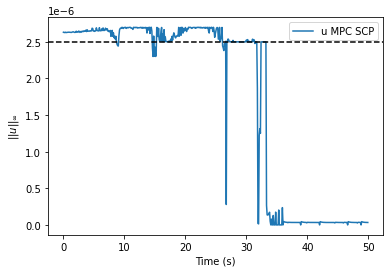

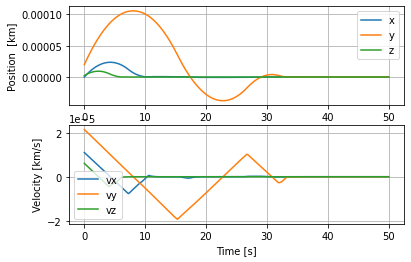

In [37]:
print(f"Shapes: t={t_mpc.shape}, s={s_mpc.shape}, u={u_mpc.shape}, norm(u)={np.linalg.norm(u_mpc, axis=0).shape}")

# plt.plot(tspan_optimize, np.linalg.norm(u_example.reshape(-1, 3), np.inf, axis=1), label="u initial")
# plt.plot(t_scp[:-1], np.linalg.norm(u_optimal_scp, np.inf, axis=1), label="u SCP single")
plt.plot(t_mpc[:u_mpc.shape[1]], np.linalg.norm(u_mpc, np.inf, axis=0), label="u MPC SCP")
plt.xlabel("Time (s)")
plt.ylabel("$||u||_\infty$")
plt.axhline(u_max, c='k', linestyle='--')
plt.legend()
plt.show()

dn.plot_relative_orbit(t_mpc[:s_mpc.shape[1]], s_mpc.T)

(501,)


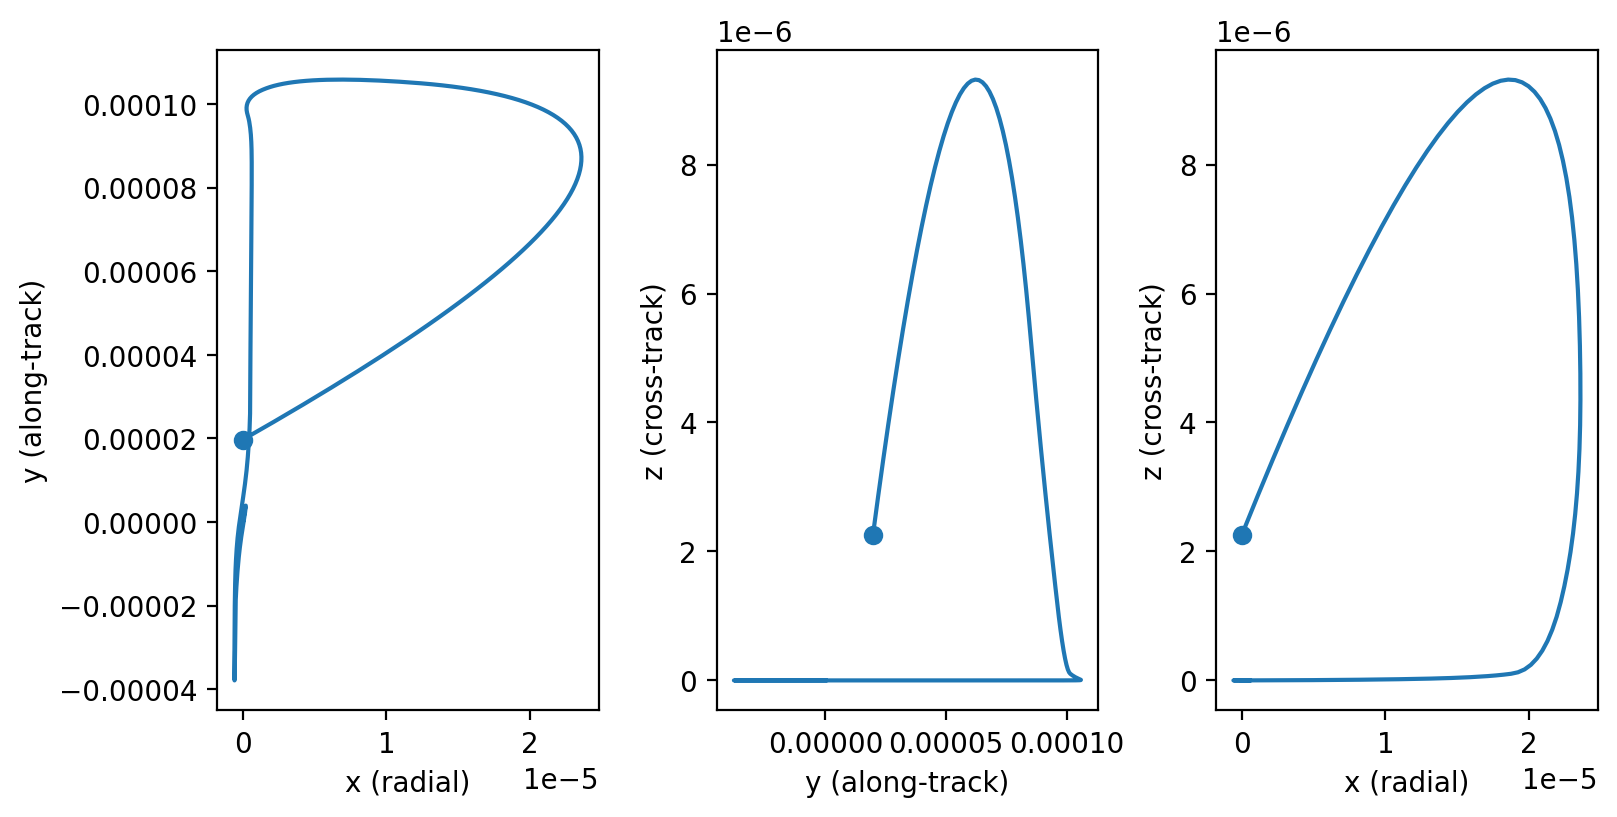

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 4), dpi=200)
print(s_mpc[0, :].shape)
ax[0].plot(s_mpc[0, :], s_mpc[1, :])
ax[0].scatter(s_mpc[0, 0], s_mpc[1, 0])
ax[0].set_xlabel("x (radial)")
ax[0].set_ylabel("y (along-track)")

ax[1].plot(s_mpc[1, :], s_mpc[2, :])
ax[1].scatter(s_mpc[1, 0], s_mpc[2, 0])
ax[1].set_xlabel("y (along-track)")
ax[1].set_ylabel("z (cross-track)")

ax[2].plot(s_mpc[0, :], s_mpc[2, :])
ax[2].scatter(s_mpc[0, 0], s_mpc[2, 0])
ax[2].set_xlabel("x (radial)")
ax[2].set_ylabel("z (cross-track)")


# fig.suptitle("Clairevoyant MPC Trajectory\n")
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.5)
plt.show()

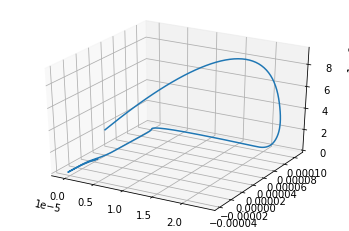

In [39]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(s_mpc[0, :], s_mpc[1, :], zs=s_mpc[2, :], zdir='z', label='MPC Curve')
plt.show()

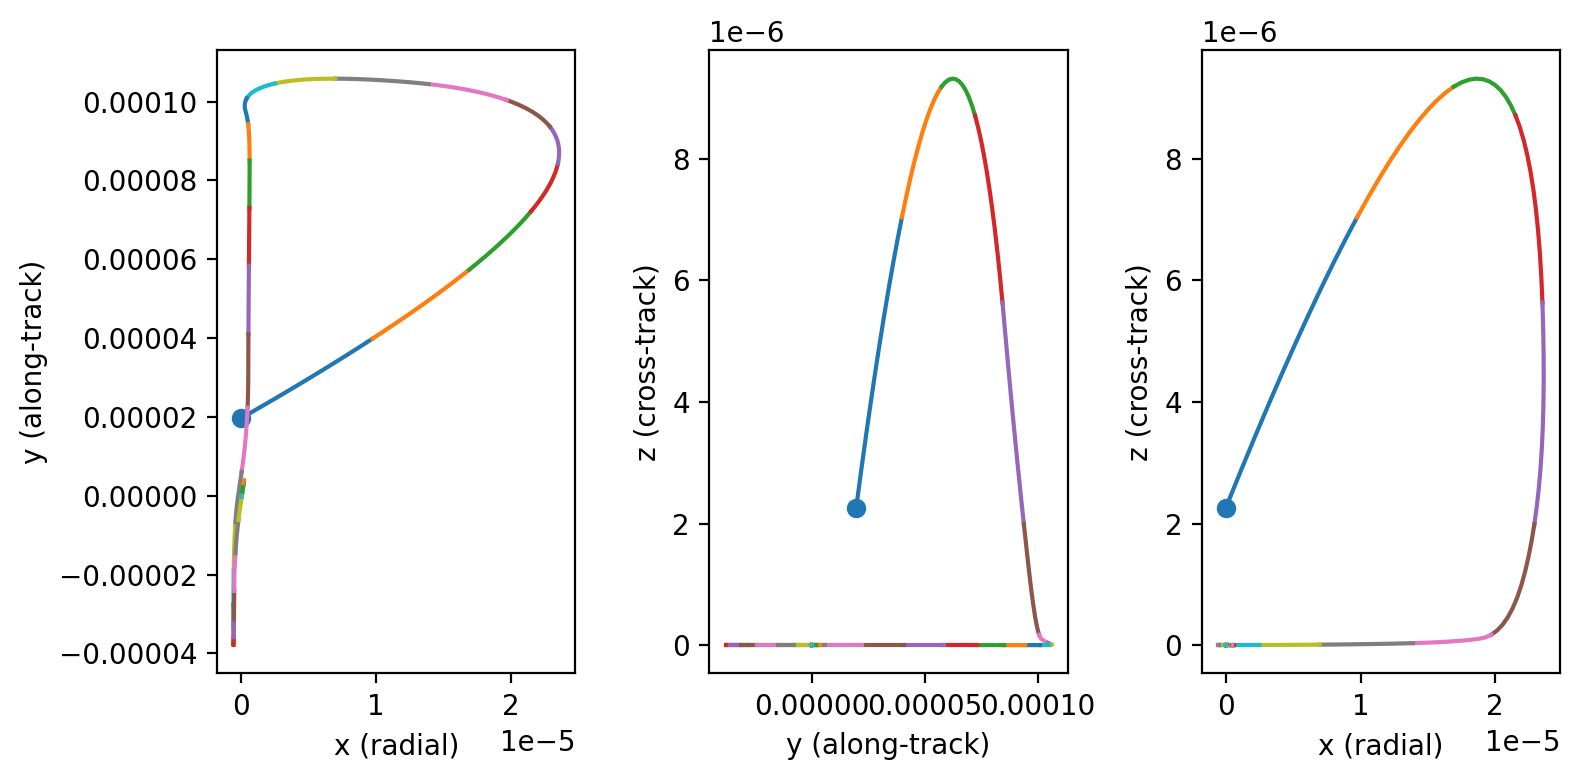

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 4), dpi=200)

ax[0].scatter(s_mpc[0, 0], s_mpc[1, 0])
ax[0].set_xlabel("x (radial)")
ax[0].set_ylabel("y (along-track)")

ax[1].scatter(s_mpc[1, 0], s_mpc[2, 0])
ax[1].set_xlabel("y (along-track)")
ax[1].set_ylabel("z (cross-track)")

ax[2].scatter(s_mpc[0, 0], s_mpc[2, 0])
ax[2].set_xlabel("x (radial)")
ax[2].set_ylabel("z (cross-track)")

times = range(0, 510, 10)
for t_lower, t_upper in zip(times[:-1], times[1:]):
  # print(f"{t_lower} to {t_upper}")
  ax[0].plot(s_mpc[0, t_lower:t_upper+1], s_mpc[1, t_lower:t_upper+1])
  ax[1].plot(s_mpc[1, t_lower:t_upper+1], s_mpc[2, t_lower:t_upper+1])
  ax[2].plot(s_mpc[0, t_lower:t_upper+1], s_mpc[2, t_lower:t_upper+1])
  # plt.pause(0.05)
  # plt.show(block=False)

plt.tight_layout()
plt.show()